# NOTEBOOK OUTLINE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PREREQUISITE INSTALLS

In [ ]:
!pip install catboost              # For Catboost classifier
!pip install dataprep               # For Dataprep interactive EDA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00


In [ ]:
!pip install optuna

In [ ]:
!pip install lightgbm

In [ ]:
%%bash
pip install codecarbon

mkdir code_carbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.2 MB/s eta 0:00:00


# IMPORT MAIN LIBRARIES

In [ ]:
#import main libraries
from codecarbon import EmissionsTracker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import catboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import ExtraTreesClassifier
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from imblearn.metrics import specificity_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# LOAD DATA

In [ ]:
# for reproducibility
np.random.seed(42)

In [ ]:
# LOCAL SYSTEM VERSION

df_initial = pd.read_csv('/content/drive/MyDrive/Glioma grading project/TCGA_GBM_LGG_Mutations_all.csv')

# Show the first 5 rows of the dataframe
print("\nFirst 5 rows of the dataframe: ")
df_initial.head()


First 5 rows of the dataframe: 


Grade   Project       Case_ID  Gender   Age_at_diagnosis  \
0   LGG  TCGA-LGG  TCGA-DU-8164    Male  51 years 108 days   
1   LGG  TCGA-LGG  TCGA-QH-A6CY    Male  38 years 261 days   
2   LGG  TCGA-LGG  TCGA-HW-A5KM    Male   35 years 62 days   
3   LGG  TCGA-LGG  TCGA-E1-A7YE  Female  32 years 283 days   
4   LGG  TCGA-LGG  TCGA-S9-A6WG    Male  31 years 187 days   

         Primary_Diagnosis   Race     IDH1         TP53         ATRX  ...  \
0   Oligodendroglioma, NOS  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
1             Mixed glioma  white  MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
2         Astrocytoma, NOS  white  MUTATED      MUTATED      MUTATED  ...   
3  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   
4  Astrocytoma, anaplastic  white  MUTATED      MUTATED      MUTATED  ...   

         FUBP1          RB1       NOTCH1         BCOR        CSMD3  \
0      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
1  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
2  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
3  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
4  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   

       SMARCA4       GRIN2A         IDH2         FAT4       PDGFRA  
0  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
1  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
2  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
3  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  
4  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  

[5 rows x 27 columns]

In [ ]:
filtered_df_ = df_initial[~df_initial['Age_at_diagnosis'].str.contains(r'^\d+ years \d+ days$', na=False)]

# Extract the values of 'Age_at_diagnosis' that do not match the pattern
values_not_in_pattern = filtered_df_['Age_at_diagnosis'].values

# Output the values that do not match the pattern
print(values_not_in_pattern)

['87 years' '--' '--' '67 years' '--' '--' '--']


In [ ]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA             862 non-null    object
 15  NF1                862 non-null    object
 16  PIK3R1             862 non-null    object
 1

In [ ]:
df_initial.describe()

Grade   Project       Case_ID Gender Age_at_diagnosis  \
count    862       862           862    862              862   
unique     2         2           862      3              838   
top      LGG  TCGA-LGG  TCGA-DU-8164   Male               --   
freq     499       499             1    499                5   

       Primary_Diagnosis   Race         IDH1         TP53         ATRX  ...  \
count                862    862          862          862          862  ...   
unique                 7      6            2            2            2  ...   
top         Glioblastoma  white  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
freq                 360    766          448          508          642  ...   

              FUBP1          RB1       NOTCH1         BCOR        CSMD3  \
count           862          862          862          862          862   
unique            2            2            2            2            2   
top     NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
freq            815          821          824          833          834   

            SMARCA4       GRIN2A         IDH2         FAT4       PDGFRA  
count           862          862          862          862          862  
unique            2            2            2            2            2  
top     NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
freq            834          835          839          839          840  

[4 rows x 27 columns]

### convert Age_at_diagnosis column

In [ ]:
def convert_to_float(value):
    # Check if the value contains the string ' years ' and ' days'
    if ' years ' in value and ' days' in value:
        years, days = value.split(' years ')
        days = days.replace(' days', '')
        years = int(years)
        days = int(days)
        fraction_of_year = days / 365
        result = years + fraction_of_year
        return result
    elif 'years' in value:
      values, years = value.split(' ')
      return int(values)
    else:
        # If the format is not as expected, return None or any default value as needed
        return '--'

In [ ]:
df_initial['Age_at_diagnosis'] = df_initial['Age_at_diagnosis'].apply(convert_to_float)

In [ ]:
df_initial

Grade   Project       Case_ID  Gender Age_at_diagnosis  \
0     LGG  TCGA-LGG  TCGA-DU-8164    Male         51.29589   
1     LGG  TCGA-LGG  TCGA-QH-A6CY    Male        38.715068   
2     LGG  TCGA-LGG  TCGA-HW-A5KM    Male        35.169863   
3     LGG  TCGA-LGG  TCGA-E1-A7YE  Female        32.775342   
4     LGG  TCGA-LGG  TCGA-S9-A6WG    Male        31.512329   
..    ...       ...           ...     ...              ...   
857   GBM  TCGA-GBM  TCGA-19-5959  Female        77.890411   
858   GBM  TCGA-GBM  TCGA-16-0846    Male        85.178082   
859   GBM  TCGA-GBM  TCGA-28-1746  Female        77.487671   
860   GBM  TCGA-GBM  TCGA-32-2491    Male        63.331507   
861   GBM  TCGA-GBM  TCGA-06-2557    Male        76.605479   

           Primary_Diagnosis                       Race         IDH1  \
0     Oligodendroglioma, NOS                      white      MUTATED   
1               Mixed glioma                      white      MUTATED   
2           Astrocytoma, NOS                      white      MUTATED   
3    Astrocytoma, anaplastic                      white      MUTATED   
4    Astrocytoma, anaplastic                      white      MUTATED   
..                       ...                        ...          ...   
857             Glioblastoma                      white  NOT_MUTATED   
858             Glioblastoma                      white  NOT_MUTATED   
859             Glioblastoma                      white  NOT_MUTATED   
860             Glioblastoma                      white  NOT_MUTATED   
861             Glioblastoma  black or african american  NOT_MUTATED   

            TP53         ATRX  ...        FUBP1          RB1       NOTCH1  \
0    NOT_MUTATED  NOT_MUTATED  ...      MUTATED  NOT_MUTATED  NOT_MUTATED   
1    NOT_MUTATED  NOT_MUTATED  ...  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
2        MUTATED      MUTATED  ...  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
3        MUTATED      MUTATED  ...  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
4        MUTATED      MUTATED  ...  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
..           ...          ...  ...          ...          ...          ...   
857  NOT_MUTATED  NOT_MUTATED  ...  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
858      MUTATED  NOT_MUTATED  ...  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
859      MUTATED  NOT_MUTATED  ...  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
860      MUTATED  NOT_MUTATED  ...  NOT_MUTATED      MUTATED  NOT_MUTATED   
861  NOT_MUTATED  NOT_MUTATED  ...  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   

            BCOR        CSMD3      SMARCA4       GRIN2A         IDH2  \
0    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
1    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
2    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
3    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
4    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
..           ...          ...          ...          ...          ...   
857  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
858  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
859  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
860  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
861  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   

            FAT4       PDGFRA  
0    NOT_MUTATED  NOT_MUTATED  
1    NOT_MUTATED  NOT_MUTATED  
2    NOT_MUTATED  NOT_MUTATED  
3        MUTATED  NOT_MUTATED  
4    NOT_MUTATED  NOT_MUTATED  
..           ...          ...  
857  NOT_MUTATED  NOT_MUTATED  
858  NOT_MUTATED  NOT_MUTATED  
859  NOT_MUTATED  NOT_MUTATED  
860  NOT_MUTATED  NOT_MUTATED  
861  NOT_MUTATED  NOT_MUTATED  

[862 rows x 27 columns]

In [ ]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Grade              862 non-null    object
 1   Project            862 non-null    object
 2   Case_ID            862 non-null    object
 3   Gender             862 non-null    object
 4   Age_at_diagnosis   862 non-null    object
 5   Primary_Diagnosis  862 non-null    object
 6   Race               862 non-null    object
 7   IDH1               862 non-null    object
 8   TP53               862 non-null    object
 9   ATRX               862 non-null    object
 10  PTEN               862 non-null    object
 11  EGFR               862 non-null    object
 12  CIC                862 non-null    object
 13  MUC16              862 non-null    object
 14  PIK3CA             862 non-null    object
 15  NF1                862 non-null    object
 16  PIK3R1             862 non-null    object
 1

In [ ]:
# List of columns to remove
columns_to_remove = ['Project', 'Case_ID', 'Primary_Diagnosis']

# Remove the specified columns
df_initial = df_initial.drop(columns=columns_to_remove)

In [ ]:
df_initial

Grade  Gender Age_at_diagnosis                       Race         IDH1  \
0     LGG    Male         51.29589                      white      MUTATED   
1     LGG    Male        38.715068                      white      MUTATED   
2     LGG    Male        35.169863                      white      MUTATED   
3     LGG  Female        32.775342                      white      MUTATED   
4     LGG    Male        31.512329                      white      MUTATED   
..    ...     ...              ...                        ...          ...   
857   GBM  Female        77.890411                      white  NOT_MUTATED   
858   GBM    Male        85.178082                      white  NOT_MUTATED   
859   GBM  Female        77.487671                      white  NOT_MUTATED   
860   GBM    Male        63.331507                      white  NOT_MUTATED   
861   GBM    Male        76.605479  black or african american  NOT_MUTATED   

            TP53         ATRX         PTEN         EGFR          CIC  ...  \
0    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
1    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED      MUTATED  ...   
2        MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
3        MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
4        MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
..           ...          ...          ...          ...          ...  ...   
857  NOT_MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
858      MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
859      MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
860      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
861  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   

           FUBP1          RB1       NOTCH1         BCOR        CSMD3  \
0        MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
1    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
2    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
3    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
4    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
..           ...          ...          ...          ...          ...   
857  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
858  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
859  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
860  NOT_MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
861  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   

         SMARCA4       GRIN2A         IDH2         FAT4       PDGFRA  
0    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
1    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
2    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
3    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  
4    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
..           ...          ...          ...          ...          ...  
857  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
858  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
859  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
860  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
861  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  

[862 rows x 24 columns]

In [ ]:
df_initial['Race'].value_counts()

white                               766
black or african american            59
not reported                         18
asian                                14
--                                    4
american indian or alaska native      1
Name: Race, dtype: int64

In [ ]:
# Define the conditions for filtering
race_condition = (df_initial['Race'] != 'not reported') & (df_initial['Race'] != '--')
gender_condition = (df_initial['Gender'] != '--')
Age_condition = (df_initial['Age_at_diagnosis'] != '--')

# Combine the conditions to filter the DataFrame
filtered_df = df_initial[race_condition & gender_condition & Age_condition]
# Reset the index to get a new DataFrame with a sorted index
filtered_df = filtered_df.reset_index(drop=True)

In [ ]:
filtered_df

Grade  Gender Age_at_diagnosis                       Race         IDH1  \
0     LGG    Male         51.29589                      white      MUTATED   
1     LGG    Male        38.715068                      white      MUTATED   
2     LGG    Male        35.169863                      white      MUTATED   
3     LGG  Female        32.775342                      white      MUTATED   
4     LGG    Male        31.512329                      white      MUTATED   
..    ...     ...              ...                        ...          ...   
834   GBM  Female        77.890411                      white  NOT_MUTATED   
835   GBM    Male        85.178082                      white  NOT_MUTATED   
836   GBM  Female        77.487671                      white  NOT_MUTATED   
837   GBM    Male        63.331507                      white  NOT_MUTATED   
838   GBM    Male        76.605479  black or african american  NOT_MUTATED   

            TP53         ATRX         PTEN         EGFR          CIC  ...  \
0    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
1    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED      MUTATED  ...   
2        MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
3        MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
4        MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
..           ...          ...          ...          ...          ...  ...   
834  NOT_MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
835      MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
836      MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
837      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   
838  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  ...   

           FUBP1          RB1       NOTCH1         BCOR        CSMD3  \
0        MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
1    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
2    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
3    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
4    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
..           ...          ...          ...          ...          ...   
834  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
835  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
836  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
837  NOT_MUTATED      MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   
838  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED   

         SMARCA4       GRIN2A         IDH2         FAT4       PDGFRA  
0    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
1    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
2    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
3    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED      MUTATED  NOT_MUTATED  
4    NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
..           ...          ...          ...          ...          ...  
834  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
835  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
836  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
837  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  
838  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  NOT_MUTATED  

[839 rows x 24 columns]

In [ ]:
# Convert the 'Column_Name' to float
filtered_df['Age_at_diagnosis'] = filtered_df['Age_at_diagnosis'].astype(float)

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Grade             839 non-null    object 
 1   Gender            839 non-null    object 
 2   Age_at_diagnosis  839 non-null    float64
 3   Race              839 non-null    object 
 4   IDH1              839 non-null    object 
 5   TP53              839 non-null    object 
 6   ATRX              839 non-null    object 
 7   PTEN              839 non-null    object 
 8   EGFR              839 non-null    object 
 9   CIC               839 non-null    object 
 10  MUC16             839 non-null    object 
 11  PIK3CA            839 non-null    object 
 12  NF1               839 non-null    object 
 13  PIK3R1            839 non-null    object 
 14  FUBP1             839 non-null    object 
 15  RB1               839 non-null    object 
 16  NOTCH1            839 non-null    object 
 1

In [ ]:
filtered_df['Grade'].value_counts()

LGG    487
GBM    352
Name: Grade, dtype: int64

In [ ]:
filtered_df.describe()

Age_at_diagnosis
count        839.000000
mean          50.935383
std           15.702388
min           14.421918
25%           38.050685
50%           51.550685
75%           62.800000
max           89.287671

The plot will not show in a notebook environment, please try 'show_browser' if you want to open it in browser



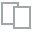
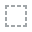
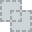
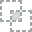
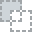
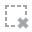
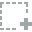
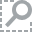
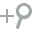
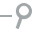
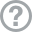
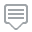
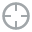
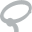
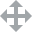
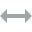
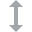
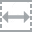
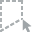
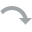
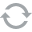
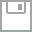
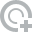
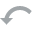
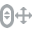
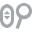
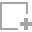
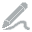
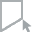
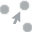
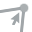
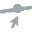

In [ ]:
from dataprep.eda import create_report, plot, plot_correlation, plot_missing , plot_diff

# Create Dataprep EDA report
report = create_report(filtered_df)

# Show the report
report.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
input_cols = list(filtered_df.columns)[1:]
target_col = 'Grade'

In [ ]:
input_cols

['Gender',
 'Age_at_diagnosis',
 'Race',
 'IDH1',
 'TP53',
 'ATRX',
 'PTEN',
 'EGFR',
 'CIC',
 'MUC16',
 'PIK3CA',
 'NF1',
 'PIK3R1',
 'FUBP1',
 'RB1',
 'NOTCH1',
 'BCOR',
 'CSMD3',
 'SMARCA4',
 'GRIN2A',
 'IDH2',
 'FAT4',
 'PDGFRA']

In [ ]:
train_inputs = filtered_df[input_cols].copy()
train_targets = filtered_df[target_col].copy()

In [ ]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [ ]:
numeric_cols

['Age_at_diagnosis']

In [ ]:
categorical_cols

['Gender',
 'Race',
 'IDH1',
 'TP53',
 'ATRX',
 'PTEN',
 'EGFR',
 'CIC',
 'MUC16',
 'PIK3CA',
 'NF1',
 'PIK3R1',
 'FUBP1',
 'RB1',
 'NOTCH1',
 'BCOR',
 'CSMD3',
 'SMARCA4',
 'GRIN2A',
 'IDH2',
 'FAT4',
 'PDGFRA']

#### Encoding of output variable with LabelEncoding

In [ ]:
le = LabelEncoder()
le.fit(train_targets)
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'GBM': 0, 'LGG': 1}

In [ ]:
train_targets = pd.Series(train_targets)

In [ ]:
# Convert values in the "Sex" column from "m" to "1" and from "f" to "0"
train_targets.loc[train_targets == "GBM"] = "0"
train_targets.loc[train_targets == "LGG"] = "1"

In [ ]:
# Convert all values in the dataframe to numeric
train_targets = train_targets.apply(pd.to_numeric, errors='coerce')

In [ ]:
train_targets

0      1
1      1
2      1
3      1
4      1
      ..
834    0
835    0
836    0
837    0
838    0
Name: Grade, Length: 839, dtype: int64

#### Split the data into training and testing

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataframe into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(train_inputs, train_targets, test_size=0.2, stratify = train_targets)#, random_state=42. #, shuffle=True

In [ ]:
X_train.to_csv('/content/drive/MyDrive/Hepatitis C Disease/X_train_.csv', index = False)

In [ ]:
# Show the classes balance in the training set
print('Training Set Class Balance: \n', y_train.value_counts())

Training Set Class Balance: 
 1    389
0    282
Name: Grade, dtype: int64


In [ ]:
# Show the classes balance in the test set
print('Test Set Class Balance: \n', y_test.value_counts())

Test Set Class Balance: 
 1    98
0    70
Name: Grade, dtype: int64


#### Encoding of Input categorical features with OneHotEncoding

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [ ]:
encoder.fit(filtered_df[categorical_cols])

In [ ]:
encoder.categories_

[array(['Female', 'Male'], dtype=object),
 array(['american indian or alaska native', 'asian',
        'black or african american', 'white'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=object),
 array(['MUTATED', 'NOT_MUTATED'], dtype=ob

In [ ]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [ ]:
print(encoded_cols)

In [ ]:
X_train[encoded_cols] = encoder.fit_transform(X_train[categorical_cols])

In [ ]:
X_train = X_train[numeric_cols + encoded_cols]

In [ ]:
X_train

In [ ]:
X_test[encoded_cols] = encoder.transform(X_test[categorical_cols])
X_test = X_test[numeric_cols + encoded_cols]

In [ ]:
X_train

Age_at_diagnosis  Gender_Female  Gender_Male  \
625         45.619178            1.0          0.0   
426         35.191781            1.0          0.0   
244         30.652055            0.0          1.0   
400         32.432877            0.0          1.0   
275         22.835616            0.0          1.0   
..                ...            ...          ...   
590         62.520548            0.0          1.0   
267         48.852055            0.0          1.0   
550         74.983562            1.0          0.0   
702         54.213699            1.0          0.0   
512         45.630137            1.0          0.0   

     Race_american indian or alaska native  Race_asian  \
625                                    0.0         0.0   
426                                    0.0         0.0   
244                                    0.0         0.0   
400                                    0.0         0.0   
275                                    0.0         0.0   
..                                     ...         ...   
590                                    0.0         0.0   
267                                    0.0         0.0   
550                                    0.0         0.0   
702                                    0.0         0.0   
512                                    0.0         0.0   

     Race_black or african american  Race_white  IDH1_MUTATED  \
625                             0.0         1.0           0.0   
426                             0.0         1.0           0.0   
244                             0.0         1.0           1.0   
400                             0.0         1.0           0.0   
275                             0.0         1.0           1.0   
..                              ...         ...           ...   
590                             0.0         1.0           0.0   
267                             0.0         1.0           1.0   
550                             0.0         1.0           0.0   
702                             1.0         0.0           0.0   
512                             0.0         1.0           1.0   

     IDH1_NOT_MUTATED  TP53_MUTATED  ...  SMARCA4_MUTATED  \
625               1.0           1.0  ...              0.0   
426               1.0           0.0  ...              0.0   
244               0.0           0.0  ...              0.0   
400               1.0           0.0  ...              0.0   
275               0.0           1.0  ...              0.0   
..                ...           ...  ...              ...   
590               1.0           1.0  ...              0.0   
267               0.0           1.0  ...              0.0   
550               1.0           1.0  ...              0.0   
702               1.0           0.0  ...              0.0   
512               0.0           1.0  ...              0.0   

     SMARCA4_NOT_MUTATED  GRIN2A_MUTATED  GRIN2A_NOT_MUTATED  IDH2_MUTATED  \
625                  1.0             0.0                 1.0           0.0   
426                  1.0             0.0                 1.0           1.0   
244                  1.0             1.0                 0.0           0.0   
400                  1.0             0.0                 1.0           1.0   
275                  1.0             0.0                 1.0           0.0   
..                   ...             ...                 ...           ...   
590                  1.0             0.0                 1.0           0.0   
267                  1.0             0.0                 1.0           0.0   
550                  1.0             0.0                 1.0           0.0   
702                  1.0             0.0                 1.0           0.0   
512                  1.0             0.0                 1.0           0.0   

     IDH2_NOT_MUTATED  FAT4_MUTATED  FAT4_NOT_MUTATED  PDGFRA_MUTATED  \
625               1.0           0.0               1.0             0.0   
426               0.0           0.0               1.0             0.0   
2

# Modeling

## Catboost without optimization

In [ ]:
# Catboost
model_Cat = catboost.CatBoostClassifier(verbose=False)
model_Cat.fit(X_train, y_train)

In [ ]:
y_pred_ = model_Cat.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_)
print("Accuracy : %.2f%%" % (accuracy * 100.0))

Accuracy : 91.51%


In [ ]:
y_pred = model_Cat.predict(X_test)
catboost_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : %.2f%%" % (catboost_accuracy * 100.0))

Accuracy : 87.50%


In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.8862244897959185

In [ ]:
# fror the testing
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.8101    0.9143    0.8591        70
           1     0.9326    0.8469    0.8877        98

    accuracy                         0.8750       168
   macro avg     0.8714    0.8806    0.8734       168
weighted avg     0.8816    0.8750    0.8758       168



Confusion matrix, without normalization
[[64  6]
 [15 83]]
Normalized confusion matrix
[[0.91428571 0.08571429]
 [0.15306122 0.84693878]]


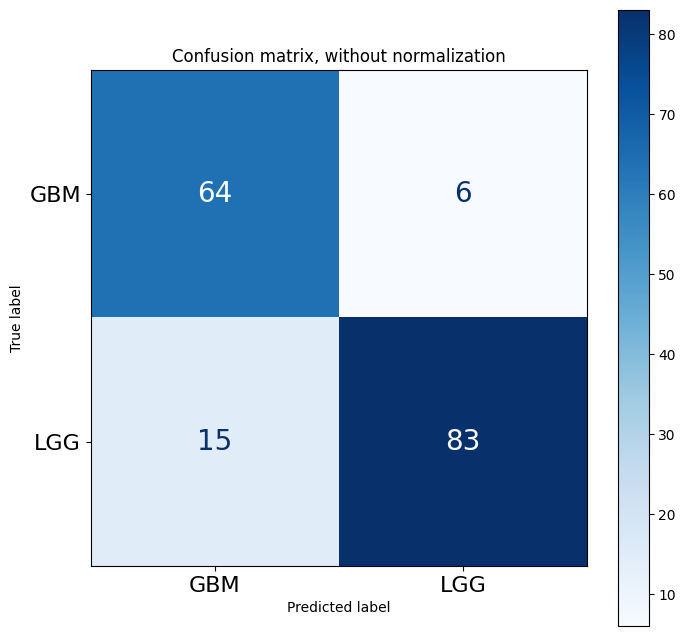

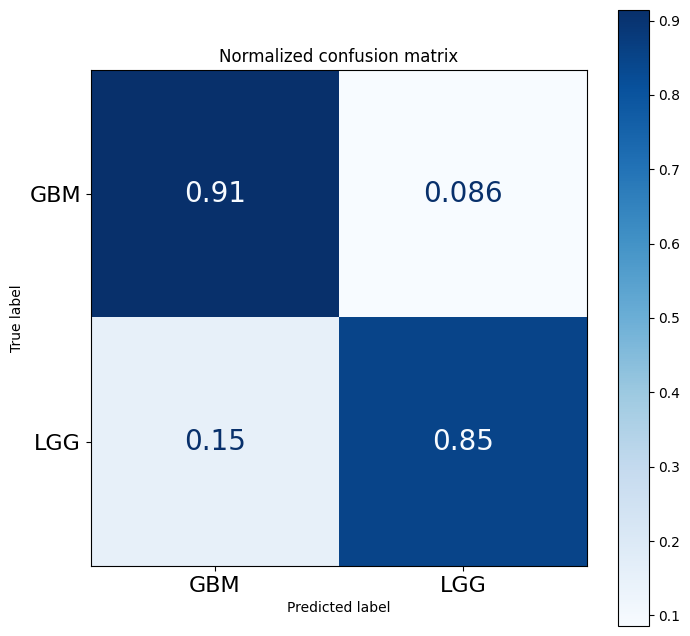

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        model_Cat,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    # Increase the font size of the displayed numbers using tick_params
    ax.tick_params(axis='both', which='major', labelsize=16)
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

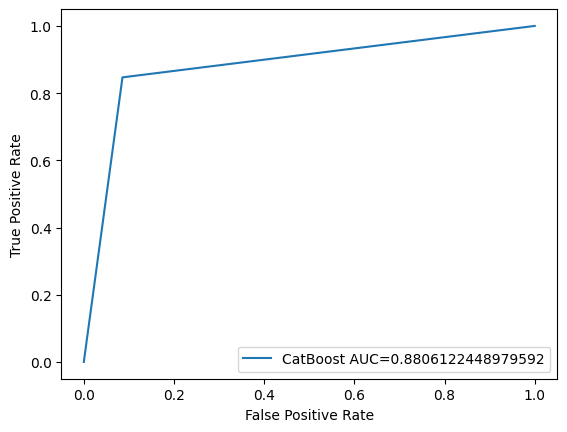

In [ ]:
#define metrics
#y_pred_proba = model_RandomF_optuna.predict_proba(X_test)[::,1]
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="CatBoost AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## CATBOOST WITH OPTUNA

In [ ]:
experiment_name = "CatBoost"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()



In [ ]:
def objective(trial):
    model_optuna = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=False
    )
    model_optuna.fit(X_train, y_train)
    y_pred = model_optuna.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [ ]:

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=500)

[I 2023-08-05 15:13:36,198] A new study created in memory with name: catboost
[I 2023-08-05 15:13:36,768] Trial 0 finished with value: 0.8690476190476191 and parameters: {'iterations': 475, 'learning_rate': 0.027583475549166746, 'depth': 4, 'l2_leaf_reg': 1.0551779964424746e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 2.0931628460945333e-07, 'bagging_temperature': 0.923385947687978, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 0 with value: 0.8690476190476191.
[I 2023-08-05 15:13:42,793] Trial 1 finished with value: 0.8869047619047619 and parameters: {'iterations': 585, 'learning_rate': 0.006892694481137703, 'depth': 8, 'l2_leaf_reg': 1.10795595820296e-06, 'bootstrap_type': 'Bayesian', 'random_strength': 0.7999391045172093, 'bagging_temperature': 0.27387593197926163, 'od_type': 'IncToDec', 'od_wait': 32}. Best is trial 1 with value: 0.8869047619047619.
[I 2023-08-05 15:13:48,264] Trial 2 finished with value: 0.8809523809523809 and parameters: {'iterations': 226, 'learning_

In [ ]:
# Evaluate emissions
catboost_emissions = tracker.stop()
print(f"Emissions from this training run: {catboost_emissions:.5f} kg CO2eq")

Emissions from this training run: 0.01601 kg CO2eq


In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  500
Best trial:
  Value:  0.8988095238095238
  Params: 
    iterations: 783
    learning_rate: 0.0011021848403602586
    depth: 10
    l2_leaf_reg: 1.2550157009924988e-07
    bootstrap_type: Bayesian
    random_strength: 2.9111452604270163e-05
    bagging_temperature: 4.773896819539796
    od_type: Iter
    od_wait: 25


In [ ]:
params = trial.params
params

{'iterations': 783,
 'learning_rate': 0.0011021848403602586,
 'depth': 10,
 'l2_leaf_reg': 1.2550157009924988e-07,
 'bootstrap_type': 'Bayesian',
 'random_strength': 2.9111452604270163e-05,
 'bagging_temperature': 4.773896819539796,
 'od_type': 'Iter',
 'od_wait': 25}

In [ ]:
model_Cat_optuna = catboost.CatBoostClassifier(**params, verbose=False)
model_Cat_optuna.fit(X_train, y_train)

In [ ]:
y_pred = model_Cat_optuna.predict(X_test)
catboost_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (catboost_accuracy * 100.0))


Accuracy after tuning: 89.88%


In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.8354    0.9429    0.8859        70
           1     0.9551    0.8673    0.9091        98

    accuracy                         0.8988       168
   macro avg     0.8952    0.9051    0.8975       168
weighted avg     0.9052    0.8988    0.8994       168



In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.9113945578231292

Confusion matrix, without normalization
[[66  4]
 [13 85]]
Normalized confusion matrix
[[0.94285714 0.05714286]
 [0.13265306 0.86734694]]


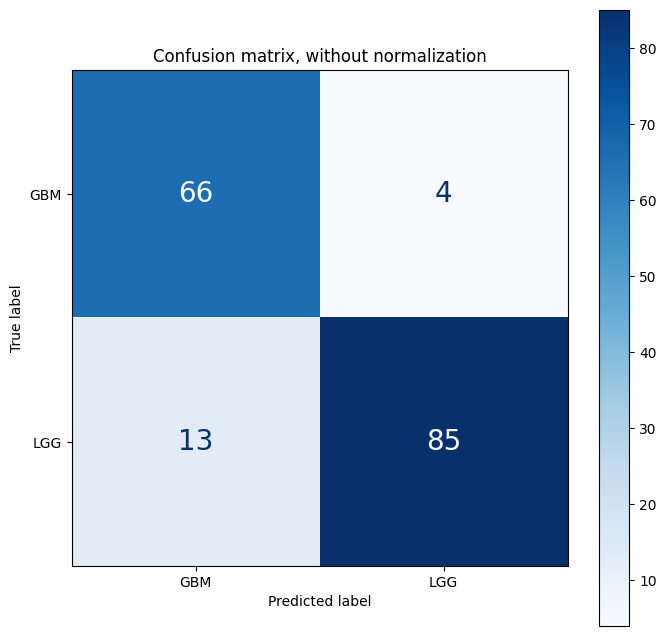

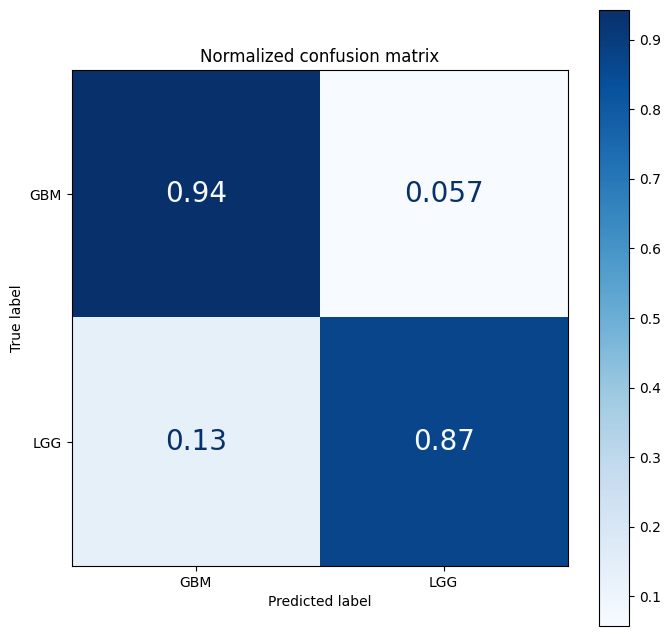

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        model_Cat_optuna,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_Cat_optuna.feature_importances_,X_train.columns)), columns=['Value','Feature'])
feature_imp

Value                                Feature
0    0.000000                          FUBP1_MUTATED
1    0.000000                      FUBP1_NOT_MUTATED
2    0.006252                         NOTCH1_MUTATED
3    0.009072  Race_american indian or alaska native
4    0.015017                     NOTCH1_NOT_MUTATED
5    0.032471                      CSMD3_NOT_MUTATED
6    0.036451                          CSMD3_MUTATED
7    0.051541                    SMARCA4_NOT_MUTATED
8    0.062529                     GRIN2A_NOT_MUTATED
9    0.089693                        SMARCA4_MUTATED
10   0.097427                         GRIN2A_MUTATED
11   0.160798                           FAT4_MUTATED
12   0.179661                       FAT4_NOT_MUTATED
13   0.186652                         PDGFRA_MUTATED
14   0.196076                       BCOR_NOT_MUTATED
15   0.196563                     PDGFRA_NOT_MUTATED
16   0.198137                           BCOR_MUTATED
17   0.212004                        RB1_NOT_MUTATED
18   0.221927                             Race_asian
19   0.283052                            RB1_MUTATED
20   0.451427                     PIK3R1_NOT_MUTATED
21   0.520348                            CIC_MUTATED
22   0.542515         Race_black or african american
23   0.545365                        CIC_NOT_MUTATED
24   0.594949                         PIK3R1_MUTATED
25   0.674538                           IDH2_MUTATED
26   0.709818                       IDH2_NOT_MUTATED
27   0.804887                        NF1_NOT_MUTATED
28   0.947652                      MUC16_NOT_MUTATED
29   1.062999                            NF1_MUTATED
30   1.078191                         PIK3CA_MUTATED
31   1.258796                     PIK3CA_NOT_MUTATED
32   1.429387                       ATRX_NOT_MUTATED
33   1.487055                          MUC16_MUTATED
34   1.528071                           ATRX_MUTATED
35   2.021259                       EGFR_NOT_MUTATED
36   2.325221                             Race_white
37   2.601901                           EGFR_MUTATED
38   2.991001                           PTEN_MUTATED
39   3.027048                       PTEN_NOT_MUTATED
40   4.063118                            Gender_Male
41   4.108983                          Gender_Female
42   9.588705                           TP53_MUTATED
43  10.056928                       TP53_NOT_MUTATED
44  12.970018                           IDH1_MUTATED
45  14.828366                       IDH1_NOT_MUTATED
46  15.546129                       Age_at_diagnosis

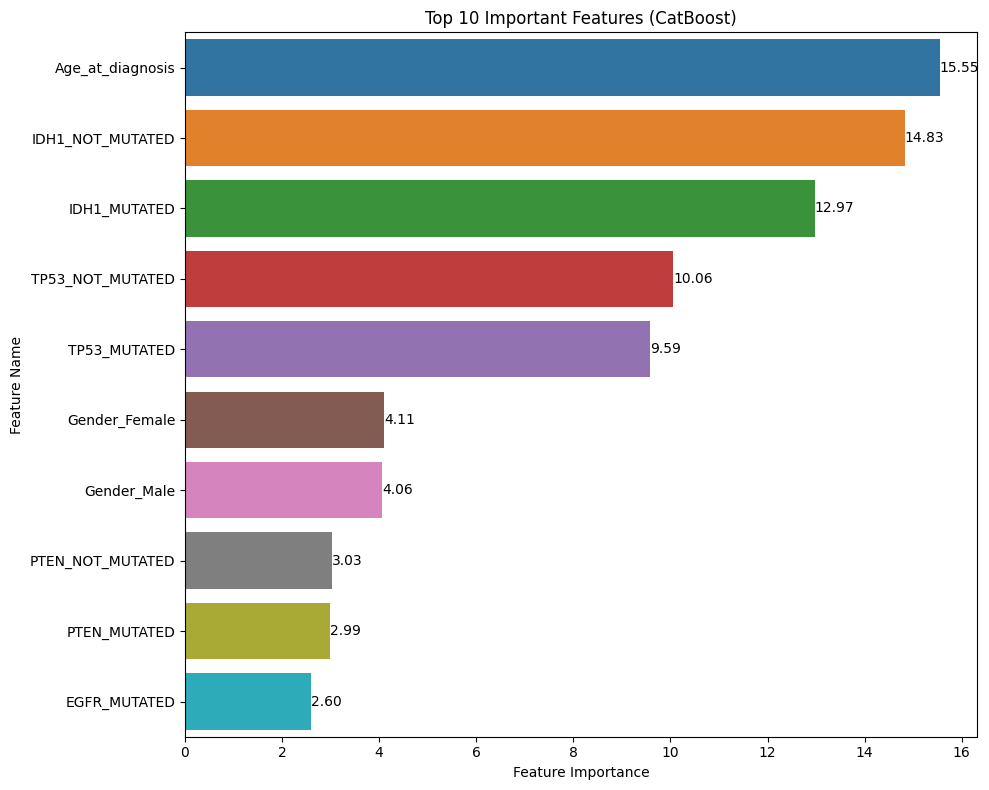

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_Cat_optuna.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

# Select the top 10 features with the largest importance values
top_10_features = feature_imp.nlargest(10, 'Value')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Value", y="Feature", data=top_10_features)
plt.title('Top 10 Important Features (CatBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# Annotate each bar with its value
for index, value in enumerate(top_10_features['Value']):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


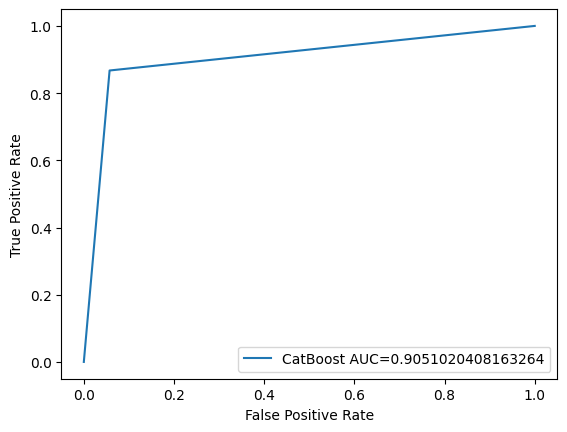

In [ ]:
#define metrics
#y_pred_proba = model_RandomF_optuna.predict_proba(X_test)[::,1]
from sklearn.metrics import roc_curve, roc_auc_score
fpr_cat, tpr_cat, _ = roc_curve(y_test,  y_pred)
auc_cat = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr_cat,tpr_cat,label="CatBoost AUC="+str(auc_cat))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## XGBoost without optimization

In [ ]:
model_xgb = XGBClassifier(use_label_encoder=False,
                      eval_metric='mlogloss')
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [ ]:
y_pred = model_xgb.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (xgboost_accuracy * 100.0))

Accuracy: 81.55%


In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.81921768707483

In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7532    0.8286    0.7891        70
           1     0.8681    0.8061    0.8360        98

    accuracy                         0.8155       168
   macro avg     0.8107    0.8173    0.8125       168
weighted avg     0.8203    0.8155    0.8165       168



Confusion matrix, without normalization
[[58 12]
 [19 79]]
Normalized confusion matrix
[[0.82857143 0.17142857]
 [0.19387755 0.80612245]]


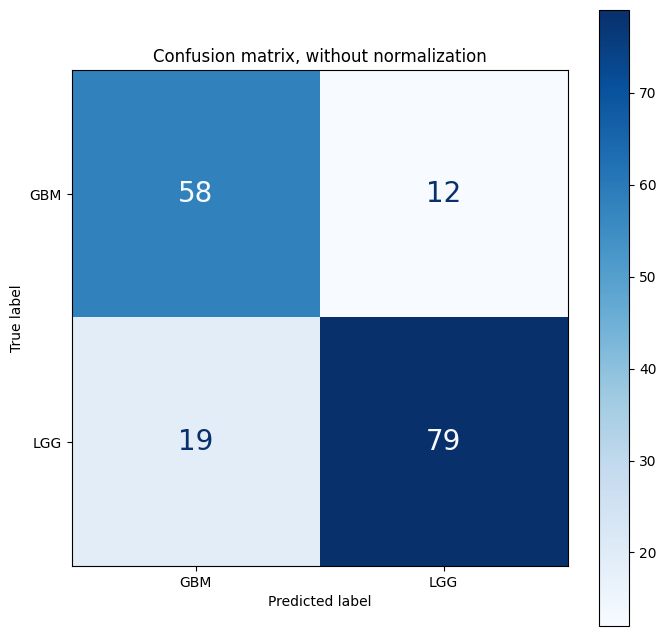

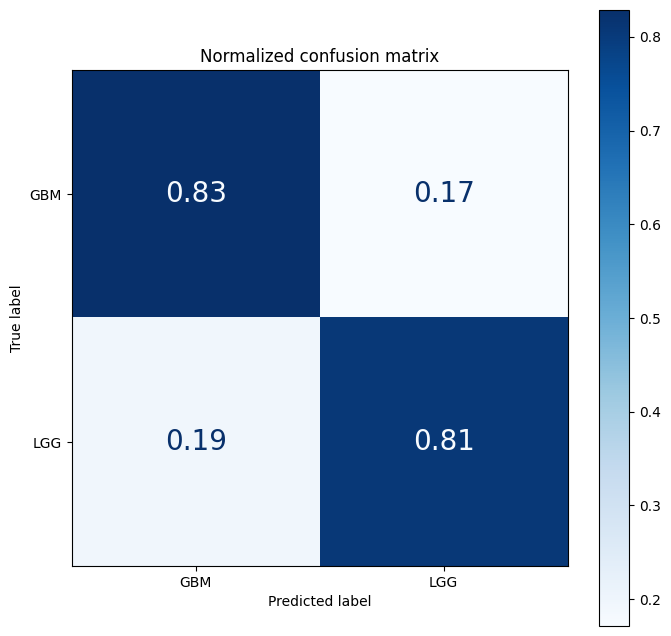

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        model_xgb,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

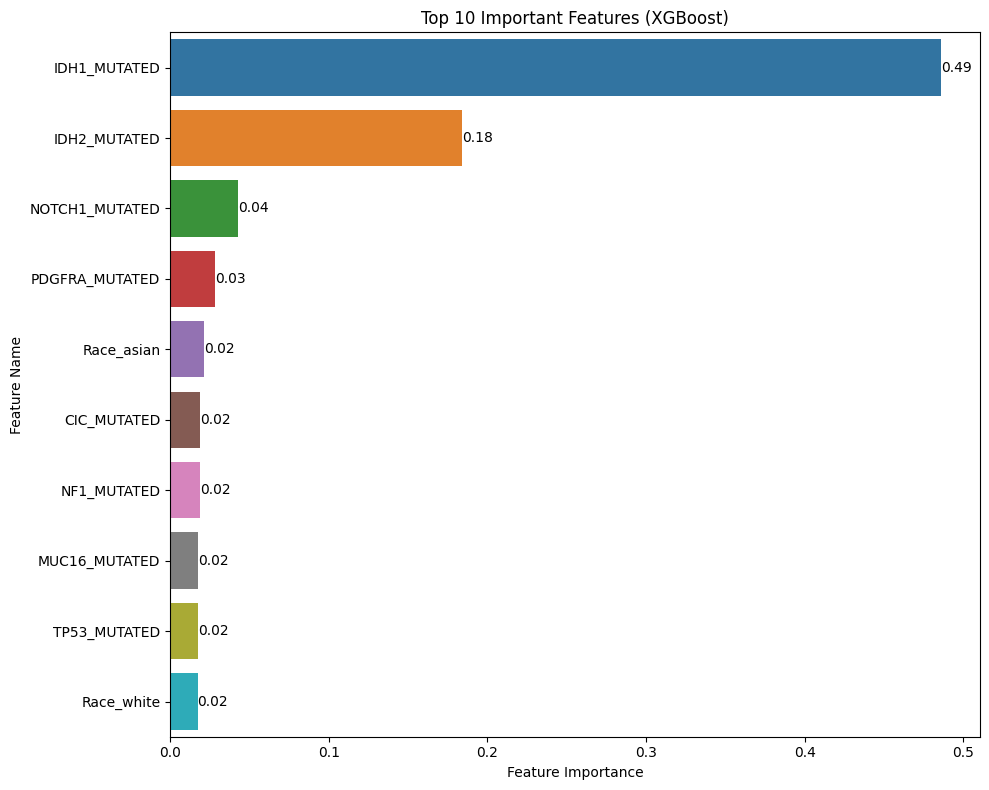

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_xgb.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

# Select the top 10 features with the largest importance values
top_10_features = feature_imp.nlargest(10, 'Value')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Value", y="Feature", data=top_10_features)
plt.title('Top 10 Important Features (XGBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# Annotate each bar with its value
for index, value in enumerate(top_10_features['Value']):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


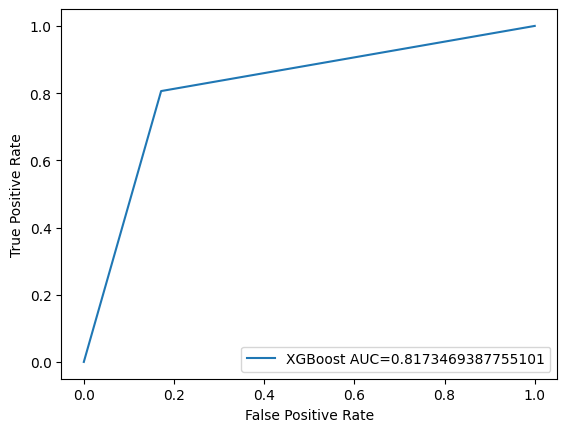

In [ ]:
#define metrics
#y_pred_proba = model_RandomF_optuna.predict_proba(X_test)[::,1]
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="XGBoost AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## XGBClassifier with Optuna

In [ ]:
import xgboost
experiment_name = "XGBoost"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()



In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }



    optuna_model = XGBClassifier(**params)
    # # Perform cross-validation on the training set
    # cv_scores = cross_val_score(optuna_model, X_train, y_train, cv=10, scoring='accuracy')

    # # Calculate the mean accuracy from cross-validation scores
    # cv_accuracy = cv_scores.mean()

    # Train the model on the full training set
    optuna_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    test_preds = optuna_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)

    # Return both cross-validation and test set accuracy
    return test_accuracy

In [ ]:
study = optuna.create_study(study_name="xgboost", direction='maximize')
study.optimize(objective, n_trials=500)

[I 2023-08-05 18:09:30,587] A new study created in memory with name: xgboost
[I 2023-08-05 18:09:37,073] Trial 0 finished with value: 0.4166666666666667 and parameters: {'max_depth': 3, 'learning_rate': 0.04761037123152829, 'n_estimators': 379, 'min_child_weight': 9, 'gamma': 8.430609977159348e-05, 'subsample': 0.011991320094268485, 'colsample_bytree': 0.35843104347866556, 'reg_alpha': 2.1879856657620568e-05, 'reg_lambda': 0.15642217537904465}. Best is trial 0 with value: 0.4166666666666667.
[I 2023-08-05 18:09:37,884] Trial 1 finished with value: 0.8690476190476191 and parameters: {'max_depth': 1, 'learning_rate': 0.387868164640212, 'n_estimators': 128, 'min_child_weight': 5, 'gamma': 5.263631634967355e-08, 'subsample': 0.17533980761964318, 'colsample_bytree': 0.5303242433446826, 'reg_alpha': 0.0010946524705748278, 'reg_lambda': 0.002073729344035819}. Best is trial 1 with value: 0.8690476190476191.
[I 2023-08-05 18:09:39,922] Trial 2 finished with value: 0.5833333333333334 and paramet

In [ ]:
# Evaluate emissions
xgboost_emissions = tracker.stop()
print(f"Emissions from this training run: {xgboost_emissions:.5f} kg CO2eq")

Emissions from this training run: 0.00386 kg CO2eq


In [ ]:
#without cv
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 500
Best trial:
  Value: 0.9047619047619048
  Params: 
    max_depth: 8
    learning_rate: 0.027331919351653494
    n_estimators: 242
    min_child_weight: 2
    gamma: 0.003069814708467142
    subsample: 0.9927144701324333
    colsample_bytree: 0.1584430697401213
    reg_alpha: 0.03356609982370867
    reg_lambda: 1.649604356154638e-07


In [ ]:
params = trial.params
params

{'max_depth': 8,
 'learning_rate': 0.027331919351653494,
 'n_estimators': 242,
 'min_child_weight': 2,
 'gamma': 0.003069814708467142,
 'subsample': 0.9927144701324333,
 'colsample_bytree': 0.1584430697401213,
 'reg_alpha': 0.03356609982370867,
 'reg_lambda': 1.649604356154638e-07}

In [ ]:

model_xgb_optuna = XGBClassifier(**params)
model_xgb_optuna.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1584430697401213, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.003069814708467142, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.027331919351653494, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=242, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
#93.49
y_pred = model_xgb_optuna.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (xgboost_accuracy * 100.0))

Accuracy after tuning: 90.48%


In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred, digits = 4)) 

              precision    recall  f1-score   support

           0     0.8462    0.9429    0.8919        70
           1     0.9556    0.8776    0.9149        98

    accuracy                         0.9048       168
   macro avg     0.9009    0.9102    0.9034       168
weighted avg     0.9100    0.9048    0.9053       168



In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.9156462585034013

Confusion matrix, without normalization
[[66  4]
 [12 86]]
Normalized confusion matrix
[[0.94285714 0.05714286]
 [0.12244898 0.87755102]]


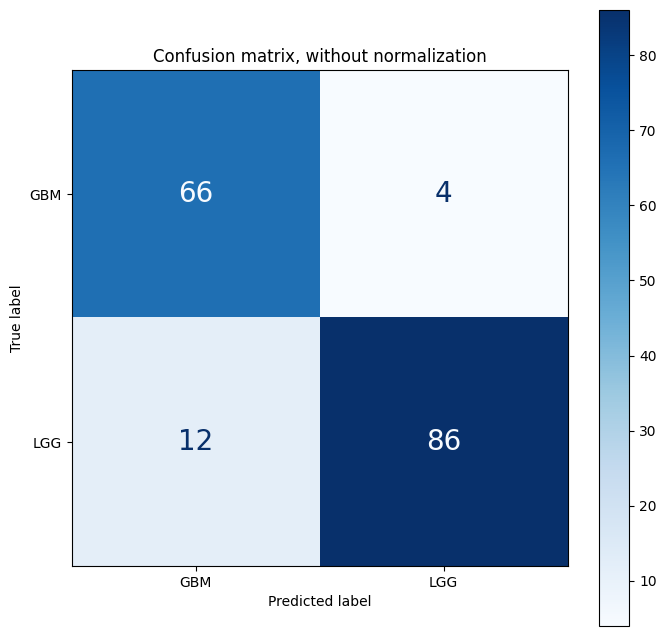

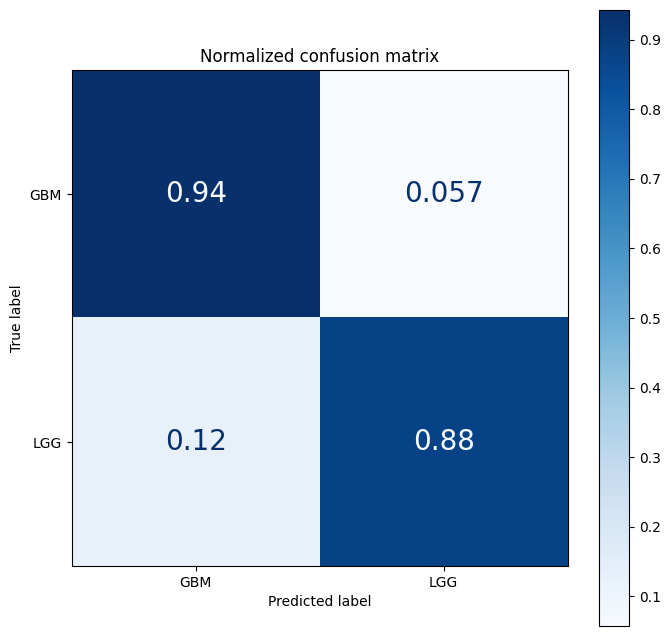

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        model_xgb_optuna,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_xgb_optuna.feature_importances_,X_train.columns)), columns=['Value','Feature'])
feature_imp

Value                                Feature
0   0.000000  Race_american indian or alaska native
1   0.000942                           BCOR_MUTATED
2   0.001189                     PIK3CA_NOT_MUTATED
3   0.001380                       BCOR_NOT_MUTATED
4   0.001518                            Gender_Male
5   0.001531                         PIK3CA_MUTATED
6   0.001689                             Race_asian
7   0.002112                          Gender_Female
8   0.002597         Race_black or african american
9   0.003166                          CSMD3_MUTATED
10  0.003285                        NF1_NOT_MUTATED
11  0.003303                            NF1_MUTATED
12  0.003826                      CSMD3_NOT_MUTATED
13  0.004025                             Race_white
14  0.004108                           FAT4_MUTATED
15  0.004523                     PIK3R1_NOT_MUTATED
16  0.005347                         GRIN2A_MUTATED
17  0.005634                     GRIN2A_NOT_MUTATED
18  0.005684                       FAT4_NOT_MUTATED
19  0.005715                      MUC16_NOT_MUTATED
20  0.006084                       TP53_NOT_MUTATED
21  0.006976                          MUC16_MUTATED
22  0.007547                         PIK3R1_MUTATED
23  0.008037                        RB1_NOT_MUTATED
24  0.008081                           EGFR_MUTATED
25  0.008107                       EGFR_NOT_MUTATED
26  0.008387                    SMARCA4_NOT_MUTATED
27  0.009278                        SMARCA4_MUTATED
28  0.009578                           TP53_MUTATED
29  0.009582                       Age_at_diagnosis
30  0.011566                          FUBP1_MUTATED
31  0.013938                            RB1_MUTATED
32  0.014232                     PDGFRA_NOT_MUTATED
33  0.014399                         PDGFRA_MUTATED
34  0.015532                       ATRX_NOT_MUTATED
35  0.018679                           IDH2_MUTATED
36  0.020145                           PTEN_MUTATED
37  0.020317                     NOTCH1_NOT_MUTATED
38  0.025325                       IDH2_NOT_MUTATED
39  0.025328                       PTEN_NOT_MUTATED
40  0.025444                         NOTCH1_MUTATED
41  0.025459                           ATRX_MUTATED
42  0.027339                      FUBP1_NOT_MUTATED
43  0.033107                        CIC_NOT_MUTATED
44  0.041830                            CIC_MUTATED
45  0.217693                           IDH1_MUTATED
46  0.306439                       IDH1_NOT_MUTATED

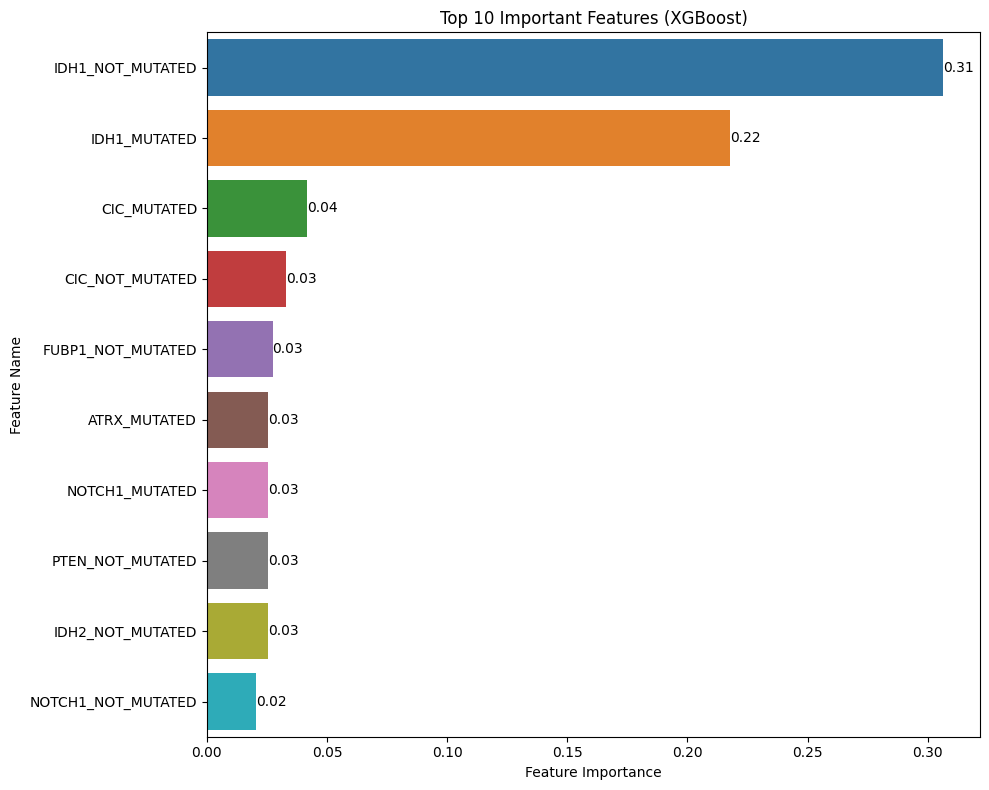

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_xgb_optuna.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

# Select the top 10 features with the largest importance values
top_10_features = feature_imp.nlargest(10, 'Value')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Value", y="Feature", data=top_10_features)
plt.title('Top 10 Important Features (XGBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# Annotate each bar with its value
for index, value in enumerate(top_10_features['Value']):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


Save the model for deployment

In [ ]:
import pickle

In [ ]:
file_name = '/content/drive/MyDrive/Glioma grading project/my_model_glioma_xgb.sav'
pickle.dump(model_xgb_optuna, open(file_name, 'wb'))

In [ ]:
X_train.to_csv('/content/drive/MyDrive/Glioma grading project/X_train.csv', index = False)

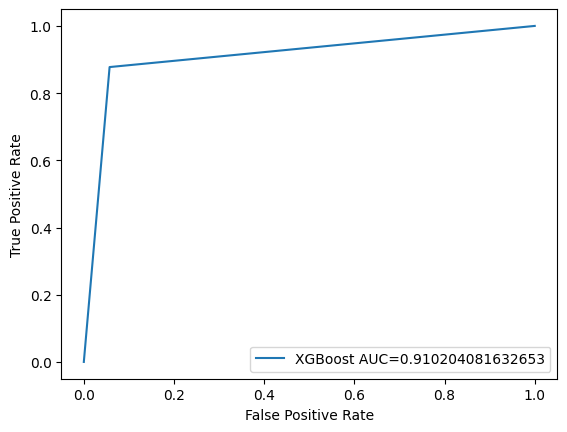

In [ ]:
#define metrics
#y_pred_proba = model_RandomF_optuna.predict_proba(X_test)[::,1]
from sklearn.metrics import roc_curve, roc_auc_score
fpr_xgb, tpr_xgb, _ = roc_curve(y_test,  y_pred)
auc_xgb = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr_xgb,tpr_xgb,label="XGBoost AUC="+str(auc_xgb))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## LGBM without optimization

In [ ]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
y_pred = lgb_model.predict(X_test)
lgb_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : %.2f%%" % (lgb_accuracy * 100.0))

Accuracy : 82.74%


In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.8195578231292519

In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7887    0.8000    0.7943        70
           1     0.8557    0.8469    0.8513        98

    accuracy                         0.8274       168
   macro avg     0.8222    0.8235    0.8228       168
weighted avg     0.8278    0.8274    0.8276       168



Confusion matrix, without normalization
[[56 14]
 [15 83]]
Normalized confusion matrix
[[0.8        0.2       ]
 [0.15306122 0.84693878]]


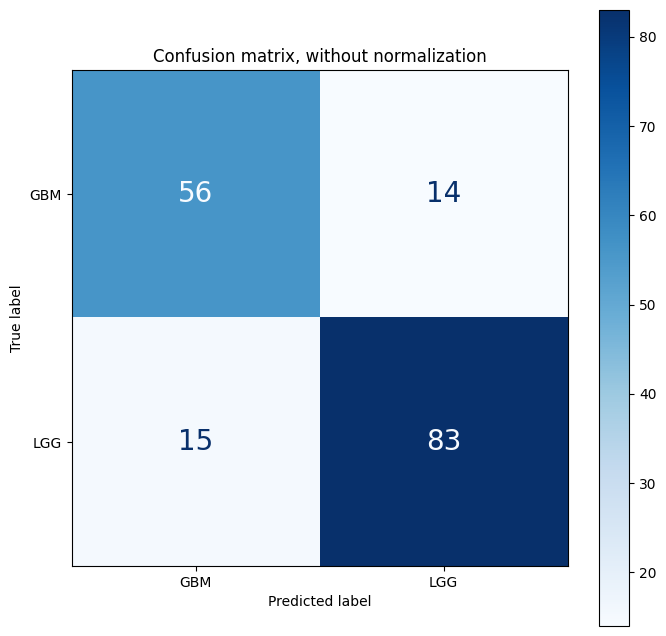

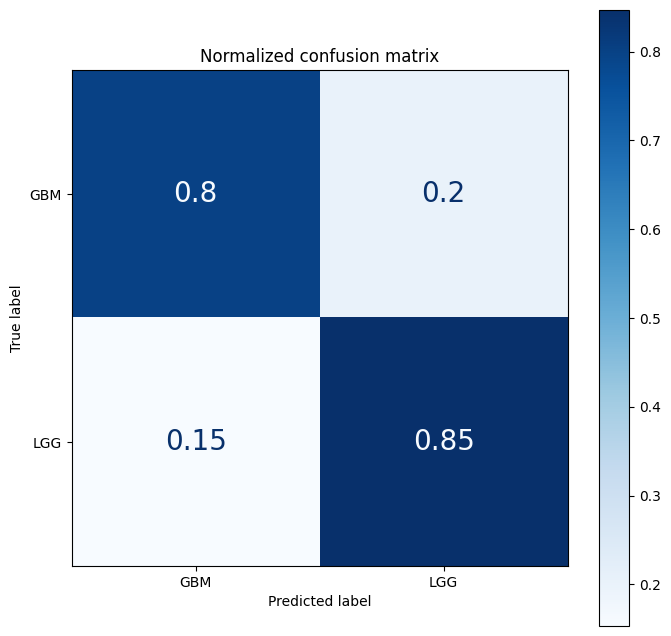

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        lgb_model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

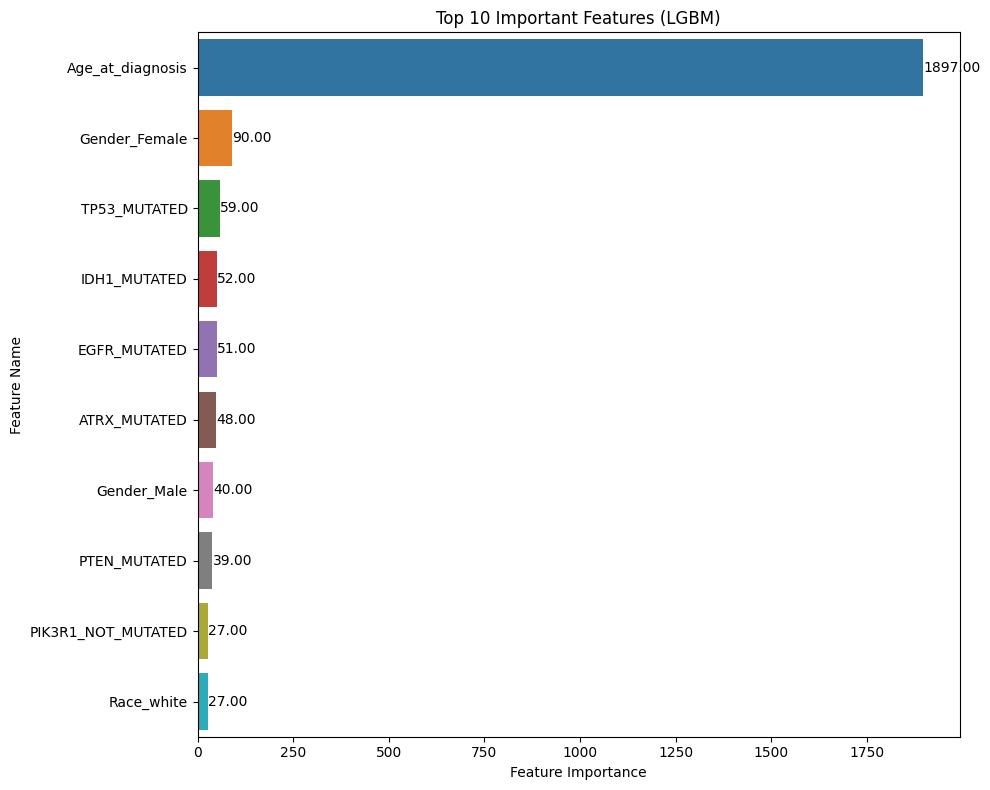

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgb_model.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

# Select the top 10 features with the largest importance values
top_10_features = feature_imp.nlargest(10, 'Value')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Value", y="Feature", data=top_10_features)
plt.title('Top 10 Important Features (LGBM)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# Annotate each bar with its value
for index, value in enumerate(top_10_features['Value']):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


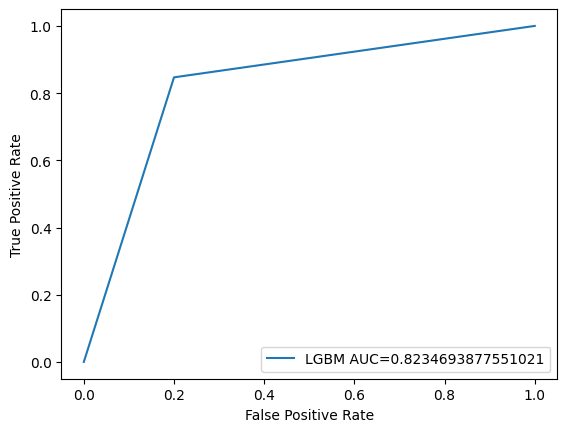

In [ ]:
#define metrics
#y_pred_proba = model_RandomF_optuna.predict_proba(X_test)[::,1]
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="LGBM AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## LGBM with Optuna

In [ ]:
experiment_name = "LGBM"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()



In [ ]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "num_class": 1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    gbm = lgb.LGBMClassifier(**param)
    gbm.fit(X_train, y_train)
    preds = gbm.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

In [ ]:
sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=500)

[I 2023-08-05 19:05:17,408] A new study created in memory with name: lightgbm


[LightGBM] [Warning] feature_fraction is set=0.5813995435791038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5813995435791038
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.030403280126677572, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030403280126677572
[LightGBM] [Warning] bagging_fraction is set=0.48805353449026784, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48805353449026784
[LightGBM] [Warning] lambda_l1 is set=5.6649755830282306e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.6649755830282306e-05


[I 2023-08-05 19:05:19,269] Trial 0 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 5.6649755830282306e-05, 'lambda_l2': 0.030403280126677572, 'num_leaves': 2, 'feature_fraction': 0.5813995435791038, 'bagging_fraction': 0.48805353449026784, 'bagging_freq': 1, 'min_child_samples': 22}. Best is trial 0 with value: 0.8690476190476191.


[LightGBM] [Warning] feature_fraction is set=0.6515167086419769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6515167086419769
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.72312200494449e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.72312200494449e-05
[LightGBM] [Warning] bagging_fraction is set=0.8111317002380557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8111317002380557
[LightGBM] [Warning] lambda_l1 is set=1.2883876209377052e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2883876209377052e-05


[I 2023-08-05 19:05:20,032] Trial 1 finished with value: 0.875 and parameters: {'lambda_l1': 1.2883876209377052e-05, 'lambda_l2': 3.72312200494449e-05, 'num_leaves': 139, 'feature_fraction': 0.6515167086419769, 'bagging_fraction': 0.8111317002380557, 'bagging_freq': 2, 'min_child_samples': 89}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:20,101] Trial 2 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.763958399884789e-08, 'lambda_l2': 0.010819509974097813, 'num_leaves': 108, 'feature_fraction': 0.735213897067451, 'bagging_fraction': 0.4842321631571403, 'bagging_freq': 2, 'min_child_samples': 81}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:20,214] Trial 3 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 5.180291295699627, 'lambda_l2': 6.6193844201488494e-06, 'num_leaves': 178, 'feature_fraction': 0.9258334913776229, 'bagging_fraction': 0.9367639981023084, 'bagging_freq': 1, 'min_child_samples': 8}. Best is trial 1 with v

[LightGBM] [Warning] feature_fraction is set=0.735213897067451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.735213897067451
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.010819509974097813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010819509974097813
[LightGBM] [Warning] bagging_fraction is set=0.4842321631571403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4842321631571403
[LightGBM] [Warning] lambda_l1 is set=1.763958399884789e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.763958399884789e-08
[LightGBM] [Warning] feature_fraction is set=0.9258334913776229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9258334913776229
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.61938442014884

[I 2023-08-05 19:05:20,290] Trial 4 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 3.376554594427989e-07, 'lambda_l2': 0.8003547575557912, 'num_leaves': 27, 'feature_fraction': 0.6526645750030313, 'bagging_fraction': 0.9747337180903012, 'bagging_freq': 4, 'min_child_samples': 71}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:20,374] Trial 5 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 6.912588094940543e-06, 'lambda_l2': 0.015083716080906013, 'num_leaves': 214, 'feature_fraction': 0.4109729664065151, 'bagging_fraction': 0.8500865889669804, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 1 with value: 0.875.


[LightGBM] [Warning] feature_fraction is set=0.4109729664065151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4109729664065151
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.015083716080906013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015083716080906013
[LightGBM] [Warning] bagging_fraction is set=0.8500865889669804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8500865889669804
[LightGBM] [Warning] lambda_l1 is set=6.912588094940543e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.912588094940543e-06
[LightGBM] [Warning] feature_fraction is set=0.6687361157055431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6687361157055431
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.126915292804

[I 2023-08-05 19:05:20,911] Trial 6 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 3.341919070318744e-06, 'lambda_l2': 0.12691529280491062, 'num_leaves': 28, 'feature_fraction': 0.6687361157055431, 'bagging_fraction': 0.9451573018558573, 'bagging_freq': 3, 'min_child_samples': 32}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:21,107] Trial 7 finished with value: 0.8452380952380952 and parameters: {'lambda_l1': 1.4799844388224288e-07, 'lambda_l2': 1.493834966470408e-08, 'num_leaves': 175, 'feature_fraction': 0.5269768696000354, 'bagging_fraction': 0.5593279956233357, 'bagging_freq': 4, 'min_child_samples': 10}. Best is trial 1 with value: 0.875.


[LightGBM] [Warning] feature_fraction is set=0.5269768696000354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5269768696000354
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.493834966470408e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.493834966470408e-08
[LightGBM] [Warning] bagging_fraction is set=0.5593279956233357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5593279956233357
[LightGBM] [Warning] lambda_l1 is set=1.4799844388224288e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4799844388224288e-07
[LightGBM] [Warning] feature_fraction is set=0.8198550160125587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8198550160125587
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.09197829

[I 2023-08-05 19:05:21,192] Trial 8 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.0014691239860705116, 'lambda_l2': 2.091978294467618e-07, 'num_leaves': 152, 'feature_fraction': 0.8198550160125587, 'bagging_fraction': 0.46140065729669555, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:21,234] Trial 9 finished with value: 0.875 and parameters: {'lambda_l1': 5.340887446119036e-05, 'lambda_l2': 2.8156659603215856e-08, 'num_leaves': 138, 'feature_fraction': 0.7982767871318732, 'bagging_fraction': 0.7089334672349852, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:21,312] Trial 10 finished with value: 0.875 and parameters: {'lambda_l1': 0.004454924752485826, 'lambda_l2': 0.00011671896648113094, 'num_leaves': 83, 'feature_fraction': 0.9925937090708492, 'bagging_fraction': 0.7571650099530449, 'bagging_freq': 6, 'min_child_samples': 92}. Best is trial 1 with value:

[LightGBM] [Warning] feature_fraction is set=0.7982767871318732, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7982767871318732
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.8156659603215856e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8156659603215856e-08
[LightGBM] [Warning] bagging_fraction is set=0.7089334672349852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7089334672349852
[LightGBM] [Warning] lambda_l1 is set=5.340887446119036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.340887446119036e-05
[LightGBM] [Warning] feature_fraction is set=0.9925937090708492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9925937090708492
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011671

[I 2023-08-05 19:05:21,511] Trial 12 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0062514484664618454, 'lambda_l2': 1.0942822111235864e-08, 'num_leaves': 102, 'feature_fraction': 0.8279206978644357, 'bagging_fraction': 0.7096217764211948, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:21,614] Trial 13 finished with value: 0.875 and parameters: {'lambda_l1': 9.916902297549991e-06, 'lambda_l2': 1.3001701583412844e-06, 'num_leaves': 135, 'feature_fraction': 0.7170184778906032, 'bagging_fraction': 0.8075525198950364, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 1 with value: 0.875.


[LightGBM] [Warning] feature_fraction is set=0.8279206978644357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8279206978644357
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.0942822111235864e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0942822111235864e-08
[LightGBM] [Warning] bagging_fraction is set=0.7096217764211948, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7096217764211948
[LightGBM] [Warning] lambda_l1 is set=0.0062514484664618454, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0062514484664618454
[LightGBM] [Warning] feature_fraction is set=0.7170184778906032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7170184778906032
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.30017015

[I 2023-08-05 19:05:21,706] Trial 14 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00022117781355932714, 'lambda_l2': 0.0001999266781283789, 'num_leaves': 71, 'feature_fraction': 0.8818850901739339, 'bagging_fraction': 0.6255538253881087, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:21,820] Trial 15 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.0015893317231908e-06, 'lambda_l2': 3.5968891780799347e-07, 'num_leaves': 184, 'feature_fraction': 0.7681099279997672, 'bagging_fraction': 0.826432020443581, 'bagging_freq': 5, 'min_child_samples': 61}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:21,899] Trial 16 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 2.7873712063515203e-05, 'lambda_l2': 0.002751449046772698, 'num_leaves': 136, 'feature_fraction': 0.6451284944110356, 'bagging_fraction': 0.6438633780646746, 'bagging_freq': 3, 'min_child_samples': 85}.

[LightGBM] [Warning] feature_fraction is set=0.7681099279997672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7681099279997672
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.5968891780799347e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5968891780799347e-07
[LightGBM] [Warning] bagging_fraction is set=0.826432020443581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.826432020443581
[LightGBM] [Warning] lambda_l1 is set=1.0015893317231908e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0015893317231908e-06
[LightGBM] [Warning] feature_fraction is set=0.6451284944110356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6451284944110356
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00275144

[I 2023-08-05 19:05:21,988] Trial 17 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.2348939116317215e-08, 'lambda_l2': 4.141715757501996e-05, 'num_leaves': 203, 'feature_fraction': 0.7245061686785347, 'bagging_fraction': 0.4027801032098212, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:22,099] Trial 18 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0007810109088727921, 'lambda_l2': 0.0013737526242524423, 'num_leaves': 63, 'feature_fraction': 0.8397962077424777, 'bagging_fraction': 0.7665585527348702, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:22,202] Trial 19 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.366301165681541e-06, 'lambda_l2': 4.595536607440925, 'num_leaves': 153, 'feature_fraction': 0.5932836956125533, 'bagging_fraction': 0.8799489506477988, 'bagging_freq': 6, 'min_child_samples': 99}. Best

[LightGBM] [Warning] feature_fraction is set=0.8397962077424777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8397962077424777
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0013737526242524423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013737526242524423
[LightGBM] [Warning] bagging_fraction is set=0.7665585527348702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7665585527348702
[LightGBM] [Warning] lambda_l1 is set=0.0007810109088727921, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007810109088727921
[LightGBM] [Warning] feature_fraction is set=0.5932836956125533, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5932836956125533
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.5955366074

[I 2023-08-05 19:05:22,320] Trial 20 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.029741578070529975, 'lambda_l2': 8.642868502696038e-08, 'num_leaves': 106, 'feature_fraction': 0.7507056926060659, 'bagging_fraction': 0.8920202420475661, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:22,416] Trial 21 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.6677561537926783e-05, 'lambda_l2': 0.00023548250515318935, 'num_leaves': 65, 'feature_fraction': 0.9737579212794313, 'bagging_fraction': 0.7789109831901826, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 1 with value: 0.875.


[LightGBM] [Warning] feature_fraction is set=0.7507056926060659, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507056926060659
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.642868502696038e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.642868502696038e-08
[LightGBM] [Warning] bagging_fraction is set=0.8920202420475661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8920202420475661
[LightGBM] [Warning] lambda_l1 is set=0.029741578070529975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029741578070529975
[LightGBM] [Warning] feature_fraction is set=0.9737579212794313, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9737579212794313
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.000235482505

[I 2023-08-05 19:05:22,508] Trial 22 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0002524594882544005, 'lambda_l2': 3.8128176257298055e-05, 'num_leaves': 93, 'feature_fraction': 0.9868689426942912, 'bagging_fraction': 0.7612812935323181, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:22,631] Trial 23 finished with value: 0.875 and parameters: {'lambda_l1': 0.005666391727754494, 'lambda_l2': 1.919021875558707e-06, 'num_leaves': 120, 'feature_fraction': 0.9229756740113303, 'bagging_fraction': 0.732890105540636, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 1 with value: 0.875.


[LightGBM] [Warning] lambda_l2 is set=3.8128176257298055e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8128176257298055e-05
[LightGBM] [Warning] bagging_fraction is set=0.7612812935323181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612812935323181
[LightGBM] [Warning] lambda_l1 is set=0.0002524594882544005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002524594882544005
[LightGBM] [Warning] feature_fraction is set=0.9229756740113303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9229756740113303
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.919021875558707e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.919021875558707e-06
[LightGBM] [Warning] bagging_fraction is set=0.732890105540636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.732890105540636
[LightGBM] [Warning] lamb

[I 2023-08-05 19:05:22,725] Trial 24 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 3.189995748385164e-05, 'lambda_l2': 6.129006055584733e-05, 'num_leaves': 84, 'feature_fraction': 0.9976830505546407, 'bagging_fraction': 0.8113770027436942, 'bagging_freq': 7, 'min_child_samples': 92}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:22,810] Trial 25 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.0003613044720331972, 'lambda_l2': 0.0007244545697799898, 'num_leaves': 149, 'feature_fraction': 0.8748071794382106, 'bagging_fraction': 0.6800577896604264, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 1 with value: 0.875.


[LightGBM] [Warning] feature_fraction is set=0.9976830505546407, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9976830505546407
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.129006055584733e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.129006055584733e-05
[LightGBM] [Warning] bagging_fraction is set=0.8113770027436942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8113770027436942
[LightGBM] [Warning] lambda_l1 is set=3.189995748385164e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.189995748385164e-05
[LightGBM] [Warning] feature_fraction is set=0.8748071794382106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8748071794382106
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0007244545

[I 2023-08-05 19:05:22,917] Trial 26 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.06489944431647371, 'lambda_l2': 6.9231072134550274e-06, 'num_leaves': 42, 'feature_fraction': 0.921369763798953, 'bagging_fraction': 0.7431096863990637, 'bagging_freq': 4, 'min_child_samples': 41}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:23,018] Trial 27 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 8.346294818314452e-05, 'lambda_l2': 5.63463317280298e-08, 'num_leaves': 127, 'feature_fraction': 0.7757942370372597, 'bagging_fraction': 0.8579454452390459, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:23,115] Trial 28 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.111811859136354e-05, 'lambda_l2': 5.722463159817255e-07, 'num_leaves': 164, 'feature_fraction': 0.6966091010630646, 'bagging_fraction': 0.792272521979595, 'bagging_freq': 7, 'min_child_samples': 92}. Best 

[LightGBM] [Warning] feature_fraction is set=0.7757942370372597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7757942370372597
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.63463317280298e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.63463317280298e-08
[LightGBM] [Warning] bagging_fraction is set=0.8579454452390459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8579454452390459
[LightGBM] [Warning] lambda_l1 is set=8.346294818314452e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.346294818314452e-05
[LightGBM] [Warning] feature_fraction is set=0.6966091010630646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6966091010630646
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.722463159817

[I 2023-08-05 19:05:23,275] Trial 29 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 5.71331385396248e-05, 'lambda_l2': 1.6623512374337452e-06, 'num_leaves': 201, 'feature_fraction': 0.7919582600822629, 'bagging_fraction': 0.7340349056313478, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:23,372] Trial 30 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.0008018681703988766, 'lambda_l2': 0.0028311003103581975, 'num_leaves': 84, 'feature_fraction': 0.9485919766572362, 'bagging_fraction': 0.6538183662791449, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:23,460] Trial 31 finished with value: 0.875 and parameters: {'lambda_l1': 0.00017687622563873376, 'lambda_l2': 9.470795328157125e-06, 'num_leaves': 238, 'feature_fraction': 0.8734523102898355, 'bagging_fraction': 0.7038827627450768, 'bagging_freq': 6, 'min_child_samples': 49}. Best is trial

[LightGBM] [Warning] feature_fraction is set=0.9485919766572362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9485919766572362
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0028311003103581975, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0028311003103581975
[LightGBM] [Warning] bagging_fraction is set=0.6538183662791449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6538183662791449
[LightGBM] [Warning] lambda_l1 is set=0.0008018681703988766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008018681703988766
[LightGBM] [Warning] feature_fraction is set=0.8734523102898355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8734523102898355
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.4707953281

[I 2023-08-05 19:05:23,564] Trial 32 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 8.81483958067275e-05, 'lambda_l2': 0.00011061186256133598, 'num_leaves': 233, 'feature_fraction': 0.7759456655304408, 'bagging_fraction': 0.6782995334420935, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:23,648] Trial 33 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.706321910161442e-06, 'lambda_l2': 1.3497669953767323e-05, 'num_leaves': 255, 'feature_fraction': 0.812476209719504, 'bagging_fraction': 0.6079945521978508, 'bagging_freq': 7, 'min_child_samples': 69}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:23,731] Trial 34 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.55687623600781e-05, 'lambda_l2': 0.0004014238633201512, 'num_leaves': 111, 'feature_fraction': 0.7416108278231006, 'bagging_fraction': 0.7170029029961742, 'bagging_freq': 1, 'min_child_samples': 77}. B

[LightGBM] [Warning] feature_fraction is set=0.812476209719504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.812476209719504
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.3497669953767323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497669953767323e-05
[LightGBM] [Warning] bagging_fraction is set=0.6079945521978508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6079945521978508
[LightGBM] [Warning] lambda_l1 is set=2.706321910161442e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.706321910161442e-06
[LightGBM] [Warning] feature_fraction is set=0.7416108278231006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7416108278231006
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0004014238

[I 2023-08-05 19:05:23,832] Trial 35 finished with value: 0.875 and parameters: {'lambda_l1': 8.051960160817652e-05, 'lambda_l2': 2.622774812068917e-05, 'num_leaves': 12, 'feature_fraction': 0.8665365394269352, 'bagging_fraction': 0.7761763550734393, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:23,935] Trial 36 finished with value: 0.875 and parameters: {'lambda_l1': 6.481568132531694e-06, 'lambda_l2': 2.0037515825407036e-06, 'num_leaves': 47, 'feature_fraction': 0.6854561664362673, 'bagging_fraction': 0.7550801762893395, 'bagging_freq': 6, 'min_child_samples': 41}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:24,046] Trial 37 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 7.750983497779835e-07, 'lambda_l2': 6.3309043719365335e-06, 'num_leaves': 191, 'feature_fraction': 0.9465239985513043, 'bagging_fraction': 0.6882719806074268, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 1 with value

[LightGBM] [Warning] feature_fraction is set=0.6854561664362673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6854561664362673
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.0037515825407036e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0037515825407036e-06
[LightGBM] [Warning] bagging_fraction is set=0.7550801762893395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550801762893395
[LightGBM] [Warning] lambda_l1 is set=6.481568132531694e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.481568132531694e-06
[LightGBM] [Warning] feature_fraction is set=0.9465239985513043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9465239985513043
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.33090437

[I 2023-08-05 19:05:24,157] Trial 38 finished with value: 0.875 and parameters: {'lambda_l1': 1.9416394059159943e-07, 'lambda_l2': 0.0002200090453008811, 'num_leaves': 169, 'feature_fraction': 0.7989202514268351, 'bagging_fraction': 0.6070553207081097, 'bagging_freq': 7, 'min_child_samples': 77}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:24,301] Trial 39 finished with value: 0.8214285714285714 and parameters: {'lambda_l1': 7.075004991636323e-08, 'lambda_l2': 9.055277309286397e-05, 'num_leaves': 225, 'feature_fraction': 0.8349230086450506, 'bagging_fraction': 0.8124667833456243, 'bagging_freq': 4, 'min_child_samples': 13}. Best is trial 1 with value: 0.875.


[LightGBM] [Warning] feature_fraction is set=0.7989202514268351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7989202514268351
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0002200090453008811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002200090453008811
[LightGBM] [Warning] bagging_fraction is set=0.6070553207081097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6070553207081097
[LightGBM] [Warning] lambda_l1 is set=1.9416394059159943e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9416394059159943e-07
[LightGBM] [Warning] feature_fraction is set=0.8349230086450506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8349230086450506
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=9.05527730

[I 2023-08-05 19:05:24,406] Trial 40 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 6.645756946701649e-06, 'lambda_l2': 3.181324767785813e-08, 'num_leaves': 144, 'feature_fraction': 0.744471357919395, 'bagging_fraction': 0.9926524881304093, 'bagging_freq': 5, 'min_child_samples': 82}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:24,488] Trial 41 finished with value: 0.875 and parameters: {'lambda_l1': 3.256600963793143e-06, 'lambda_l2': 1.6050516800149135e-07, 'num_leaves': 123, 'feature_fraction': 0.7205912049964401, 'bagging_fraction': 0.797979803159466, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 1 with value: 0.875.


[LightGBM] [Warning] feature_fraction is set=0.744471357919395, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.744471357919395
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.181324767785813e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.181324767785813e-08
[LightGBM] [Warning] bagging_fraction is set=0.9926524881304093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9926524881304093
[LightGBM] [Warning] lambda_l1 is set=6.645756946701649e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.645756946701649e-06
[LightGBM] [Warning] feature_fraction is set=0.7205912049964401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7205912049964401
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.605051680014

[I 2023-08-05 19:05:24,582] Trial 42 finished with value: 0.875 and parameters: {'lambda_l1': 1.2074893075111334e-05, 'lambda_l2': 5.264009432907837e-07, 'num_leaves': 135, 'feature_fraction': 0.6463425485200618, 'bagging_fraction': 0.8361593673676445, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:24,667] Trial 43 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 4.5247674795425963e-07, 'lambda_l2': 3.035746067758587e-06, 'num_leaves': 94, 'feature_fraction': 0.7084292149714813, 'bagging_fraction': 0.7267461864727234, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:24,762] Trial 44 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 2.0653273897345976e-05, 'lambda_l2': 7.938398010422714e-07, 'num_leaves': 114, 'feature_fraction': 0.6767709235725544, 'bagging_fraction': 0.8336622191202259, 'bagging_freq': 6, 'min_child_samples': 69}. Best is tri

[LightGBM] [Warning] feature_fraction is set=0.7084292149714813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7084292149714813
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.035746067758587e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.035746067758587e-06
[LightGBM] [Warning] bagging_fraction is set=0.7267461864727234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7267461864727234
[LightGBM] [Warning] lambda_l1 is set=4.5247674795425963e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5247674795425963e-07
[LightGBM] [Warning] feature_fraction is set=0.6767709235725544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6767709235725544
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.93839801

[I 2023-08-05 19:05:24,865] Trial 45 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 4.880799133897271e-05, 'lambda_l2': 2.1499018350206017e-05, 'num_leaves': 139, 'feature_fraction': 0.6237486006960312, 'bagging_fraction': 0.784239869439773, 'bagging_freq': 7, 'min_child_samples': 88}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:24,954] Trial 46 finished with value: 0.875 and parameters: {'lambda_l1': 2.0808059591689756e-06, 'lambda_l2': 2.327264034594144e-08, 'num_leaves': 179, 'feature_fraction': 0.711041017899095, 'bagging_fraction': 0.7562638635397453, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:25,049] Trial 47 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 4.5088071166674144e-06, 'lambda_l2': 1.6726330720954982e-07, 'num_leaves': 159, 'feature_fraction': 0.9007337818431776, 'bagging_fraction': 0.8666532061034643, 'bagging_freq': 5, 'min_child_samples': 58}. Best is tri

[LightGBM] [Warning] feature_fraction is set=0.711041017899095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.711041017899095
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.327264034594144e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.327264034594144e-08
[LightGBM] [Warning] bagging_fraction is set=0.7562638635397453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7562638635397453
[LightGBM] [Warning] lambda_l1 is set=2.0808059591689756e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0808059591689756e-06
[LightGBM] [Warning] feature_fraction is set=0.9007337818431776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007337818431776
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.6726330720

[I 2023-08-05 19:05:25,154] Trial 48 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00013352369326830957, 'lambda_l2': 4.003506132584251e-06, 'num_leaves': 195, 'feature_fraction': 0.845629265860447, 'bagging_fraction': 0.9103867811564219, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:25,256] Trial 49 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.0007164220741578858, 'lambda_l2': 1.101000212432821e-08, 'num_leaves': 77, 'feature_fraction': 0.7570775962599778, 'bagging_fraction': 0.8410214205948675, 'bagging_freq': 6, 'min_child_samples': 34}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:25,349] Trial 50 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.002109085200498935, 'lambda_l2': 1.4053894522364617e-05, 'num_leaves': 59, 'feature_fraction': 0.6683939782494657, 'bagging_fraction': 0.7131953407336328, 'bagging_freq': 1, 'min_child_samples': 73}. Be

[LightGBM] [Warning] feature_fraction is set=0.7570775962599778, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7570775962599778
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.101000212432821e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.101000212432821e-08
[LightGBM] [Warning] bagging_fraction is set=0.8410214205948675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8410214205948675
[LightGBM] [Warning] lambda_l1 is set=0.0007164220741578858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007164220741578858
[LightGBM] [Warning] feature_fraction is set=0.6683939782494657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6683939782494657
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.4053894522

[I 2023-08-05 19:05:25,443] Trial 51 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0107937360449962, 'lambda_l2': 1.2276832131603597e-06, 'num_leaves': 122, 'feature_fraction': 0.9711974251601435, 'bagging_fraction': 0.7485636745287713, 'bagging_freq': 6, 'min_child_samples': 75}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:25,554] Trial 52 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.004559808905916064, 'lambda_l2': 4.733196577835767e-06, 'num_leaves': 100, 'feature_fraction': 0.9004310415047013, 'bagging_fraction': 0.7292757261980687, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:25,642] Trial 53 finished with value: 0.875 and parameters: {'lambda_l1': 0.00040064422662945405, 'lambda_l2': 3.515985101966436e-07, 'num_leaves': 115, 'feature_fraction': 0.7263206552672739, 'bagging_fraction': 0.804516252963237, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 1 

[LightGBM] [Warning] feature_fraction is set=0.9004310415047013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9004310415047013
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.733196577835767e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.733196577835767e-06
[LightGBM] [Warning] bagging_fraction is set=0.7292757261980687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7292757261980687
[LightGBM] [Warning] lambda_l1 is set=0.004559808905916064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004559808905916064
[LightGBM] [Warning] feature_fraction is set=0.7263206552672739, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7263206552672739
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.515985101966

[I 2023-08-05 19:05:25,735] Trial 54 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 3.6253624638898995e-05, 'lambda_l2': 1.5294086996123263e-06, 'num_leaves': 133, 'feature_fraction': 0.8471923510645963, 'bagging_fraction': 0.7672880716746727, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 1 with value: 0.875.
[I 2023-08-05 19:05:25,857] Trial 55 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.00017396945368601402, 'lambda_l2': 4.828864470670532e-05, 'num_leaves': 153, 'feature_fraction': 0.9992581341785374, 'bagging_fraction': 0.8173638400104365, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8471923510645963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8471923510645963
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.5294086996123263e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5294086996123263e-06
[LightGBM] [Warning] bagging_fraction is set=0.7672880716746727, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7672880716746727
[LightGBM] [Warning] lambda_l1 is set=3.6253624638898995e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6253624638898995e-05
[LightGBM] [Warning] feature_fraction is set=0.9992581341785374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992581341785374
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.828864

[I 2023-08-05 19:05:25,962] Trial 56 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.0002126240194547647, 'lambda_l2': 5.1763912826038186e-05, 'num_leaves': 213, 'feature_fraction': 0.9984924722878389, 'bagging_fraction': 0.8586287208342294, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:26,059] Trial 57 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.1745874057453753e-05, 'lambda_l2': 1.6036105304550304e-05, 'num_leaves': 149, 'feature_fraction': 0.9577317101722352, 'bagging_fraction': 0.820810770743614, 'bagging_freq': 2, 'min_child_samples': 66}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9984924722878389, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9984924722878389
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.1763912826038186e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1763912826038186e-05
[LightGBM] [Warning] bagging_fraction is set=0.8586287208342294, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8586287208342294
[LightGBM] [Warning] lambda_l1 is set=0.0002126240194547647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002126240194547647
[LightGBM] [Warning] feature_fraction is set=0.9577317101722352, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9577317101722352
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.60361053

[I 2023-08-05 19:05:26,171] Trial 58 finished with value: 0.875 and parameters: {'lambda_l1': 3.7606131038682955e-05, 'lambda_l2': 0.00012975049437367872, 'num_leaves': 163, 'feature_fraction': 0.813107672004972, 'bagging_fraction': 0.783600734149656, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:26,276] Trial 59 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 8.99625544636503e-05, 'lambda_l2': 5.1401621370197074e-05, 'num_leaves': 156, 'feature_fraction': 0.933044430598512, 'bagging_fraction': 0.8187008940074746, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:26,380] Trial 60 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0001267820301466295, 'lambda_l2': 3.271594146417875e-05, 'num_leaves': 174, 'feature_fraction': 0.9608352686805322, 'bagging_fraction': 0.825354978418426, 'bagging_freq': 2, 'min_child_sa

[LightGBM] [Warning] feature_fraction is set=0.933044430598512, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.933044430598512
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.1401621370197074e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1401621370197074e-05
[LightGBM] [Warning] bagging_fraction is set=0.8187008940074746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8187008940074746
[LightGBM] [Warning] lambda_l1 is set=8.99625544636503e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.99625544636503e-05
[LightGBM] [Warning] feature_fraction is set=0.9608352686805322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9608352686805322
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.271594146417

[I 2023-08-05 19:05:26,490] Trial 61 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.1734258544798085e-05, 'lambda_l2': 7.502859582286507e-05, 'num_leaves': 155, 'feature_fraction': 0.9756159472685602, 'bagging_fraction': 0.8044045005375785, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:26,599] Trial 62 finished with value: 0.875 and parameters: {'lambda_l1': 6.415434935943097e-05, 'lambda_l2': 4.410125188613203e-05, 'num_leaves': 144, 'feature_fraction': 0.986383541132186, 'bagging_fraction': 0.7712625479584252, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9756159472685602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9756159472685602
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.502859582286507e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.502859582286507e-05
[LightGBM] [Warning] bagging_fraction is set=0.8044045005375785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8044045005375785
[LightGBM] [Warning] lambda_l1 is set=2.1734258544798085e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1734258544798085e-05
[LightGBM] [Warning] feature_fraction is set=0.986383541132186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.986383541132186
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.4101251886

[I 2023-08-05 19:05:26,708] Trial 63 finished with value: 0.875 and parameters: {'lambda_l1': 0.0001405260101813342, 'lambda_l2': 1.0210300858998068e-05, 'num_leaves': 183, 'feature_fraction': 0.9313718514939449, 'bagging_fraction': 0.8493850844059841, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:26,809] Trial 64 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0004386920362538385, 'lambda_l2': 0.00012254995963376656, 'num_leaves': 128, 'feature_fraction': 0.9369676871135564, 'bagging_fraction': 0.8827212466002464, 'bagging_freq': 1, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9313718514939449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9313718514939449
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0210300858998068e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0210300858998068e-05
[LightGBM] [Warning] bagging_fraction is set=0.8493850844059841, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8493850844059841
[LightGBM] [Warning] lambda_l1 is set=0.0001405260101813342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001405260101813342
[LightGBM] [Warning] feature_fraction is set=0.9369676871135564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9369676871135564
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.00012254

[I 2023-08-05 19:05:26,919] Trial 65 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0002831607475175909, 'lambda_l2': 2.507880999247299e-05, 'num_leaves': 142, 'feature_fraction': 0.9993969549900432, 'bagging_fraction': 0.7891746047771049, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:27,022] Trial 66 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 4.0067173659248556e-05, 'lambda_l2': 0.00038009047377704177, 'num_leaves': 167, 'feature_fraction': 0.7689020806985369, 'bagging_fraction': 0.7412015953459686, 'bagging_freq': 2, 'min_child_samples': 68}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9993969549900432, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993969549900432
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.507880999247299e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.507880999247299e-05
[LightGBM] [Warning] bagging_fraction is set=0.7891746047771049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7891746047771049
[LightGBM] [Warning] lambda_l1 is set=0.0002831607475175909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002831607475175909
[LightGBM] [Warning] feature_fraction is set=0.7689020806985369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7689020806985369
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0003800904

[I 2023-08-05 19:05:27,124] Trial 67 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 9.13758694679334e-06, 'lambda_l2': 5.803026104250788e-06, 'num_leaves': 152, 'feature_fraction': 0.9139335170232282, 'bagging_fraction': 0.6947550920328115, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:27,237] Trial 68 finished with value: 0.875 and parameters: {'lambda_l1': 0.00011710443271024293, 'lambda_l2': 0.0006402253597826607, 'num_leaves': 256, 'feature_fraction': 0.944793907874812, 'bagging_fraction': 0.807447397933134, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9139335170232282, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9139335170232282
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.803026104250788e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.803026104250788e-06
[LightGBM] [Warning] bagging_fraction is set=0.6947550920328115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6947550920328115
[LightGBM] [Warning] lambda_l1 is set=9.13758694679334e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.13758694679334e-06
[LightGBM] [Warning] feature_fraction is set=0.944793907874812, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.944793907874812
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00064022535978

[I 2023-08-05 19:05:27,351] Trial 69 finished with value: 0.875 and parameters: {'lambda_l1': 0.0013988282298417465, 'lambda_l2': 2.7278435812621626e-06, 'num_leaves': 34, 'feature_fraction': 0.9749510691750419, 'bagging_fraction': 0.7558711682365594, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:27,468] Trial 70 finished with value: 0.875 and parameters: {'lambda_l1': 1.6938381937399052e-05, 'lambda_l2': 0.0001692642292764137, 'num_leaves': 104, 'feature_fraction': 0.8874444948738974, 'bagging_fraction': 0.7107805663730925, 'bagging_freq': 2, 'min_child_samples': 39}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9749510691750419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9749510691750419
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.7278435812621626e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7278435812621626e-06
[LightGBM] [Warning] bagging_fraction is set=0.7558711682365594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7558711682365594
[LightGBM] [Warning] lambda_l1 is set=0.0013988282298417465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013988282298417465
[LightGBM] [Warning] feature_fraction is set=0.8874444948738974, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8874444948738974
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00016926

[I 2023-08-05 19:05:27,581] Trial 71 finished with value: 0.875 and parameters: {'lambda_l1': 5.969790564356252e-05, 'lambda_l2': 9.894482635035397e-06, 'num_leaves': 116, 'feature_fraction': 0.9230126478291819, 'bagging_fraction': 0.7408794048043874, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:27,673] Trial 72 finished with value: 0.875 and parameters: {'lambda_l1': 4.711204326050257e-06, 'lambda_l2': 6.286810171022634e-05, 'num_leaves': 88, 'feature_fraction': 0.9611728656552225, 'bagging_fraction': 0.6675999295669988, 'bagging_freq': 7, 'min_child_samples': 90}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9230126478291819, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9230126478291819
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.894482635035397e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.894482635035397e-06
[LightGBM] [Warning] bagging_fraction is set=0.7408794048043874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7408794048043874
[LightGBM] [Warning] lambda_l1 is set=5.969790564356252e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.969790564356252e-05
[LightGBM] [Warning] feature_fraction is set=0.9611728656552225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9611728656552225
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.2868101710

[I 2023-08-05 19:05:27,798] Trial 73 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0005757501727813907, 'lambda_l2': 2.8909759776343438e-06, 'num_leaves': 121, 'feature_fraction': 0.8629094730218796, 'bagging_fraction': 0.6977123375175494, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:27,899] Trial 74 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0003519119622018258, 'lambda_l2': 7.16961211496101e-08, 'num_leaves': 132, 'feature_fraction': 0.9116439232876268, 'bagging_fraction': 0.7213372580293612, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8629094730218796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8629094730218796
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8909759776343438e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8909759776343438e-06
[LightGBM] [Warning] bagging_fraction is set=0.6977123375175494, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6977123375175494
[LightGBM] [Warning] lambda_l1 is set=0.0005757501727813907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005757501727813907
[LightGBM] [Warning] feature_fraction is set=0.9116439232876268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9116439232876268
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=7.16961211

[I 2023-08-05 19:05:27,992] Trial 75 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.001242220103435181, 'lambda_l2': 2.36497968266905e-05, 'num_leaves': 2, 'feature_fraction': 0.9294144185808179, 'bagging_fraction': 0.8209257708292982, 'bagging_freq': 7, 'min_child_samples': 81}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:28,093] Trial 76 finished with value: 0.875 and parameters: {'lambda_l1': 0.00022071118955055297, 'lambda_l2': 1.0791687035310402e-06, 'num_leaves': 157, 'feature_fraction': 0.799212759417509, 'bagging_fraction': 0.791344237654715, 'bagging_freq': 6, 'min_child_samples': 66}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9294144185808179, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9294144185808179
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.36497968266905e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.36497968266905e-05
[LightGBM] [Warning] bagging_fraction is set=0.8209257708292982, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8209257708292982
[LightGBM] [Warning] lambda_l1 is set=0.001242220103435181, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001242220103435181
[LightGBM] [Warning] feature_fraction is set=0.799212759417509, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.799212759417509
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0791687035310402

[I 2023-08-05 19:05:28,211] Trial 77 finished with value: 0.875 and parameters: {'lambda_l1': 1.8476428556814785e-05, 'lambda_l2': 9.951307019977489e-06, 'num_leaves': 96, 'feature_fraction': 0.8231108054306846, 'bagging_fraction': 0.7751616191469861, 'bagging_freq': 5, 'min_child_samples': 98}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:28,302] Trial 78 finished with value: 0.875 and parameters: {'lambda_l1': 9.608358711591663e-05, 'lambda_l2': 4.004925848929341e-05, 'num_leaves': 74, 'feature_fraction': 0.7406521564196521, 'bagging_fraction': 0.7631893164776308, 'bagging_freq': 7, 'min_child_samples': 85}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:28,399] Trial 79 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 3.0066200448606186e-05, 'lambda_l2': 3.20656617772133e-07, 'num_leaves': 110, 'feature_fraction': 0.6935652421421262, 'bagging_fraction': 0.7339186737692899, 'bagging_freq': 1, 'min_child_samples': 79}.

[LightGBM] [Warning] feature_fraction is set=0.7406521564196521, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7406521564196521
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.004925848929341e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.004925848929341e-05
[LightGBM] [Warning] bagging_fraction is set=0.7631893164776308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7631893164776308
[LightGBM] [Warning] lambda_l1 is set=9.608358711591663e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.608358711591663e-05
[LightGBM] [Warning] feature_fraction is set=0.6935652421421262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6935652421421262
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.2065661777

[I 2023-08-05 19:05:28,500] Trial 80 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 8.350356437113416e-06, 'lambda_l2': 6.290358681164674e-06, 'num_leaves': 57, 'feature_fraction': 0.7818060404098348, 'bagging_fraction': 0.849538781390785, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:28,603] Trial 81 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00017744373581956414, 'lambda_l2': 1.4804442893873666e-05, 'num_leaves': 246, 'feature_fraction': 0.8919358790614632, 'bagging_fraction': 0.705470369311916, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:28,700] Trial 82 finished with value: 0.875 and parameters: {'lambda_l1': 5.9555037621475456e-05, 'lambda_l2': 6.885520703466738e-07, 'num_leaves': 220, 'feature_fraction': 0.9422251384195492, 'bagging_fraction': 0.6685684258241132, 'bagging_freq': 6, 'min_child_

[LightGBM] [Warning] feature_fraction is set=0.8919358790614632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8919358790614632
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4804442893873666e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4804442893873666e-05
[LightGBM] [Warning] bagging_fraction is set=0.705470369311916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.705470369311916
[LightGBM] [Warning] lambda_l1 is set=0.00017744373581956414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017744373581956414
[LightGBM] [Warning] feature_fraction is set=0.9422251384195492, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9422251384195492
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.88552070

[I 2023-08-05 19:05:28,819] Trial 83 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0008415127787421066, 'lambda_l2': 7.826277435861681e-05, 'num_leaves': 237, 'feature_fraction': 0.8761290943551225, 'bagging_fraction': 0.6892396815289031, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:28,928] Trial 84 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00024807302297120363, 'lambda_l2': 2.687859879670394e-06, 'num_leaves': 239, 'feature_fraction': 0.9844510394805288, 'bagging_fraction': 0.7502231879487095, 'bagging_freq': 5, 'min_child_samples': 75}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8761290943551225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8761290943551225
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.826277435861681e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.826277435861681e-05
[LightGBM] [Warning] bagging_fraction is set=0.6892396815289031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6892396815289031
[LightGBM] [Warning] lambda_l1 is set=0.0008415127787421066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008415127787421066
[LightGBM] [Warning] feature_fraction is set=0.9844510394805288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9844510394805288
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.6878598796

[I 2023-08-05 19:05:29,031] Trial 85 finished with value: 0.875 and parameters: {'lambda_l1': 9.437786508416295e-05, 'lambda_l2': 0.00024792452424283144, 'num_leaves': 249, 'feature_fraction': 0.9112477342129801, 'bagging_fraction': 0.7273331988386937, 'bagging_freq': 6, 'min_child_samples': 62}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:29,145] Trial 86 finished with value: 0.875 and parameters: {'lambda_l1': 2.6201428478615394e-05, 'lambda_l2': 4.43961549920919e-06, 'num_leaves': 137, 'feature_fraction': 0.8669465312254587, 'bagging_fraction': 0.7989759457980187, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9112477342129801, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9112477342129801
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00024792452424283144, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024792452424283144
[LightGBM] [Warning] bagging_fraction is set=0.7273331988386937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7273331988386937
[LightGBM] [Warning] lambda_l1 is set=9.437786508416295e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.437786508416295e-05
[LightGBM] [Warning] feature_fraction is set=0.8669465312254587, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8669465312254587
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.43961549

[I 2023-08-05 19:05:29,256] Trial 87 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0005190528536350151, 'lambda_l2': 2.3036285395260275e-05, 'num_leaves': 228, 'feature_fraction': 0.9561654725689119, 'bagging_fraction': 0.7099499210005555, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:29,359] Trial 88 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00018246199767259436, 'lambda_l2': 1.0866771440262374e-07, 'num_leaves': 205, 'feature_fraction': 0.8367648196634112, 'bagging_fraction': 0.8381665069664745, 'bagging_freq': 6, 'min_child_samples': 96}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9561654725689119, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9561654725689119
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.3036285395260275e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3036285395260275e-05
[LightGBM] [Warning] bagging_fraction is set=0.7099499210005555, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7099499210005555
[LightGBM] [Warning] lambda_l1 is set=0.0005190528536350151, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005190528536350151
[LightGBM] [Warning] feature_fraction is set=0.8367648196634112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8367648196634112
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.08667714

[I 2023-08-05 19:05:29,510] Trial 89 finished with value: 0.8214285714285714 and parameters: {'lambda_l1': 0.002989915581221376, 'lambda_l2': 9.199324987635245e-06, 'num_leaves': 173, 'feature_fraction': 0.8534455484434674, 'bagging_fraction': 0.7832338560369863, 'bagging_freq': 7, 'min_child_samples': 16}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:29,611] Trial 90 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 4.891843163667579e-05, 'lambda_l2': 1.3885907668744625e-06, 'num_leaves': 125, 'feature_fraction': 0.8802357670132356, 'bagging_fraction': 0.7679846580176147, 'bagging_freq': 2, 'min_child_samples': 85}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8534455484434674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8534455484434674
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.199324987635245e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.199324987635245e-06
[LightGBM] [Warning] bagging_fraction is set=0.7832338560369863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7832338560369863
[LightGBM] [Warning] lambda_l1 is set=0.002989915581221376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002989915581221376
[LightGBM] [Warning] feature_fraction is set=0.8802357670132356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8802357670132356
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.388590766874

[I 2023-08-05 19:05:29,721] Trial 91 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00010449790774704218, 'lambda_l2': 3.557808783745693e-05, 'num_leaves': 147, 'feature_fraction': 0.8327145886557401, 'bagging_fraction': 0.8153201653664288, 'bagging_freq': 5, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8327145886557401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8327145886557401
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=3.557808783745693e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.557808783745693e-05
[LightGBM] [Warning] bagging_fraction is set=0.8153201653664288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8153201653664288
[LightGBM] [Warning] lambda_l1 is set=0.00010449790774704218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010449790774704218
[LightGBM] [Warning] feature_fraction is set=0.8968332514064964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8968332514064964
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.92214726

[I 2023-08-05 19:05:29,977] Trial 92 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.2668920782259809e-05, 'lambda_l2': 1.9221472683599514e-05, 'num_leaves': 12, 'feature_fraction': 0.8968332514064964, 'bagging_fraction': 0.7735069880747871, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8596776761873972, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8596776761873972
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.214060686127062e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.214060686127062e-05
[LightGBM] [Warning] bagging_fraction is set=0.7214752613401427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7214752613401427
[LightGBM] [Warning] lambda_l1 is set=7.984265069226413e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.984265069226413e-05


[I 2023-08-05 19:05:30,621] Trial 93 finished with value: 0.875 and parameters: {'lambda_l1': 7.984265069226413e-05, 'lambda_l2': 9.214060686127062e-05, 'num_leaves': 160, 'feature_fraction': 0.8596776761873972, 'bagging_fraction': 0.7214752613401427, 'bagging_freq': 6, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:31,008] Trial 94 finished with value: 0.875 and parameters: {'lambda_l1': 0.00028995262467499994, 'lambda_l2': 5.249135277126092e-05, 'num_leaves': 50, 'feature_fraction': 0.8131807123544988, 'bagging_fraction': 0.7478989003007178, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8131807123544988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131807123544988
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.249135277126092e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.249135277126092e-05
[LightGBM] [Warning] bagging_fraction is set=0.7478989003007178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7478989003007178
[LightGBM] [Warning] lambda_l1 is set=0.00028995262467499994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028995262467499994


[I 2023-08-05 19:05:31,143] Trial 95 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 3.2726116840529525e-05, 'lambda_l2': 1.9834307235620865e-06, 'num_leaves': 139, 'feature_fraction': 0.876870285272316, 'bagging_fraction': 0.8260272218434438, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.876870285272316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.876870285272316
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.9834307235620865e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9834307235620865e-06
[LightGBM] [Warning] bagging_fraction is set=0.8260272218434438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8260272218434438
[LightGBM] [Warning] lambda_l1 is set=3.2726116840529525e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2726116840529525e-05
[LightGBM] [Warning] feature_fraction is set=0.7613325976009592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7613325976009592
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00014567

[I 2023-08-05 19:05:31,320] Trial 96 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0009334132292835259, 'lambda_l2': 0.00014567388797860392, 'num_leaves': 35, 'feature_fraction': 0.7613325976009592, 'bagging_fraction': 0.794480044940643, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9325929865479148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9325929865479148
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.041804671147871e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.041804671147871e-05
[LightGBM] [Warning] bagging_fraction is set=0.7354263827777843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7354263827777843
[LightGBM] [Warning] lambda_l1 is set=0.00016801620280749356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016801620280749356


[I 2023-08-05 19:05:34,893] Trial 97 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00016801620280749356, 'lambda_l2': 3.041804671147871e-05, 'num_leaves': 118, 'feature_fraction': 0.9325929865479148, 'bagging_fraction': 0.7354263827777843, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8482038499331997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8482038499331997
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.804324761864123e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.804324761864123e-08
[LightGBM] [Warning] bagging_fraction is set=0.7570126681296862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7570126681296862
[LightGBM] [Warning] lambda_l1 is set=1.8954608600008072e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8954608600008072e-05


[I 2023-08-05 19:05:35,219] Trial 98 finished with value: 0.875 and parameters: {'lambda_l1': 1.8954608600008072e-05, 'lambda_l2': 3.804324761864123e-08, 'num_leaves': 17, 'feature_fraction': 0.8482038499331997, 'bagging_fraction': 0.7570126681296862, 'bagging_freq': 3, 'min_child_samples': 44}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9046454923573264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9046454923573264
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.846490795929137e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.846490795929137e-06
[LightGBM] [Warning] bagging_fraction is set=0.8057736945294927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8057736945294927
[LightGBM] [Warning] lambda_l1 is set=6.367505161057027e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.367505161057027e-05


[I 2023-08-05 19:05:36,172] Trial 99 finished with value: 0.875 and parameters: {'lambda_l1': 6.367505161057027e-05, 'lambda_l2': 7.846490795929137e-06, 'num_leaves': 131, 'feature_fraction': 0.9046454923573264, 'bagging_fraction': 0.8057736945294927, 'bagging_freq': 5, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:36,289] Trial 100 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.008988626875733288, 'lambda_l2': 1.8238447068482512e-05, 'num_leaves': 191, 'feature_fraction': 0.7315057775697585, 'bagging_fraction': 0.7810937013320367, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:36,403] Trial 101 finished with value: 0.875 and parameters: {'lambda_l1': 5.492754021553984e-06, 'lambda_l2': 4.266201739738418e-06, 'num_leaves': 50, 'feature_fraction': 0.6860822990822922, 'bagging_fraction': 0.7638273395141784, 'bagging_freq': 6, 'min_child_samples': 40

[LightGBM] [Warning] feature_fraction is set=0.7315057775697585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7315057775697585
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8238447068482512e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8238447068482512e-05
[LightGBM] [Warning] bagging_fraction is set=0.7810937013320367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810937013320367
[LightGBM] [Warning] lambda_l1 is set=0.008988626875733288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008988626875733288
[LightGBM] [Warning] feature_fraction is set=0.6860822990822922, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6860822990822922
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.2662017397

[I 2023-08-05 19:05:36,549] Trial 102 finished with value: 0.875 and parameters: {'lambda_l1': 8.109754006951063e-06, 'lambda_l2': 8.575228084027973e-07, 'num_leaves': 23, 'feature_fraction': 0.7123228395825273, 'bagging_fraction': 0.7439936043909601, 'bagging_freq': 6, 'min_child_samples': 31}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:36,653] Trial 103 finished with value: 0.875 and parameters: {'lambda_l1': 1.7725851919770313e-06, 'lambda_l2': 5.6689409980495854e-05, 'num_leaves': 67, 'feature_fraction': 0.661415239768055, 'bagging_fraction': 0.7008351415819053, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7123228395825273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7123228395825273
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.575228084027973e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.575228084027973e-07
[LightGBM] [Warning] bagging_fraction is set=0.7439936043909601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7439936043909601
[LightGBM] [Warning] lambda_l1 is set=8.109754006951063e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.109754006951063e-06
[LightGBM] [Warning] feature_fraction is set=0.661415239768055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.661415239768055
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.668940998049

[I 2023-08-05 19:05:36,767] Trial 104 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 4.595287377178585e-05, 'lambda_l2': 1.3314344753501537e-05, 'num_leaves': 82, 'feature_fraction': 0.9211630261339013, 'bagging_fraction': 0.7210280225304792, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:36,875] Trial 105 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 3.2924027301082275e-06, 'lambda_l2': 5.275204351612107e-07, 'num_leaves': 151, 'feature_fraction': 0.9844344314038941, 'bagging_fraction': 0.8156482633455961, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9211630261339013, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9211630261339013
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.3314344753501537e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3314344753501537e-05
[LightGBM] [Warning] bagging_fraction is set=0.7210280225304792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7210280225304792
[LightGBM] [Warning] lambda_l1 is set=4.595287377178585e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.595287377178585e-05
[LightGBM] [Warning] feature_fraction is set=0.9844344314038941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9844344314038941
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.27520435

[I 2023-08-05 19:05:36,987] Trial 106 finished with value: 0.875 and parameters: {'lambda_l1': 0.0004606126961232745, 'lambda_l2': 1.7527033195112621e-06, 'num_leaves': 5, 'feature_fraction': 0.6284152963795497, 'bagging_fraction': 0.7909045208657496, 'bagging_freq': 6, 'min_child_samples': 43}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:37,094] Trial 107 finished with value: 0.875 and parameters: {'lambda_l1': 1.4451282332617608e-05, 'lambda_l2': 7.054591235535467e-06, 'num_leaves': 49, 'feature_fraction': 0.9478829012159163, 'bagging_fraction': 0.8352705871803292, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.6284152963795497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6284152963795497
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7527033195112621e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7527033195112621e-06
[LightGBM] [Warning] bagging_fraction is set=0.7909045208657496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7909045208657496
[LightGBM] [Warning] lambda_l1 is set=0.0004606126961232745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004606126961232745
[LightGBM] [Warning] feature_fraction is set=0.9478829012159163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9478829012159163
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.05459123

[I 2023-08-05 19:05:37,211] Trial 108 finished with value: 0.875 and parameters: {'lambda_l1': 2.8411218964405462e-05, 'lambda_l2': 9.784752727870499e-05, 'num_leaves': 33, 'feature_fraction': 0.8039545157134547, 'bagging_fraction': 0.6869581917635905, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:37,336] Trial 109 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0001301466226998558, 'lambda_l2': 3.0245102371933548e-05, 'num_leaves': 142, 'feature_fraction': 0.8234545743454513, 'bagging_fraction': 0.7601384880963804, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8039545157134547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8039545157134547
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.784752727870499e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.784752727870499e-05
[LightGBM] [Warning] bagging_fraction is set=0.6869581917635905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6869581917635905
[LightGBM] [Warning] lambda_l1 is set=2.8411218964405462e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8411218964405462e-05
[LightGBM] [Warning] feature_fraction is set=0.8234545743454513, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234545743454513
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.02451023

[I 2023-08-05 19:05:37,446] Trial 110 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 7.652511194740824e-05, 'lambda_l2': 3.127323372265741e-07, 'num_leaves': 41, 'feature_fraction': 0.7552557386585146, 'bagging_fraction': 0.7362358713975874, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:37,556] Trial 111 finished with value: 0.875 and parameters: {'lambda_l1': 1.1768424834527266e-06, 'lambda_l2': 6.355418075628338e-05, 'num_leaves': 169, 'feature_fraction': 0.7926631611039088, 'bagging_fraction': 0.6357383516699325, 'bagging_freq': 7, 'min_child_samples': 79}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7552557386585146, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7552557386585146
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.127323372265741e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.127323372265741e-07
[LightGBM] [Warning] bagging_fraction is set=0.7362358713975874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7362358713975874
[LightGBM] [Warning] lambda_l1 is set=7.652511194740824e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.652511194740824e-05
[LightGBM] [Warning] feature_fraction is set=0.7926631611039088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7926631611039088
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.3554180756

[I 2023-08-05 19:05:37,669] Trial 112 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 1.2881762071413245e-07, 'lambda_l2': 0.00024855508605595036, 'num_leaves': 165, 'feature_fraction': 0.9697496928205077, 'bagging_fraction': 0.5611573046110049, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:37,803] Trial 113 finished with value: 0.875 and parameters: {'lambda_l1': 6.271197809536477e-07, 'lambda_l2': 0.00017899835431425218, 'num_leaves': 155, 'feature_fraction': 0.7750484183152597, 'bagging_fraction': 0.7793712249277192, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9697496928205077, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9697496928205077
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00024855508605595036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024855508605595036
[LightGBM] [Warning] bagging_fraction is set=0.5611573046110049, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5611573046110049
[LightGBM] [Warning] lambda_l1 is set=1.2881762071413245e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2881762071413245e-07
[LightGBM] [Warning] feature_fraction is set=0.7750484183152597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7750484183152597
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.000178

[I 2023-08-05 19:05:37,916] Trial 114 finished with value: 0.875 and parameters: {'lambda_l1': 6.584404321298247e-06, 'lambda_l2': 3.6218802596600145e-06, 'num_leaves': 145, 'feature_fraction': 0.783335228153631, 'bagging_fraction': 0.6747705085816584, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:38,017] Trial 115 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 3.6872023167284483e-06, 'lambda_l2': 1.2588623328518947e-05, 'num_leaves': 127, 'feature_fraction': 0.8904537331333762, 'bagging_fraction': 0.6563101131705757, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.783335228153631, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.783335228153631
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.6218802596600145e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6218802596600145e-06
[LightGBM] [Warning] bagging_fraction is set=0.6747705085816584, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6747705085816584
[LightGBM] [Warning] lambda_l1 is set=6.584404321298247e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.584404321298247e-06
[LightGBM] [Warning] feature_fraction is set=0.8904537331333762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8904537331333762
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2588623328

[I 2023-08-05 19:05:38,142] Trial 116 finished with value: 0.875 and parameters: {'lambda_l1': 1.600729281956581e-06, 'lambda_l2': 2.0392137529697013e-06, 'num_leaves': 246, 'feature_fraction': 0.8634702687832774, 'bagging_fraction': 0.8017568316049571, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:38,256] Trial 117 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.7245387270727456e-06, 'lambda_l2': 6.029775520151237e-06, 'num_leaves': 181, 'feature_fraction': 0.8058034011449537, 'bagging_fraction': 0.7151238075040233, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8634702687832774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8634702687832774
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.0392137529697013e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0392137529697013e-06
[LightGBM] [Warning] bagging_fraction is set=0.8017568316049571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8017568316049571
[LightGBM] [Warning] lambda_l1 is set=1.600729281956581e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.600729281956581e-06
[LightGBM] [Warning] feature_fraction is set=0.8058034011449537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8058034011449537
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.02977552

[I 2023-08-05 19:05:38,379] Trial 118 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 4.1999587882374023e-08, 'lambda_l2': 3.625143761677244e-05, 'num_leaves': 99, 'feature_fraction': 0.7507975034338205, 'bagging_fraction': 0.696521467061017, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:38,474] Trial 119 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 4.221187840020266e-05, 'lambda_l2': 0.00012266215090778933, 'num_leaves': 135, 'feature_fraction': 0.9941034083302553, 'bagging_fraction': 0.7510192851373197, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7507975034338205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507975034338205
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.625143761677244e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.625143761677244e-05
[LightGBM] [Warning] bagging_fraction is set=0.696521467061017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.696521467061017
[LightGBM] [Warning] lambda_l1 is set=4.1999587882374023e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1999587882374023e-08
[LightGBM] [Warning] feature_fraction is set=0.9941034083302553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9941034083302553
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.0001226621

[I 2023-08-05 19:05:38,606] Trial 120 finished with value: 0.875 and parameters: {'lambda_l1': 2.499446661677838e-07, 'lambda_l2': 1.1340568860689431e-06, 'num_leaves': 216, 'feature_fraction': 0.8252235406363244, 'bagging_fraction': 0.7716470477455334, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:38,716] Trial 121 finished with value: 0.875 and parameters: {'lambda_l1': 1.0857751903882699e-05, 'lambda_l2': 1.6653703500841972e-08, 'num_leaves': 107, 'feature_fraction': 0.7113064352435109, 'bagging_fraction': 0.8137272170302416, 'bagging_freq': 7, 'min_child_samples': 96}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8252235406363244, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8252235406363244
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.1340568860689431e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1340568860689431e-06
[LightGBM] [Warning] bagging_fraction is set=0.7716470477455334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7716470477455334
[LightGBM] [Warning] lambda_l1 is set=2.499446661677838e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.499446661677838e-07
[LightGBM] [Warning] feature_fraction is set=0.7113064352435109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7113064352435109
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.66537035

[I 2023-08-05 19:05:38,819] Trial 122 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 8.412546273198872e-07, 'lambda_l2': 1.0264871944863733e-07, 'num_leaves': 124, 'feature_fraction': 0.7293908483220982, 'bagging_fraction': 0.7959235003545255, 'bagging_freq': 7, 'min_child_samples': 93}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:38,918] Trial 123 finished with value: 0.875 and parameters: {'lambda_l1': 2.061331188136167e-05, 'lambda_l2': 1.702857638857499e-07, 'num_leaves': 119, 'feature_fraction': 0.6807787559071169, 'bagging_fraction': 0.8323264843834756, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7293908483220982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7293908483220982
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0264871944863733e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0264871944863733e-07
[LightGBM] [Warning] bagging_fraction is set=0.7959235003545255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7959235003545255
[LightGBM] [Warning] lambda_l1 is set=8.412546273198872e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.412546273198872e-07
[LightGBM] [Warning] feature_fraction is set=0.6807787559071169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6807787559071169
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.70285763

[I 2023-08-05 19:05:39,027] Trial 124 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0003233414614693281, 'lambda_l2': 2.1895097808656048e-05, 'num_leaves': 148, 'feature_fraction': 0.7921548997301548, 'bagging_fraction': 0.7864232602503497, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:39,127] Trial 125 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 4.9955605769129256e-06, 'lambda_l2': 3.917233326498188e-08, 'num_leaves': 89, 'feature_fraction': 0.7193779089938749, 'bagging_fraction': 0.7290782914878309, 'bagging_freq': 1, 'min_child_samples': 92}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7921548997301548, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7921548997301548
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.1895097808656048e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1895097808656048e-05
[LightGBM] [Warning] bagging_fraction is set=0.7864232602503497, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7864232602503497
[LightGBM] [Warning] lambda_l1 is set=0.0003233414614693281, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003233414614693281
[LightGBM] [Warning] feature_fraction is set=0.7193779089938749, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7193779089938749
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.91723332

[I 2023-08-05 19:05:39,250] Trial 126 finished with value: 0.875 and parameters: {'lambda_l1': 2.7851602975582077e-06, 'lambda_l2': 2.661006452993372e-07, 'num_leaves': 161, 'feature_fraction': 0.7030096756993052, 'bagging_fraction': 0.8238040937906399, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:39,359] Trial 127 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 9.477520445958413e-06, 'lambda_l2': 0.0003150348449582673, 'num_leaves': 136, 'feature_fraction': 0.7399707298003585, 'bagging_fraction': 0.8463781369399652, 'bagging_freq': 6, 'min_child_samples': 81}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7030096756993052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7030096756993052
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.661006452993372e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.661006452993372e-07
[LightGBM] [Warning] bagging_fraction is set=0.8238040937906399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8238040937906399
[LightGBM] [Warning] lambda_l1 is set=2.7851602975582077e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7851602975582077e-06
[LightGBM] [Warning] feature_fraction is set=0.7399707298003585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7399707298003585
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00031503

[I 2023-08-05 19:05:39,468] Trial 128 finished with value: 0.875 and parameters: {'lambda_l1': 0.00012767015985443758, 'lambda_l2': 4.361738811975925e-07, 'num_leaves': 140, 'feature_fraction': 0.6615357309877338, 'bagging_fraction': 0.6849400686093605, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:39,603] Trial 129 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 8.459195266371256e-05, 'lambda_l2': 3.0106707125831156e-06, 'num_leaves': 77, 'feature_fraction': 0.7671103162567559, 'bagging_fraction': 0.7524734831398108, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.6615357309877338, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6615357309877338
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.361738811975925e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.361738811975925e-07
[LightGBM] [Warning] bagging_fraction is set=0.6849400686093605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849400686093605
[LightGBM] [Warning] lambda_l1 is set=0.00012767015985443758, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012767015985443758
[LightGBM] [Warning] feature_fraction is set=0.7671103162567559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7671103162567559
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.01067071

[I 2023-08-05 19:05:39,708] Trial 130 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00020182237544220737, 'lambda_l2': 6.633487924100527e-07, 'num_leaves': 233, 'feature_fraction': 0.6943079382361295, 'bagging_fraction': 0.7044103596455064, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:39,807] Trial 131 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.1977136590592162e-05, 'lambda_l2': 4.558418299969815e-07, 'num_leaves': 131, 'feature_fraction': 0.6432329261052809, 'bagging_fraction': 0.8031426751504841, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.6943079382361295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6943079382361295
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.633487924100527e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.633487924100527e-07
[LightGBM] [Warning] bagging_fraction is set=0.7044103596455064, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7044103596455064
[LightGBM] [Warning] lambda_l1 is set=0.00020182237544220737, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020182237544220737
[LightGBM] [Warning] feature_fraction is set=0.6432329261052809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6432329261052809
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.55841829

[I 2023-08-05 19:05:39,928] Trial 132 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.5005395455857074e-05, 'lambda_l2': 1.7448696909443767e-07, 'num_leaves': 152, 'feature_fraction': 0.8333850855338648, 'bagging_fraction': 0.8364494513259321, 'bagging_freq': 7, 'min_child_samples': 97}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:40,037] Trial 133 finished with value: 0.875 and parameters: {'lambda_l1': 3.709500103408544e-05, 'lambda_l2': 9.026524522693121e-07, 'num_leaves': 115, 'feature_fraction': 0.6743341122456159, 'bagging_fraction': 0.8578137773274831, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8333850855338648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8333850855338648
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.7448696909443767e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7448696909443767e-07
[LightGBM] [Warning] bagging_fraction is set=0.8364494513259321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8364494513259321
[LightGBM] [Warning] lambda_l1 is set=1.5005395455857074e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5005395455857074e-05
[LightGBM] [Warning] feature_fraction is set=0.6743341122456159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6743341122456159
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.026524

[I 2023-08-05 19:05:40,151] Trial 134 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 4.7373889369556576e-06, 'lambda_l2': 4.4506195558193524e-05, 'num_leaves': 130, 'feature_fraction': 0.8462265802616863, 'bagging_fraction': 0.8194742348325972, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:40,292] Trial 135 finished with value: 0.875 and parameters: {'lambda_l1': 5.1406498752268213e-05, 'lambda_l2': 7.156353234234395e-05, 'num_leaves': 111, 'feature_fraction': 0.9650259603129729, 'bagging_fraction': 0.7733282153426011, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8462265802616863, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8462265802616863
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.4506195558193524e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4506195558193524e-05
[LightGBM] [Warning] bagging_fraction is set=0.8194742348325972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8194742348325972
[LightGBM] [Warning] lambda_l1 is set=4.7373889369556576e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.7373889369556576e-06
[LightGBM] [Warning] feature_fraction is set=0.9650259603129729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9650259603129729
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.156353

[I 2023-08-05 19:05:40,421] Trial 136 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 7.73463034712786e-06, 'lambda_l2': 1.6429327232983764e-06, 'num_leaves': 143, 'feature_fraction': 0.9386937243865894, 'bagging_fraction': 0.8092444421180465, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:40,539] Trial 137 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.603060936105674e-05, 'lambda_l2': 1.0431986343807649e-05, 'num_leaves': 170, 'feature_fraction': 0.9521326555483103, 'bagging_fraction': 0.8674111648028061, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9386937243865894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9386937243865894
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.6429327232983764e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6429327232983764e-06
[LightGBM] [Warning] bagging_fraction is set=0.8092444421180465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8092444421180465
[LightGBM] [Warning] lambda_l1 is set=7.73463034712786e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.73463034712786e-06
[LightGBM] [Warning] feature_fraction is set=0.9521326555483103, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9521326555483103
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.0431986343

[I 2023-08-05 19:05:40,665] Trial 138 finished with value: 0.875 and parameters: {'lambda_l1': 1.1732080758041974e-05, 'lambda_l2': 4.674517343916998e-06, 'num_leaves': 125, 'feature_fraction': 0.9212034476957632, 'bagging_fraction': 0.7940254837173972, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:40,790] Trial 139 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0018599945271594222, 'lambda_l2': 1.7459764353242155e-05, 'num_leaves': 61, 'feature_fraction': 0.9753677360887109, 'bagging_fraction': 0.7400491358189676, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9212034476957632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9212034476957632
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.674517343916998e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.674517343916998e-06
[LightGBM] [Warning] bagging_fraction is set=0.7940254837173972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7940254837173972
[LightGBM] [Warning] lambda_l1 is set=1.1732080758041974e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1732080758041974e-05
[LightGBM] [Warning] feature_fraction is set=0.9753677360887109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9753677360887109
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.74597643

[I 2023-08-05 19:05:40,908] Trial 140 finished with value: 0.875 and parameters: {'lambda_l1': 1.9031789909893468e-06, 'lambda_l2': 5.804864283004201e-07, 'num_leaves': 134, 'feature_fraction': 0.8984936252704186, 'bagging_fraction': 0.7598769524603801, 'bagging_freq': 6, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:41,009] Trial 141 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 5.622126234036528e-06, 'lambda_l2': 5.220309695845306e-08, 'num_leaves': 157, 'feature_fraction': 0.7236511459373538, 'bagging_fraction': 0.7275995882254687, 'bagging_freq': 6, 'min_child_samples': 97}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8984936252704186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8984936252704186
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.804864283004201e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.804864283004201e-07
[LightGBM] [Warning] bagging_fraction is set=0.7598769524603801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7598769524603801
[LightGBM] [Warning] lambda_l1 is set=1.9031789909893468e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9031789909893468e-06
[LightGBM] [Warning] feature_fraction is set=0.7236511459373538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7236511459373538
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.22030969

[I 2023-08-05 19:05:41,132] Trial 142 finished with value: 0.875 and parameters: {'lambda_l1': 1.9827336463069126e-06, 'lambda_l2': 1.2365404990419605e-07, 'num_leaves': 163, 'feature_fraction': 0.7025908391983642, 'bagging_fraction': 0.781958818860067, 'bagging_freq': 6, 'min_child_samples': 98}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:41,261] Trial 143 finished with value: 0.875 and parameters: {'lambda_l1': 5.239215130075556e-07, 'lambda_l2': 2.5545767109183815e-08, 'num_leaves': 190, 'feature_fraction': 0.6839188746066814, 'bagging_fraction': 0.7639534100191192, 'bagging_freq': 6, 'min_child_samples': 94}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7025908391983642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7025908391983642
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.2365404990419605e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2365404990419605e-07
[LightGBM] [Warning] bagging_fraction is set=0.781958818860067, subsample=1.0 will be ignored. Current value: bagging_fraction=0.781958818860067
[LightGBM] [Warning] lambda_l1 is set=1.9827336463069126e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9827336463069126e-06
[LightGBM] [Warning] feature_fraction is set=0.6839188746066814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6839188746066814
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.55457671

[I 2023-08-05 19:05:41,371] Trial 144 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.0673013028906102e-06, 'lambda_l2': 1.1415707725966447e-08, 'num_leaves': 147, 'feature_fraction': 0.8145745217094404, 'bagging_fraction': 0.7143611514301829, 'bagging_freq': 2, 'min_child_samples': 92}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:41,479] Trial 145 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.014526287592633058, 'lambda_l2': 2.5293222841299e-07, 'num_leaves': 177, 'feature_fraction': 0.8694183208805581, 'bagging_fraction': 0.6096051185581233, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8145745217094404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8145745217094404
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.1415707725966447e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1415707725966447e-08
[LightGBM] [Warning] bagging_fraction is set=0.7143611514301829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7143611514301829
[LightGBM] [Warning] lambda_l1 is set=1.0673013028906102e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0673013028906102e-06
[LightGBM] [Warning] feature_fraction is set=0.8694183208805581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8694183208805581
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.529322

[I 2023-08-05 19:05:41,584] Trial 146 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0001580931420717, 'lambda_l2': 7.645156682065039e-08, 'num_leaves': 25, 'feature_fraction': 0.6500949283504188, 'bagging_fraction': 0.7493221815927144, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:41,723] Trial 147 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 3.668597626379437e-06, 'lambda_l2': 2.1807316610112256e-08, 'num_leaves': 207, 'feature_fraction': 0.759448864168639, 'bagging_fraction': 0.8297512494348136, 'bagging_freq': 7, 'min_child_samples': 68}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.6500949283504188, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6500949283504188
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=7.645156682065039e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.645156682065039e-08
[LightGBM] [Warning] bagging_fraction is set=0.7493221815927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7493221815927144
[LightGBM] [Warning] lambda_l1 is set=0.0001580931420717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001580931420717
[LightGBM] [Warning] feature_fraction is set=0.759448864168639, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.759448864168639
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.1807316610112256e-

[I 2023-08-05 19:05:41,853] Trial 148 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 9.501783729481275e-05, 'lambda_l2': 5.2647373265964155e-08, 'num_leaves': 241, 'feature_fraction': 0.7433832263250303, 'bagging_fraction': 0.798030907573544, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:41,970] Trial 149 finished with value: 0.875 and parameters: {'lambda_l1': 7.562821402101264e-06, 'lambda_l2': 9.696724599060985e-05, 'num_leaves': 138, 'feature_fraction': 0.8844730957124995, 'bagging_fraction': 0.7735004643863275, 'bagging_freq': 2, 'min_child_samples': 45}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7433832263250303, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7433832263250303
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=5.2647373265964155e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.2647373265964155e-08
[LightGBM] [Warning] bagging_fraction is set=0.798030907573544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.798030907573544
[LightGBM] [Warning] lambda_l1 is set=9.501783729481275e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.501783729481275e-05
[LightGBM] [Warning] feature_fraction is set=0.8844730957124995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8844730957124995
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=9.6967245990

[I 2023-08-05 19:05:42,088] Trial 150 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.419539258276198e-05, 'lambda_l2': 2.6265723525799847e-05, 'num_leaves': 153, 'feature_fraction': 0.7827909719597973, 'bagging_fraction': 0.6608251357189596, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:42,193] Trial 151 finished with value: 0.875 and parameters: {'lambda_l1': 0.00039765617583654896, 'lambda_l2': 3.6597991128731267e-07, 'num_leaves': 125, 'feature_fraction': 0.7228737268022385, 'bagging_fraction': 0.8110051920616704, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7827909719597973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7827909719597973
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.6265723525799847e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6265723525799847e-05
[LightGBM] [Warning] bagging_fraction is set=0.6608251357189596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6608251357189596
[LightGBM] [Warning] lambda_l1 is set=1.419539258276198e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.419539258276198e-05
[LightGBM] [Warning] feature_fraction is set=0.7228737268022385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7228737268022385
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.65979911

[I 2023-08-05 19:05:42,304] Trial 152 finished with value: 0.875 and parameters: {'lambda_l1': 0.00025913741806203063, 'lambda_l2': 1.052660460542846e-06, 'num_leaves': 104, 'feature_fraction': 0.7323300268248886, 'bagging_fraction': 0.842508870865025, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:42,406] Trial 153 finished with value: 0.875 and parameters: {'lambda_l1': 0.005480079212484908, 'lambda_l2': 2.337885394395505e-06, 'num_leaves': 120, 'feature_fraction': 0.6946288322759934, 'bagging_fraction': 0.8192651852008114, 'bagging_freq': 5, 'min_child_samples': 96}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7323300268248886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7323300268248886
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.052660460542846e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.052660460542846e-06
[LightGBM] [Warning] bagging_fraction is set=0.842508870865025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.842508870865025
[LightGBM] [Warning] lambda_l1 is set=0.00025913741806203063, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025913741806203063
[LightGBM] [Warning] feature_fraction is set=0.6946288322759934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6946288322759934
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.3378853943

[I 2023-08-05 19:05:42,530] Trial 154 finished with value: 0.875 and parameters: {'lambda_l1': 0.0007180120776703672, 'lambda_l2': 1.204319210272038e-07, 'num_leaves': 113, 'feature_fraction': 0.7136399848544658, 'bagging_fraction': 0.7864789759498712, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:42,639] Trial 155 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 5.641332555387556e-05, 'lambda_l2': 1.3380555234461795e-06, 'num_leaves': 252, 'feature_fraction': 0.6705463858396423, 'bagging_fraction': 0.6488608608765761, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7136399848544658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7136399848544658
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.204319210272038e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.204319210272038e-07
[LightGBM] [Warning] bagging_fraction is set=0.7864789759498712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7864789759498712
[LightGBM] [Warning] lambda_l1 is set=0.0007180120776703672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007180120776703672
[LightGBM] [Warning] feature_fraction is set=0.6705463858396423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6705463858396423
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.3380555234

[I 2023-08-05 19:05:42,770] Trial 156 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0027844317951037987, 'lambda_l2': 1.7894272400410374e-07, 'num_leaves': 69, 'feature_fraction': 0.9872937476132795, 'bagging_fraction': 0.6816709613277663, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:42,879] Trial 157 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.6518099758464778e-06, 'lambda_l2': 1.927028554877483e-08, 'num_leaves': 41, 'feature_fraction': 0.9888101040825933, 'bagging_fraction': 0.6776208317701423, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9872937476132795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9872937476132795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.7894272400410374e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7894272400410374e-07
[LightGBM] [Warning] bagging_fraction is set=0.6816709613277663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6816709613277663
[LightGBM] [Warning] lambda_l1 is set=0.0027844317951037987, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027844317951037987
[LightGBM] [Warning] feature_fraction is set=0.9888101040825933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9888101040825933
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.92702855

[I 2023-08-05 19:05:43,002] Trial 158 finished with value: 0.875 and parameters: {'lambda_l1': 0.0035958474931469947, 'lambda_l2': 0.00017178140035258423, 'num_leaves': 71, 'feature_fraction': 0.9981136513960989, 'bagging_fraction': 0.7028423025446409, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:43,118] Trial 159 finished with value: 0.875 and parameters: {'lambda_l1': 0.00212291632498773, 'lambda_l2': 1.0068396165471935e-08, 'num_leaves': 19, 'feature_fraction': 0.9820303756270176, 'bagging_fraction': 0.6686038336470853, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9981136513960989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9981136513960989
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00017178140035258423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017178140035258423
[LightGBM] [Warning] bagging_fraction is set=0.7028423025446409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7028423025446409
[LightGBM] [Warning] lambda_l1 is set=0.0035958474931469947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035958474931469947
[LightGBM] [Warning] feature_fraction is set=0.9820303756270176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9820303756270176
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.00683961

[I 2023-08-05 19:05:43,250] Trial 160 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0011485956997178504, 'lambda_l2': 7.11439373416326e-07, 'num_leaves': 11, 'feature_fraction': 0.909564505222623, 'bagging_fraction': 0.6872478493065081, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:43,379] Trial 161 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0010459774958483103, 'lambda_l2': 5.995168562002559e-07, 'num_leaves': 11, 'feature_fraction': 0.9043656799384159, 'bagging_fraction': 0.6898988316168607, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.909564505222623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.909564505222623
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.11439373416326e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.11439373416326e-07
[LightGBM] [Warning] bagging_fraction is set=0.6872478493065081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6872478493065081
[LightGBM] [Warning] lambda_l1 is set=0.0011485956997178504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011485956997178504
[LightGBM] [Warning] feature_fraction is set=0.9043656799384159, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9043656799384159
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.99516856200255

[I 2023-08-05 19:05:43,505] Trial 162 finished with value: 0.8571428571428571 and parameters: {'lambda_l1': 0.003027151810681955, 'lambda_l2': 8.337656947081302e-07, 'num_leaves': 10, 'feature_fraction': 0.9646836117085253, 'bagging_fraction': 0.6951128494049329, 'bagging_freq': 7, 'min_child_samples': 6}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:43,620] Trial 163 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.006864499442380385, 'lambda_l2': 1.6918683152196207e-07, 'num_leaves': 229, 'feature_fraction': 0.9261818684527809, 'bagging_fraction': 0.7176567635726822, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9646836117085253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9646836117085253
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.337656947081302e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.337656947081302e-07
[LightGBM] [Warning] bagging_fraction is set=0.6951128494049329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6951128494049329
[LightGBM] [Warning] lambda_l1 is set=0.003027151810681955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003027151810681955
[LightGBM] [Warning] feature_fraction is set=0.9261818684527809, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261818684527809
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.691868315219

[I 2023-08-05 19:05:43,751] Trial 164 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.0037951297146052807, 'lambda_l2': 2.0137104393400807e-07, 'num_leaves': 227, 'feature_fraction': 0.9183076290308502, 'bagging_fraction': 0.7104416557063687, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:43,871] Trial 165 finished with value: 0.875 and parameters: {'lambda_l1': 0.007183625262814854, 'lambda_l2': 3.009148293990948e-07, 'num_leaves': 244, 'feature_fraction': 0.9433758148175453, 'bagging_fraction': 0.6734481332488138, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9183076290308502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9183076290308502
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.0137104393400807e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0137104393400807e-07
[LightGBM] [Warning] bagging_fraction is set=0.7104416557063687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7104416557063687
[LightGBM] [Warning] lambda_l1 is set=0.0037951297146052807, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037951297146052807
[LightGBM] [Warning] feature_fraction is set=0.9433758148175453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9433758148175453
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.00914829

[I 2023-08-05 19:05:43,990] Trial 166 finished with value: 0.875 and parameters: {'lambda_l1': 0.005069417082904425, 'lambda_l2': 1.8596422771366368e-07, 'num_leaves': 237, 'feature_fraction': 0.9089040065119915, 'bagging_fraction': 0.7211367497151925, 'bagging_freq': 7, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:44,097] Trial 167 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0015635498492327464, 'lambda_l2': 4.886028279582964e-05, 'num_leaves': 66, 'feature_fraction': 0.9533693490800715, 'bagging_fraction': 0.7318639895721162, 'bagging_freq': 7, 'min_child_samples': 65}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9089040065119915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9089040065119915
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.8596422771366368e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8596422771366368e-07
[LightGBM] [Warning] bagging_fraction is set=0.7211367497151925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7211367497151925
[LightGBM] [Warning] lambda_l1 is set=0.005069417082904425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005069417082904425
[LightGBM] [Warning] feature_fraction is set=0.9533693490800715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9533693490800715
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.8860282795

[I 2023-08-05 19:05:44,217] Trial 168 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.013100689170998363, 'lambda_l2': 8.319843681974379e-08, 'num_leaves': 57, 'feature_fraction': 0.9287254431484478, 'bagging_fraction': 0.6400236589315685, 'bagging_freq': 7, 'min_child_samples': 62}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:44,331] Trial 169 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 3.8555273116186526e-07, 'lambda_l2': 3.6544146244170955e-07, 'num_leaves': 85, 'feature_fraction': 0.9762710733769253, 'bagging_fraction': 0.7014761616098851, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9287254431484478, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9287254431484478
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.319843681974379e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.319843681974379e-08
[LightGBM] [Warning] bagging_fraction is set=0.6400236589315685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6400236589315685
[LightGBM] [Warning] lambda_l1 is set=0.013100689170998363, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013100689170998363
[LightGBM] [Warning] feature_fraction is set=0.9762710733769253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9762710733769253
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.654414624417

[I 2023-08-05 19:05:44,448] Trial 170 finished with value: 0.875 and parameters: {'lambda_l1': 0.007689482538613249, 'lambda_l2': 1.9300678771535334e-06, 'num_leaves': 231, 'feature_fraction': 0.8515222320276774, 'bagging_fraction': 0.7410800951509126, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:44,554] Trial 171 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 7.684481595660884e-05, 'lambda_l2': 4.129517023148959e-08, 'num_leaves': 142, 'feature_fraction': 0.8899789688135091, 'bagging_fraction': 0.6851194562316514, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8515222320276774, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8515222320276774
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.9300678771535334e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9300678771535334e-06
[LightGBM] [Warning] bagging_fraction is set=0.7410800951509126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7410800951509126
[LightGBM] [Warning] lambda_l1 is set=0.007689482538613249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007689482538613249
[LightGBM] [Warning] feature_fraction is set=0.8899789688135091, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8899789688135091
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=4.1295170231

[I 2023-08-05 19:05:44,666] Trial 172 finished with value: 0.875 and parameters: {'lambda_l1': 6.945380322384247e-05, 'lambda_l2': 6.527883728037999e-08, 'num_leaves': 141, 'feature_fraction': 0.8746189867741012, 'bagging_fraction': 0.6799235174380227, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:44,792] Trial 173 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00010122817890292776, 'lambda_l2': 1.352695864643846e-07, 'num_leaves': 31, 'feature_fraction': 0.8889450358906859, 'bagging_fraction': 0.6568803467780319, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8746189867741012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8746189867741012
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=6.527883728037999e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.527883728037999e-08
[LightGBM] [Warning] bagging_fraction is set=0.6799235174380227, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6799235174380227
[LightGBM] [Warning] lambda_l1 is set=6.945380322384247e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.945380322384247e-05
[LightGBM] [Warning] feature_fraction is set=0.8889450358906859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8889450358906859
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.3526958646

[I 2023-08-05 19:05:44,915] Trial 174 finished with value: 0.875 and parameters: {'lambda_l1': 0.00017572116226185323, 'lambda_l2': 7.682823664062989e-06, 'num_leaves': 147, 'feature_fraction': 0.9318065033648062, 'bagging_fraction': 0.6849583950784712, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:45,036] Trial 175 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.886357224779286e-05, 'lambda_l2': 7.296875787242414e-07, 'num_leaves': 19, 'feature_fraction': 0.908754220597039, 'bagging_fraction': 0.7137362988356176, 'bagging_freq': 7, 'min_child_samples': 63}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9318065033648062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9318065033648062
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=7.682823664062989e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.682823664062989e-06
[LightGBM] [Warning] bagging_fraction is set=0.6849583950784712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6849583950784712
[LightGBM] [Warning] lambda_l1 is set=0.00017572116226185323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017572116226185323
[LightGBM] [Warning] feature_fraction is set=0.908754220597039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.908754220597039
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=7.2968757872

[I 2023-08-05 19:05:45,154] Trial 176 finished with value: 0.875 and parameters: {'lambda_l1': 0.0024341747782674864, 'lambda_l2': 2.8076862729095696e-08, 'num_leaves': 222, 'feature_fraction': 0.8875112145858679, 'bagging_fraction': 0.6922223929782212, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:45,270] Trial 177 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.00056375225612225, 'lambda_l2': 2.429772536043797e-07, 'num_leaves': 134, 'feature_fraction': 0.8960500024093473, 'bagging_fraction': 0.7213877264335586, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8875112145858679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8875112145858679
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.8076862729095696e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8076862729095696e-08
[LightGBM] [Warning] bagging_fraction is set=0.6922223929782212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6922223929782212
[LightGBM] [Warning] lambda_l1 is set=0.0024341747782674864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024341747782674864
[LightGBM] [Warning] feature_fraction is set=0.8960500024093473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8960500024093473
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.42977253

[I 2023-08-05 19:05:45,392] Trial 178 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00044498409932641715, 'lambda_l2': 2.4695589931358847e-07, 'num_leaves': 4, 'feature_fraction': 0.8979690635621814, 'bagging_fraction': 0.7197213874190079, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:45,516] Trial 179 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0005794895336854568, 'lambda_l2': 4.6753686638335665e-08, 'num_leaves': 129, 'feature_fraction': 0.8634715355687828, 'bagging_fraction': 0.7284962402335067, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8979690635621814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8979690635621814
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.4695589931358847e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4695589931358847e-07
[LightGBM] [Warning] bagging_fraction is set=0.7197213874190079, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7197213874190079
[LightGBM] [Warning] lambda_l1 is set=0.00044498409932641715, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044498409932641715
[LightGBM] [Warning] feature_fraction is set=0.8634715355687828, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8634715355687828
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.675368

[I 2023-08-05 19:05:45,632] Trial 180 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0007141419181818736, 'lambda_l2': 5.956789441569996e-08, 'num_leaves': 131, 'feature_fraction': 0.8593897316958911, 'bagging_fraction': 0.705672479095203, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:45,765] Trial 181 finished with value: 0.875 and parameters: {'lambda_l1': 0.0006158127535504746, 'lambda_l2': 4.820088452084149e-08, 'num_leaves': 131, 'feature_fraction': 0.8720552389428897, 'bagging_fraction': 0.705195241409321, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8593897316958911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8593897316958911
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.956789441569996e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.956789441569996e-08
[LightGBM] [Warning] bagging_fraction is set=0.705672479095203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.705672479095203
[LightGBM] [Warning] lambda_l1 is set=0.0007141419181818736, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007141419181818736
[LightGBM] [Warning] feature_fraction is set=0.8720552389428897, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8720552389428897
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.820088452084

[I 2023-08-05 19:05:45,895] Trial 182 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0010235008976822058, 'lambda_l2': 8.231299609591101e-08, 'num_leaves': 138, 'feature_fraction': 0.8656150419161944, 'bagging_fraction': 0.7317560176050361, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:46,017] Trial 183 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0007737310026901917, 'lambda_l2': 3.6632798885214224e-08, 'num_leaves': 140, 'feature_fraction': 0.860858519249858, 'bagging_fraction': 0.7251297685632365, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8656150419161944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8656150419161944
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.231299609591101e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.231299609591101e-08
[LightGBM] [Warning] bagging_fraction is set=0.7317560176050361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7317560176050361
[LightGBM] [Warning] lambda_l1 is set=0.0010235008976822058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010235008976822058
[LightGBM] [Warning] feature_fraction is set=0.860858519249858, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.860858519249858
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.663279888521

[I 2023-08-05 19:05:46,132] Trial 184 finished with value: 0.875 and parameters: {'lambda_l1': 0.0012778195306597556, 'lambda_l2': 5.527893057980557e-08, 'num_leaves': 128, 'feature_fraction': 0.8803639705491197, 'bagging_fraction': 0.7333061199580698, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8803639705491197, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8803639705491197
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.527893057980557e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.527893057980557e-08
[LightGBM] [Warning] bagging_fraction is set=0.7333061199580698, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7333061199580698
[LightGBM] [Warning] lambda_l1 is set=0.0012778195306597556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012778195306597556
[LightGBM] [Warning] feature_fraction is set=0.8565325981435898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8565325981435898
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.7493687873

[I 2023-08-05 19:05:48,958] Trial 185 finished with value: 0.875 and parameters: {'lambda_l1': 0.00029458723277479176, 'lambda_l2': 7.749368787330605e-08, 'num_leaves': 136, 'feature_fraction': 0.8565325981435898, 'bagging_fraction': 0.7118312952893002, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9167232540420047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9167232540420047
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0505787764963865e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0505787764963865e-07
[LightGBM] [Warning] bagging_fraction is set=0.7435462998055882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7435462998055882
[LightGBM] [Warning] lambda_l1 is set=0.0011165021877035835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011165021877035835


[I 2023-08-05 19:05:49,987] Trial 186 finished with value: 0.875 and parameters: {'lambda_l1': 0.0011165021877035835, 'lambda_l2': 1.0505787764963865e-07, 'num_leaves': 144, 'feature_fraction': 0.9167232540420047, 'bagging_fraction': 0.7435462998055882, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8398788943578095, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8398788943578095
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.45004389761598e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.45004389761598e-08
[LightGBM] [Warning] bagging_fraction is set=0.6887879888013336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6887879888013336
[LightGBM] [Warning] lambda_l1 is set=0.000605052944353267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000605052944353267


[I 2023-08-05 19:05:50,413] Trial 187 finished with value: 0.875 and parameters: {'lambda_l1': 0.000605052944353267, 'lambda_l2': 3.45004389761598e-08, 'num_leaves': 134, 'feature_fraction': 0.8398788943578095, 'bagging_fraction': 0.6887879888013336, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8643887536643511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8643887536643511
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.431338200018454e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.431338200018454e-07
[LightGBM] [Warning] bagging_fraction is set=0.7025303694336151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025303694336151
[LightGBM] [Warning] lambda_l1 is set=0.0017167173420590224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017167173420590224


[I 2023-08-05 19:05:51,152] Trial 188 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0017167173420590224, 'lambda_l2': 1.431338200018454e-07, 'num_leaves': 129, 'feature_fraction': 0.8643887536643511, 'bagging_fraction': 0.7025303694336151, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:51,272] Trial 189 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.002757423695595342, 'lambda_l2': 8.439026927047488e-08, 'num_leaves': 140, 'feature_fraction': 0.8973792974159563, 'bagging_fraction': 0.7251484292910935, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:51,393] Trial 190 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.004179700004981364, 'lambda_l2': 6.288010288516014e-08, 'num_leaves': 150, 'feature_fraction': 0.8991662669479014, 'bagging_fraction': 0.7173073313678479, 'bagging_freq': 

[LightGBM] [Warning] feature_fraction is set=0.8973792974159563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8973792974159563
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.439026927047488e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.439026927047488e-08
[LightGBM] [Warning] bagging_fraction is set=0.7251484292910935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7251484292910935
[LightGBM] [Warning] lambda_l1 is set=0.002757423695595342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002757423695595342
[LightGBM] [Warning] feature_fraction is set=0.8991662669479014, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8991662669479014
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.288010288516

[I 2023-08-05 19:05:51,544] Trial 191 finished with value: 0.875 and parameters: {'lambda_l1': 0.00203993936606198, 'lambda_l2': 7.984155586432124e-08, 'num_leaves': 152, 'feature_fraction': 0.8985431989773058, 'bagging_fraction': 0.7254934122401387, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:51,659] Trial 192 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.003078271961716927, 'lambda_l2': 4.266034539185269e-08, 'num_leaves': 140, 'feature_fraction': 0.8825964953613304, 'bagging_fraction': 0.7199138967417867, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8985431989773058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8985431989773058
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.984155586432124e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.984155586432124e-08
[LightGBM] [Warning] bagging_fraction is set=0.7254934122401387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7254934122401387
[LightGBM] [Warning] lambda_l1 is set=0.00203993936606198, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00203993936606198
[LightGBM] [Warning] feature_fraction is set=0.8825964953613304, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8825964953613304
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.26603453918526

[I 2023-08-05 19:05:51,785] Trial 193 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0038389394121181512, 'lambda_l2': 9.78891502920945e-08, 'num_leaves': 147, 'feature_fraction': 0.8961619310085053, 'bagging_fraction': 0.6994479788074762, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:51,905] Trial 194 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.005514204561589574, 'lambda_l2': 3.089204818658274e-08, 'num_leaves': 136, 'feature_fraction': 0.8737566207008225, 'bagging_fraction': 0.7103607529922911, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8961619310085053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8961619310085053
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.78891502920945e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.78891502920945e-08
[LightGBM] [Warning] bagging_fraction is set=0.6994479788074762, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6994479788074762
[LightGBM] [Warning] lambda_l1 is set=0.0038389394121181512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0038389394121181512
[LightGBM] [Warning] feature_fraction is set=0.8737566207008225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8737566207008225
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.089204818658

[I 2023-08-05 19:05:52,055] Trial 195 finished with value: 0.875 and parameters: {'lambda_l1': 0.0064103496007664, 'lambda_l2': 3.196388894859981e-08, 'num_leaves': 135, 'feature_fraction': 0.8857893608065619, 'bagging_fraction': 0.7100778654739714, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:52,197] Trial 196 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0012985487567154061, 'lambda_l2': 1.8329417725862352e-08, 'num_leaves': 145, 'feature_fraction': 0.912689600079545, 'bagging_fraction': 0.6801510960768594, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8857893608065619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8857893608065619
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.196388894859981e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.196388894859981e-08
[LightGBM] [Warning] bagging_fraction is set=0.7100778654739714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7100778654739714
[LightGBM] [Warning] lambda_l1 is set=0.0064103496007664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0064103496007664
[LightGBM] [Warning] feature_fraction is set=0.912689600079545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.912689600079545
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.8329417725862352e-

[I 2023-08-05 19:05:52,315] Trial 197 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.005108288280949628, 'lambda_l2': 6.907401655710844e-08, 'num_leaves': 123, 'feature_fraction': 0.8746002720715679, 'bagging_fraction': 0.7360637883191399, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:52,426] Trial 198 finished with value: 0.875 and parameters: {'lambda_l1': 0.002676007791328786, 'lambda_l2': 4.5294928812683935e-08, 'num_leaves': 124, 'feature_fraction': 0.9209750717016796, 'bagging_fraction': 0.7347011626341772, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8746002720715679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8746002720715679
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.907401655710844e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.907401655710844e-08
[LightGBM] [Warning] bagging_fraction is set=0.7360637883191399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7360637883191399
[LightGBM] [Warning] lambda_l1 is set=0.005108288280949628, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005108288280949628
[LightGBM] [Warning] feature_fraction is set=0.9209750717016796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9209750717016796
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.529492881268

[I 2023-08-05 19:05:52,551] Trial 199 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0053901748169548885, 'lambda_l2': 6.295851174415949e-08, 'num_leaves': 121, 'feature_fraction': 0.8719743648867669, 'bagging_fraction': 0.7180991898825874, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:52,664] Trial 200 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0052252369905016255, 'lambda_l2': 6.068189397930565e-08, 'num_leaves': 121, 'feature_fraction': 0.8706478489482126, 'bagging_fraction': 0.7165335607507383, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8719743648867669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8719743648867669
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.295851174415949e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.295851174415949e-08
[LightGBM] [Warning] bagging_fraction is set=0.7180991898825874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7180991898825874
[LightGBM] [Warning] lambda_l1 is set=0.0053901748169548885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0053901748169548885
[LightGBM] [Warning] feature_fraction is set=0.8706478489482126, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8706478489482126
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.0681893979

[I 2023-08-05 19:05:52,787] Trial 201 finished with value: 0.875 and parameters: {'lambda_l1': 0.004812578950213403, 'lambda_l2': 7.263893934991615e-08, 'num_leaves': 120, 'feature_fraction': 0.8521008033082382, 'bagging_fraction': 0.7180729737773528, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:52,921] Trial 202 finished with value: 0.875 and parameters: {'lambda_l1': 0.013359341140824892, 'lambda_l2': 5.958695314468387e-08, 'num_leaves': 129, 'feature_fraction': 0.8722576450731038, 'bagging_fraction': 0.7091921123624804, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8521008033082382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8521008033082382
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.263893934991615e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.263893934991615e-08
[LightGBM] [Warning] bagging_fraction is set=0.7180729737773528, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7180729737773528
[LightGBM] [Warning] lambda_l1 is set=0.004812578950213403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004812578950213403
[LightGBM] [Warning] feature_fraction is set=0.8722576450731038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8722576450731038
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.958695314468

[I 2023-08-05 19:05:53,062] Trial 203 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.007563962341701342, 'lambda_l2': 1.1756237835670581e-07, 'num_leaves': 136, 'feature_fraction': 0.8694619019411831, 'bagging_fraction': 0.7324647413548101, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:05:53,178] Trial 204 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0046198884896217545, 'lambda_l2': 2.806521965768636e-08, 'num_leaves': 131, 'feature_fraction': 0.8896001524320567, 'bagging_fraction': 0.6906304284767232, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8694619019411831, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8694619019411831
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.1756237835670581e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1756237835670581e-07
[LightGBM] [Warning] bagging_fraction is set=0.7324647413548101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7324647413548101
[LightGBM] [Warning] lambda_l1 is set=0.007563962341701342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007563962341701342
[LightGBM] [Warning] feature_fraction is set=0.8896001524320567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8896001524320567
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.8065219657

[I 2023-08-05 19:05:53,346] Trial 205 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0024264576528900974, 'lambda_l2': 1.7676134249784158e-07, 'num_leaves': 140, 'feature_fraction': 0.8412399680974675, 'bagging_fraction': 0.7448101190869951, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8412399680974675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8412399680974675
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7676134249784158e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7676134249784158e-07
[LightGBM] [Warning] bagging_fraction is set=0.7448101190869951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7448101190869951
[LightGBM] [Warning] lambda_l1 is set=0.0024264576528900974, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024264576528900974
[LightGBM] [Warning] feature_fraction is set=0.8386143661835856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8386143661835856
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.86464854

[I 2023-08-05 19:05:53,974] Trial 206 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0027126047383788108, 'lambda_l2': 1.864648540875792e-07, 'num_leaves': 142, 'feature_fraction': 0.8386143661835856, 'bagging_fraction': 0.7426141038923589, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8377434450092238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8377434450092238
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7207774232354377e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7207774232354377e-07
[LightGBM] [Warning] bagging_fraction is set=0.7444864415486947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7444864415486947
[LightGBM] [Warning] lambda_l1 is set=0.002400649976735861, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002400649976735861


[I 2023-08-05 19:05:54,461] Trial 207 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.002400649976735861, 'lambda_l2': 1.7207774232354377e-07, 'num_leaves': 142, 'feature_fraction': 0.8377434450092238, 'bagging_fraction': 0.7444864415486947, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8591598041145835, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8591598041145835
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7696024223588485e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7696024223588485e-07
[LightGBM] [Warning] bagging_fraction is set=0.7462445874974744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7462445874974744
[LightGBM] [Warning] lambda_l1 is set=0.0022135959525909892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0022135959525909892


[I 2023-08-05 19:05:55,839] Trial 208 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0022135959525909892, 'lambda_l2': 1.7696024223588485e-07, 'num_leaves': 141, 'feature_fraction': 0.8591598041145835, 'bagging_fraction': 0.7462445874974744, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8396826154441337, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8396826154441337
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.024709235850397e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.024709235850397e-08
[LightGBM] [Warning] bagging_fraction is set=0.7409505412030768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7409505412030768
[LightGBM] [Warning] lambda_l1 is set=0.0033570622723441703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0033570622723441703


[I 2023-08-05 19:05:57,368] Trial 209 finished with value: 0.875 and parameters: {'lambda_l1': 0.0033570622723441703, 'lambda_l2': 9.024709235850397e-08, 'num_leaves': 149, 'feature_fraction': 0.8396826154441337, 'bagging_fraction': 0.7409505412030768, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8486970011716519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8486970011716519
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7468113871368923e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7468113871368923e-07
[LightGBM] [Warning] bagging_fraction is set=0.7197072164418593, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7197072164418593
[LightGBM] [Warning] lambda_l1 is set=0.001603081485502835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001603081485502835


[I 2023-08-05 19:05:58,229] Trial 210 finished with value: 0.875 and parameters: {'lambda_l1': 0.001603081485502835, 'lambda_l2': 1.7468113871368923e-07, 'num_leaves': 158, 'feature_fraction': 0.8486970011716519, 'bagging_fraction': 0.7197072164418593, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8755978517618745, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8755978517618745
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.593232858094781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.593232858094781e-08
[LightGBM] [Warning] bagging_fraction is set=0.7301843384290506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7301843384290506
[LightGBM] [Warning] lambda_l1 is set=0.009276931599722949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009276931599722949


[I 2023-08-05 19:05:58,930] Trial 211 finished with value: 0.875 and parameters: {'lambda_l1': 0.009276931599722949, 'lambda_l2': 5.593232858094781e-08, 'num_leaves': 140, 'feature_fraction': 0.8755978517618745, 'bagging_fraction': 0.7301843384290506, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8552636617279201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8552636617279201
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.2112826358868247e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2112826358868247e-07
[LightGBM] [Warning] bagging_fraction is set=0.7497868082119402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7497868082119402
[LightGBM] [Warning] lambda_l1 is set=0.004328796332027163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004328796332027163


[I 2023-08-05 19:06:00,011] Trial 212 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.004328796332027163, 'lambda_l2': 1.2112826358868247e-07, 'num_leaves': 137, 'feature_fraction': 0.8552636617279201, 'bagging_fraction': 0.7497868082119402, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8232892074280866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8232892074280866
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.1837646060516898e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1837646060516898e-07
[LightGBM] [Warning] bagging_fraction is set=0.7509877926707201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509877926707201
[LightGBM] [Warning] lambda_l1 is set=0.005154921781818985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005154921781818985


[I 2023-08-05 19:06:00,976] Trial 213 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.005154921781818985, 'lambda_l2': 1.1837646060516898e-07, 'num_leaves': 135, 'feature_fraction': 0.8232892074280866, 'bagging_fraction': 0.7509877926707201, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8276480623309898, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8276480623309898
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.2653162755215662e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2653162755215662e-07
[LightGBM] [Warning] bagging_fraction is set=0.757722174579637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.757722174579637
[LightGBM] [Warning] lambda_l1 is set=0.0027604672417513485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027604672417513485


[I 2023-08-05 19:06:01,599] Trial 214 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0027604672417513485, 'lambda_l2': 1.2653162755215662e-07, 'num_leaves': 134, 'feature_fraction': 0.8276480623309898, 'bagging_fraction': 0.757722174579637, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8258388397916555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258388397916555
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.3784771881041522e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3784771881041522e-07
[LightGBM] [Warning] bagging_fraction is set=0.7535781631403087, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7535781631403087
[LightGBM] [Warning] lambda_l1 is set=0.004706361120390624, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004706361120390624


[I 2023-08-05 19:06:03,116] Trial 215 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.004706361120390624, 'lambda_l2': 1.3784771881041522e-07, 'num_leaves': 133, 'feature_fraction': 0.8258388397916555, 'bagging_fraction': 0.7535781631403087, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8342103036396357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8342103036396357
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9710127945085543e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9710127945085543e-07
[LightGBM] [Warning] bagging_fraction is set=0.7555629170429777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7555629170429777
[LightGBM] [Warning] lambda_l1 is set=0.005892655544271003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005892655544271003


[I 2023-08-05 19:06:05,472] Trial 216 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.005892655544271003, 'lambda_l2': 1.9710127945085543e-07, 'num_leaves': 144, 'feature_fraction': 0.8342103036396357, 'bagging_fraction': 0.7555629170429777, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8444223185474808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8444223185474808
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.505097081544942e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.505097081544942e-08
[LightGBM] [Warning] bagging_fraction is set=0.7374774010112823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7374774010112823
[LightGBM] [Warning] lambda_l1 is set=0.002933044198401267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002933044198401267


[I 2023-08-05 19:06:06,791] Trial 217 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.002933044198401267, 'lambda_l2': 9.505097081544942e-08, 'num_leaves': 126, 'feature_fraction': 0.8444223185474808, 'bagging_fraction': 0.7374774010112823, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8589081550968979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8589081550968979
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.5691982206395865e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5691982206395865e-07
[LightGBM] [Warning] bagging_fraction is set=0.745610683930738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.745610683930738
[LightGBM] [Warning] lambda_l1 is set=0.002597367466057914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002597367466057914


[I 2023-08-05 19:06:08,021] Trial 218 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.002597367466057914, 'lambda_l2': 2.5691982206395865e-07, 'num_leaves': 136, 'feature_fraction': 0.8589081550968979, 'bagging_fraction': 0.745610683930738, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8651292181910024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8651292181910024
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.3559803416216323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3559803416216323e-07
[LightGBM] [Warning] bagging_fraction is set=0.7264416048241636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7264416048241636
[LightGBM] [Warning] lambda_l1 is set=0.000976557136311755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000976557136311755


[I 2023-08-05 19:06:08,786] Trial 219 finished with value: 0.875 and parameters: {'lambda_l1': 0.000976557136311755, 'lambda_l2': 1.3559803416216323e-07, 'num_leaves': 122, 'feature_fraction': 0.8651292181910024, 'bagging_fraction': 0.7264416048241636, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.826333429133041, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.826333429133041
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.689284421208264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.689284421208264e-08
[LightGBM] [Warning] bagging_fraction is set=0.7586645451729135, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7586645451729135
[LightGBM] [Warning] lambda_l1 is set=0.0018724518152582693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018724518152582693


[I 2023-08-05 19:06:09,550] Trial 220 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0018724518152582693, 'lambda_l2': 6.689284421208264e-08, 'num_leaves': 150, 'feature_fraction': 0.826333429133041, 'bagging_fraction': 0.7586645451729135, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8301013353252455, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8301013353252455
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.1798068455182974e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1798068455182974e-07
[LightGBM] [Warning] bagging_fraction is set=0.7512782104630715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7512782104630715
[LightGBM] [Warning] lambda_l1 is set=0.004458168707288742, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004458168707288742


[I 2023-08-05 19:06:10,336] Trial 221 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.004458168707288742, 'lambda_l2': 1.1798068455182974e-07, 'num_leaves': 134, 'feature_fraction': 0.8301013353252455, 'bagging_fraction': 0.7512782104630715, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8206171473004363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8206171473004363
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.3262359564264095e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3262359564264095e-07
[LightGBM] [Warning] bagging_fraction is set=0.7402946445556939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7402946445556939
[LightGBM] [Warning] lambda_l1 is set=0.0048228839791510615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0048228839791510615


[I 2023-08-05 19:06:10,772] Trial 222 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0048228839791510615, 'lambda_l2': 2.3262359564264095e-07, 'num_leaves': 131, 'feature_fraction': 0.8206171473004363, 'bagging_fraction': 0.7402946445556939, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8472248432560777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8472248432560777
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.342485158075806e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.342485158075806e-07
[LightGBM] [Warning] bagging_fraction is set=0.7625263399401659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7625263399401659
[LightGBM] [Warning] lambda_l1 is set=0.0096184495243573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0096184495243573


[I 2023-08-05 19:06:11,628] Trial 223 finished with value: 0.875 and parameters: {'lambda_l1': 0.0096184495243573, 'lambda_l2': 1.342485158075806e-07, 'num_leaves': 138, 'feature_fraction': 0.8472248432560777, 'bagging_fraction': 0.7625263399401659, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8798503112397734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8798503112397734
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.897489756957233e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.897489756957233e-08
[LightGBM] [Warning] bagging_fraction is set=0.718775210114936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.718775210114936
[LightGBM] [Warning] lambda_l1 is set=0.006083573584142183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006083573584142183


[I 2023-08-05 19:06:13,201] Trial 224 finished with value: 0.875 and parameters: {'lambda_l1': 0.006083573584142183, 'lambda_l2': 8.897489756957233e-08, 'num_leaves': 143, 'feature_fraction': 0.8798503112397734, 'bagging_fraction': 0.718775210114936, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9017929334574957, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9017929334574957
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.138183097309459e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.138183097309459e-08
[LightGBM] [Warning] bagging_fraction is set=0.7301836278811813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7301836278811813
[LightGBM] [Warning] lambda_l1 is set=0.0035762532951022913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035762532951022913


[I 2023-08-05 19:06:14,295] Trial 225 finished with value: 0.875 and parameters: {'lambda_l1': 0.0035762532951022913, 'lambda_l2': 5.138183097309459e-08, 'num_leaves': 128, 'feature_fraction': 0.9017929334574957, 'bagging_fraction': 0.7301836278811813, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8402921188479993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8402921188479993
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.6120098934562978e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6120098934562978e-07
[LightGBM] [Warning] bagging_fraction is set=0.7522752332656529, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7522752332656529
[LightGBM] [Warning] lambda_l1 is set=0.002826485757530315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002826485757530315


[I 2023-08-05 19:06:15,229] Trial 226 finished with value: 0.875 and parameters: {'lambda_l1': 0.002826485757530315, 'lambda_l2': 1.6120098934562978e-07, 'num_leaves': 117, 'feature_fraction': 0.8402921188479993, 'bagging_fraction': 0.7522752332656529, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8566190888179699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8566190888179699
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.414954201646014e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.414954201646014e-08
[LightGBM] [Warning] bagging_fraction is set=0.7015066090751797, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7015066090751797
[LightGBM] [Warning] lambda_l1 is set=0.01678934068358719, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01678934068358719


[I 2023-08-05 19:06:15,644] Trial 227 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.01678934068358719, 'lambda_l2': 7.414954201646014e-08, 'num_leaves': 133, 'feature_fraction': 0.8566190888179699, 'bagging_fraction': 0.7015066090751797, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8111744078995637, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8111744078995637
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.171572085356026e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.171572085356026e-07
[LightGBM] [Warning] bagging_fraction is set=0.7406669312973307, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7406669312973307
[LightGBM] [Warning] lambda_l1 is set=0.0012646050353878509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012646050353878509


[I 2023-08-05 19:06:16,037] Trial 228 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0012646050353878509, 'lambda_l2': 3.171572085356026e-07, 'num_leaves': 139, 'feature_fraction': 0.8111744078995637, 'bagging_fraction': 0.7406669312973307, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8905920717685817, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8905920717685817
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.030600137772862e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.030600137772862e-08
[LightGBM] [Warning] bagging_fraction is set=0.7144132213434985, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7144132213434985
[LightGBM] [Warning] lambda_l1 is set=0.0018579994424661594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018579994424661594


[I 2023-08-05 19:06:17,005] Trial 229 finished with value: 0.875 and parameters: {'lambda_l1': 0.0018579994424661594, 'lambda_l2': 4.030600137772862e-08, 'num_leaves': 155, 'feature_fraction': 0.8905920717685817, 'bagging_fraction': 0.7144132213434985, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8734829029795288, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8734829029795288
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.1022699529769664e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1022699529769664e-07
[LightGBM] [Warning] bagging_fraction is set=0.7678194816276551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7678194816276551
[LightGBM] [Warning] lambda_l1 is set=0.007430975269471714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007430975269471714


[I 2023-08-05 19:06:17,876] Trial 230 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.007430975269471714, 'lambda_l2': 1.1022699529769664e-07, 'num_leaves': 123, 'feature_fraction': 0.8734829029795288, 'bagging_fraction': 0.7678194816276551, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8313985801022028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8313985801022028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.0724707010480142e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0724707010480142e-07
[LightGBM] [Warning] bagging_fraction is set=0.7481543387284516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7481543387284516
[LightGBM] [Warning] lambda_l1 is set=0.005656029396827846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005656029396827846


[I 2023-08-05 19:06:20,278] Trial 231 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.005656029396827846, 'lambda_l2': 2.0724707010480142e-07, 'num_leaves': 145, 'feature_fraction': 0.8313985801022028, 'bagging_fraction': 0.7481543387284516, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.835971844423727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.835971844423727
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7480475287324542e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7480475287324542e-07
[LightGBM] [Warning] bagging_fraction is set=0.7578589732077066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7578589732077066
[LightGBM] [Warning] lambda_l1 is set=0.005239775168157047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005239775168157047


[I 2023-08-05 19:06:22,592] Trial 232 finished with value: 0.875 and parameters: {'lambda_l1': 0.005239775168157047, 'lambda_l2': 1.7480475287324542e-07, 'num_leaves': 143, 'feature_fraction': 0.835971844423727, 'bagging_fraction': 0.7578589732077066, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8225059117277215, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8225059117277215
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.6677467428802213e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6677467428802213e-07
[LightGBM] [Warning] bagging_fraction is set=0.7267844145238453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7267844145238453
[LightGBM] [Warning] lambda_l1 is set=0.0037866055722018638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037866055722018638


[I 2023-08-05 19:06:23,764] Trial 233 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0037866055722018638, 'lambda_l2': 2.6677467428802213e-07, 'num_leaves': 137, 'feature_fraction': 0.8225059117277215, 'bagging_fraction': 0.7267844145238453, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8475236927306374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8475236927306374
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.501651612819196e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.501651612819196e-08
[LightGBM] [Warning] bagging_fraction is set=0.7519167659941127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7519167659941127
[LightGBM] [Warning] lambda_l1 is set=0.008772913733257216, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008772913733257216


[I 2023-08-05 19:06:24,804] Trial 234 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.008772913733257216, 'lambda_l2': 6.501651612819196e-08, 'num_leaves': 148, 'feature_fraction': 0.8475236927306374, 'bagging_fraction': 0.7519167659941127, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8635480343592964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8635480343592964
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.3237346857688867e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3237346857688867e-07
[LightGBM] [Warning] bagging_fraction is set=0.7357183422980725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7357183422980725
[LightGBM] [Warning] lambda_l1 is set=0.002398946752509647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002398946752509647


[I 2023-08-05 19:06:26,123] Trial 235 finished with value: 0.875 and parameters: {'lambda_l1': 0.002398946752509647, 'lambda_l2': 1.3237346857688867e-07, 'num_leaves': 133, 'feature_fraction': 0.8635480343592964, 'bagging_fraction': 0.7357183422980725, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9101256418533061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9101256418533061
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.898120556992149e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.898120556992149e-07
[LightGBM] [Warning] bagging_fraction is set=0.7655751677474671, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7655751677474671
[LightGBM] [Warning] lambda_l1 is set=0.0010467266763834705, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010467266763834705


[I 2023-08-05 19:06:26,659] Trial 236 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0010467266763834705, 'lambda_l2': 3.898120556992149e-07, 'num_leaves': 144, 'feature_fraction': 0.9101256418533061, 'bagging_fraction': 0.7655751677474671, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8050023500558142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8050023500558142
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.468247201326468e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.468247201326468e-08
[LightGBM] [Warning] bagging_fraction is set=0.7123635608511818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7123635608511818
[LightGBM] [Warning] lambda_l1 is set=0.004007552051844524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004007552051844524


[I 2023-08-05 19:06:27,305] Trial 237 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.004007552051844524, 'lambda_l2': 2.468247201326468e-08, 'num_leaves': 152, 'feature_fraction': 0.8050023500558142, 'bagging_fraction': 0.7123635608511818, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8527741747252907, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8527741747252907
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.0821092402972503e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0821092402972503e-07
[LightGBM] [Warning] bagging_fraction is set=0.6975131175545575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6975131175545575
[LightGBM] [Warning] lambda_l1 is set=0.006354122173729496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006354122173729496


[I 2023-08-05 19:06:28,862] Trial 238 finished with value: 0.875 and parameters: {'lambda_l1': 0.006354122173729496, 'lambda_l2': 2.0821092402972503e-07, 'num_leaves': 128, 'feature_fraction': 0.8527741747252907, 'bagging_fraction': 0.6975131175545575, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:06:29,191] Trial 239 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0016081454038340594, 'lambda_l2': 4.0563234465862694e-08, 'num_leaves': 138, 'feature_fraction': 0.8792339542410862, 'bagging_fraction': 0.7247666433068672, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8792339542410862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8792339542410862
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.0563234465862694e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0563234465862694e-08
[LightGBM] [Warning] bagging_fraction is set=0.7247666433068672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7247666433068672
[LightGBM] [Warning] lambda_l1 is set=0.0016081454038340594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016081454038340594
[LightGBM] [Warning] feature_fraction is set=0.8369341717929921, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8369341717929921
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.37249763

[I 2023-08-05 19:06:30,660] Trial 240 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0008167259300952041, 'lambda_l2': 8.372497630911273e-08, 'num_leaves': 142, 'feature_fraction': 0.8369341717929921, 'bagging_fraction': 0.752451672553624, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:06:31,005] Trial 241 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0030429728349613983, 'lambda_l2': 1.0159675784447704e-07, 'num_leaves': 126, 'feature_fraction': 0.8423406107557192, 'bagging_fraction': 0.737086464448015, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8423406107557192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8423406107557192
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0159675784447704e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0159675784447704e-07
[LightGBM] [Warning] bagging_fraction is set=0.737086464448015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.737086464448015
[LightGBM] [Warning] lambda_l1 is set=0.0030429728349613983, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030429728349613983
[LightGBM] [Warning] feature_fraction is set=0.8169042998029796, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8169042998029796
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.7289521273

[I 2023-08-05 19:06:32,209] Trial 242 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0026163780464576684, 'lambda_l2': 9.728952127320925e-08, 'num_leaves': 127, 'feature_fraction': 0.8169042998029796, 'bagging_fraction': 0.7371203105291035, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8581556230514593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8581556230514593
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.5206758546316724e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5206758546316724e-07
[LightGBM] [Warning] bagging_fraction is set=0.7240787598834918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7240787598834918
[LightGBM] [Warning] lambda_l1 is set=0.0036967845358011494, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036967845358011494


[I 2023-08-05 19:06:33,010] Trial 243 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0036967845358011494, 'lambda_l2': 1.5206758546316724e-07, 'num_leaves': 131, 'feature_fraction': 0.8581556230514593, 'bagging_fraction': 0.7240787598834918, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8913963757766408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8913963757766408
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.6160680741587006e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.6160680741587006e-08
[LightGBM] [Warning] bagging_fraction is set=0.7460563625015126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7460563625015126
[LightGBM] [Warning] lambda_l1 is set=0.005871859822860524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005871859822860524


[I 2023-08-05 19:06:33,957] Trial 244 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.005871859822860524, 'lambda_l2': 5.6160680741587006e-08, 'num_leaves': 119, 'feature_fraction': 0.8913963757766408, 'bagging_fraction': 0.7460563625015126, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8689873846455993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8689873846455993
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.1973182088485022e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1973182088485022e-07
[LightGBM] [Warning] bagging_fraction is set=0.9042012834025255, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9042012834025255
[LightGBM] [Warning] lambda_l1 is set=0.010709303082568027, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010709303082568027


[I 2023-08-05 19:06:35,154] Trial 245 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.010709303082568027, 'lambda_l2': 2.1973182088485022e-07, 'num_leaves': 138, 'feature_fraction': 0.8689873846455993, 'bagging_fraction': 0.9042012834025255, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8313764335123032, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8313764335123032
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0015553831662867502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015553831662867502
[LightGBM] [Warning] bagging_fraction is set=0.7084902928357317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7084902928357317
[LightGBM] [Warning] lambda_l1 is set=0.020755126384759334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020755126384759334


[I 2023-08-05 19:06:38,663] Trial 246 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.020755126384759334, 'lambda_l2': 0.0015553831662867502, 'num_leaves': 134, 'feature_fraction': 0.8313764335123032, 'bagging_fraction': 0.7084902928357317, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9358701029120777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9358701029120777
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.214078783037353e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.214078783037353e-08
[LightGBM] [Warning] bagging_fraction is set=0.7615162131905753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7615162131905753
[LightGBM] [Warning] lambda_l1 is set=0.0017977878004349838, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017977878004349838


[I 2023-08-05 19:06:40,333] Trial 247 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0017977878004349838, 'lambda_l2': 3.214078783037353e-08, 'num_leaves': 124, 'feature_fraction': 0.9358701029120777, 'bagging_fraction': 0.7615162131905753, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8518016648385891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8518016648385891
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.5020270727373354e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5020270727373354e-07
[LightGBM] [Warning] bagging_fraction is set=0.7755585370830036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7755585370830036
[LightGBM] [Warning] lambda_l1 is set=0.009541274869557425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009541274869557425


[I 2023-08-05 19:06:41,349] Trial 248 finished with value: 0.875 and parameters: {'lambda_l1': 0.009541274869557425, 'lambda_l2': 4.5020270727373354e-07, 'num_leaves': 146, 'feature_fraction': 0.8518016648385891, 'bagging_fraction': 0.7755585370830036, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9009696254160893, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9009696254160893
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.99494354125383e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.99494354125383e-08
[LightGBM] [Warning] bagging_fraction is set=0.7380425423804503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7380425423804503
[LightGBM] [Warning] lambda_l1 is set=0.002286622257412285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002286622257412285


[I 2023-08-05 19:06:43,067] Trial 249 finished with value: 0.875 and parameters: {'lambda_l1': 0.002286622257412285, 'lambda_l2': 6.99494354125383e-08, 'num_leaves': 131, 'feature_fraction': 0.9009696254160893, 'bagging_fraction': 0.7380425423804503, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:06:43,552] Trial 250 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.004398089296956354, 'lambda_l2': 9.541999879687307e-08, 'num_leaves': 115, 'feature_fraction': 0.9904854754601579, 'bagging_fraction': 0.6669948815532577, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9904854754601579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9904854754601579
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.541999879687307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.541999879687307e-08
[LightGBM] [Warning] bagging_fraction is set=0.6669948815532577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6669948815532577
[LightGBM] [Warning] lambda_l1 is set=0.004398089296956354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004398089296956354
[LightGBM] [Warning] feature_fraction is set=0.9261797963066652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261797963066652
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.594441791837

[I 2023-08-05 19:06:45,375] Trial 251 finished with value: 0.875 and parameters: {'lambda_l1': 0.0005486411953113336, 'lambda_l2': 1.594441791837154e-07, 'num_leaves': 139, 'feature_fraction': 0.9261797963066652, 'bagging_fraction': 0.7189011955103799, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:06:45,866] Trial 252 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0012000204057687125, 'lambda_l2': 0.0005253197484152686, 'num_leaves': 146, 'feature_fraction': 0.8430486657645708, 'bagging_fraction': 0.6980412203429777, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8430486657645708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8430486657645708
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0005253197484152686, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005253197484152686
[LightGBM] [Warning] bagging_fraction is set=0.6980412203429777, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6980412203429777
[LightGBM] [Warning] lambda_l1 is set=0.0012000204057687125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012000204057687125
[LightGBM] [Warning] feature_fraction is set=0.8824078129917461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8824078129917461
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.7053570097

[I 2023-08-05 19:06:47,139] Trial 253 finished with value: 0.875 and parameters: {'lambda_l1': 0.003191110163659268, 'lambda_l2': 5.705357009711242e-08, 'num_leaves': 153, 'feature_fraction': 0.8824078129917461, 'bagging_fraction': 0.7312349841471326, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.866695509263755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.866695509263755
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.4997314426979322e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4997314426979322e-08
[LightGBM] [Warning] bagging_fraction is set=0.681017714777162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.681017714777162
[LightGBM] [Warning] lambda_l1 is set=0.005915400568568003, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005915400568568003


[I 2023-08-05 19:06:47,910] Trial 254 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.005915400568568003, 'lambda_l2': 1.4997314426979322e-08, 'num_leaves': 134, 'feature_fraction': 0.866695509263755, 'bagging_fraction': 0.681017714777162, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9052214021123466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9052214021123466
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.2428876430055985e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2428876430055985e-07
[LightGBM] [Warning] bagging_fraction is set=0.7500439771379004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7500439771379004
[LightGBM] [Warning] lambda_l1 is set=0.0024550818292880055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024550818292880055


[I 2023-08-05 19:06:48,617] Trial 255 finished with value: 0.875 and parameters: {'lambda_l1': 0.0024550818292880055, 'lambda_l2': 1.2428876430055985e-07, 'num_leaves': 123, 'feature_fraction': 0.9052214021123466, 'bagging_fraction': 0.7500439771379004, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:06:48,730] Trial 256 finished with value: 0.875 and parameters: {'lambda_l1': 0.0007620641958720133, 'lambda_l2': 2.576912003707508e-07, 'num_leaves': 109, 'feature_fraction': 0.8273929771128963, 'bagging_fraction': 0.710320558163075, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8273929771128963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8273929771128963
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.576912003707508e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.576912003707508e-07
[LightGBM] [Warning] bagging_fraction is set=0.710320558163075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.710320558163075
[LightGBM] [Warning] lambda_l1 is set=0.0007620641958720133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007620641958720133
[LightGBM] [Warning] feature_fraction is set=0.9648808001624635, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9648808001624635
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.147119535505

[I 2023-08-05 19:06:49,351] Trial 257 finished with value: 0.875 and parameters: {'lambda_l1': 0.007900613658046875, 'lambda_l2': 4.147119535505478e-08, 'num_leaves': 141, 'feature_fraction': 0.9648808001624635, 'bagging_fraction': 0.7296954906256392, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8914680410992316, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8914680410992316
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.4368683819189078e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4368683819189078e-08
[LightGBM] [Warning] bagging_fraction is set=0.7601918942032495, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601918942032495
[LightGBM] [Warning] lambda_l1 is set=0.0012994715284226235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012994715284226235


[I 2023-08-05 19:06:50,358] Trial 258 finished with value: 0.875 and parameters: {'lambda_l1': 0.0012994715284226235, 'lambda_l2': 2.4368683819189078e-08, 'num_leaves': 129, 'feature_fraction': 0.8914680410992316, 'bagging_fraction': 0.7601918942032495, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8774833197467178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8774833197467178
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.006237081470505957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006237081470505957
[LightGBM] [Warning] bagging_fraction is set=0.7192256053887911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7192256053887911
[LightGBM] [Warning] lambda_l1 is set=0.004199611303331585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004199611303331585


[I 2023-08-05 19:06:50,751] Trial 259 finished with value: 0.875 and parameters: {'lambda_l1': 0.004199611303331585, 'lambda_l2': 0.006237081470505957, 'num_leaves': 149, 'feature_fraction': 0.8774833197467178, 'bagging_fraction': 0.7192256053887911, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8557906406809385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8557906406809385
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.195501777999451e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.195501777999451e-08
[LightGBM] [Warning] bagging_fraction is set=0.6910735982890742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6910735982890742
[LightGBM] [Warning] lambda_l1 is set=0.0017668437619717074, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017668437619717074


[I 2023-08-05 19:06:51,408] Trial 260 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0017668437619717074, 'lambda_l2': 9.195501777999451e-08, 'num_leaves': 160, 'feature_fraction': 0.8557906406809385, 'bagging_fraction': 0.6910735982890742, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8416819073839142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8416819073839142
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.4582015976506254e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4582015976506254e-07
[LightGBM] [Warning] bagging_fraction is set=0.7388895468869925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7388895468869925
[LightGBM] [Warning] lambda_l1 is set=0.012702399464261214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012702399464261214


[I 2023-08-05 19:06:53,282] Trial 261 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.012702399464261214, 'lambda_l2': 1.4582015976506254e-07, 'num_leaves': 136, 'feature_fraction': 0.8416819073839142, 'bagging_fraction': 0.7388895468869925, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9488661534132451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9488661534132451
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.028098526669012e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.028098526669012e-07
[LightGBM] [Warning] bagging_fraction is set=0.7708421864629936, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7708421864629936
[LightGBM] [Warning] lambda_l1 is set=0.0004005038326940999, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004005038326940999


[I 2023-08-05 19:06:54,327] Trial 262 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0004005038326940999, 'lambda_l2': 4.028098526669012e-07, 'num_leaves': 126, 'feature_fraction': 0.9488661534132451, 'bagging_fraction': 0.7708421864629936, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9131889907521697, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9131889907521697
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.020432913593537e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.020432913593537e-08
[LightGBM] [Warning] bagging_fraction is set=0.7070897309441834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7070897309441834
[LightGBM] [Warning] lambda_l1 is set=0.002744948625107546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002744948625107546


[I 2023-08-05 19:06:55,097] Trial 263 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.002744948625107546, 'lambda_l2': 7.020432913593537e-08, 'num_leaves': 144, 'feature_fraction': 0.9131889907521697, 'bagging_fraction': 0.7070897309441834, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.866723024032388, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.866723024032388
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.1296730091624944e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1296730091624944e-07
[LightGBM] [Warning] bagging_fraction is set=0.7487975375245943, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7487975375245943
[LightGBM] [Warning] lambda_l1 is set=0.00628734741681672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00628734741681672


[I 2023-08-05 19:06:56,063] Trial 264 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.00628734741681672, 'lambda_l2': 2.1296730091624944e-07, 'num_leaves': 133, 'feature_fraction': 0.866723024032388, 'bagging_fraction': 0.7487975375245943, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:06:56,548] Trial 265 finished with value: 0.875 and parameters: {'lambda_l1': 0.0036386784455753178, 'lambda_l2': 3.4726437514315116e-08, 'num_leaves': 140, 'feature_fraction': 0.8240235611908412, 'bagging_fraction': 0.7260993946510229, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8240235611908412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8240235611908412
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.4726437514315116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4726437514315116e-08
[LightGBM] [Warning] bagging_fraction is set=0.7260993946510229, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7260993946510229
[LightGBM] [Warning] lambda_l1 is set=0.0036386784455753178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0036386784455753178
[LightGBM] [Warning] feature_fraction is set=0.9788928365926904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9788928365926904
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.10323963

[I 2023-08-05 19:06:57,128] Trial 266 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0008833294549629236, 'lambda_l2': 0.10323963981262628, 'num_leaves': 120, 'feature_fraction': 0.9788928365926904, 'bagging_fraction': 0.6747171596437087, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8852461910310263, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8852461910310263
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=5.3812771776599785e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3812771776599785e-08
[LightGBM] [Warning] bagging_fraction is set=0.6968594449978127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6968594449978127
[LightGBM] [Warning] lambda_l1 is set=0.02829565153504787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02829565153504787


[I 2023-08-05 19:06:57,684] Trial 267 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.02829565153504787, 'lambda_l2': 5.3812771776599785e-08, 'num_leaves': 130, 'feature_fraction': 0.8852461910310263, 'bagging_fraction': 0.6968594449978127, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8093330357578657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8093330357578657
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.1064923842301423e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1064923842301423e-07
[LightGBM] [Warning] bagging_fraction is set=0.739883121707941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.739883121707941
[LightGBM] [Warning] lambda_l1 is set=0.00906082083637844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00906082083637844


[I 2023-08-05 19:06:58,246] Trial 268 finished with value: 0.875 and parameters: {'lambda_l1': 0.00906082083637844, 'lambda_l2': 1.1064923842301423e-07, 'num_leaves': 155, 'feature_fraction': 0.8093330357578657, 'bagging_fraction': 0.739883121707941, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9334860870332511, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9334860870332511
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.374722460958602e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.374722460958602e-07
[LightGBM] [Warning] bagging_fraction is set=0.4578725676408679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4578725676408679
[LightGBM] [Warning] lambda_l1 is set=0.0015351384052831767, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015351384052831767


[I 2023-08-05 19:06:59,141] Trial 269 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0015351384052831767, 'lambda_l2': 3.374722460958602e-07, 'num_leaves': 149, 'feature_fraction': 0.9334860870332511, 'bagging_fraction': 0.4578725676408679, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8505520162308347, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8505520162308347
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7755760178788044e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7755760178788044e-07
[LightGBM] [Warning] bagging_fraction is set=0.7156283210750396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7156283210750396
[LightGBM] [Warning] lambda_l1 is set=0.005410547464396234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005410547464396234


[I 2023-08-05 19:06:59,603] Trial 270 finished with value: 0.875 and parameters: {'lambda_l1': 0.005410547464396234, 'lambda_l2': 1.7755760178788044e-07, 'num_leaves': 135, 'feature_fraction': 0.8505520162308347, 'bagging_fraction': 0.7156283210750396, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9034716760311808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9034716760311808
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0008252389804005697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008252389804005697
[LightGBM] [Warning] bagging_fraction is set=0.7575416858318744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7575416858318744
[LightGBM] [Warning] lambda_l1 is set=0.0005771974854140349, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005771974854140349


[I 2023-08-05 19:07:00,487] Trial 271 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0005771974854140349, 'lambda_l2': 0.0008252389804005697, 'num_leaves': 143, 'feature_fraction': 0.9034716760311808, 'bagging_fraction': 0.7575416858318744, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8696859013282094, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8696859013282094
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=7.794653741066556e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.794653741066556e-08
[LightGBM] [Warning] bagging_fraction is set=0.7282608042406659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7282608042406659
[LightGBM] [Warning] lambda_l1 is set=0.002328065150777571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002328065150777571


[I 2023-08-05 19:07:00,996] Trial 272 finished with value: 0.875 and parameters: {'lambda_l1': 0.002328065150777571, 'lambda_l2': 7.794653741066556e-08, 'num_leaves': 125, 'feature_fraction': 0.8696859013282094, 'bagging_fraction': 0.7282608042406659, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9228633219540059, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9228633219540059
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.2569481742627193e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2569481742627193e-08
[LightGBM] [Warning] bagging_fraction is set=0.7835046682864321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7835046682864321
[LightGBM] [Warning] lambda_l1 is set=0.004102339723508547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004102339723508547


[I 2023-08-05 19:07:01,428] Trial 273 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.004102339723508547, 'lambda_l2': 2.2569481742627193e-08, 'num_leaves': 137, 'feature_fraction': 0.9228633219540059, 'bagging_fraction': 0.7835046682864321, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8002645971114356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8002645971114356
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00030992581052356185, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00030992581052356185
[LightGBM] [Warning] bagging_fraction is set=0.7036838355819192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7036838355819192
[LightGBM] [Warning] lambda_l1 is set=0.017874248939549312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017874248939549312


[I 2023-08-05 19:07:02,558] Trial 274 finished with value: 0.875 and parameters: {'lambda_l1': 0.017874248939549312, 'lambda_l2': 0.00030992581052356185, 'num_leaves': 114, 'feature_fraction': 0.8002645971114356, 'bagging_fraction': 0.7036838355819192, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8370071184717306, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8370071184717306
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.255686046624164e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.255686046624164e-07
[LightGBM] [Warning] bagging_fraction is set=0.7452245497339028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7452245497339028
[LightGBM] [Warning] lambda_l1 is set=0.07924924497847415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07924924497847415


[I 2023-08-05 19:07:03,299] Trial 275 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.07924924497847415, 'lambda_l2': 1.255686046624164e-07, 'num_leaves': 130, 'feature_fraction': 0.8370071184717306, 'bagging_fraction': 0.7452245497339028, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:03,427] Trial 276 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0030972657070462368, 'lambda_l2': 4.594663197747462e-08, 'num_leaves': 142, 'feature_fraction': 0.893386344714291, 'bagging_fraction': 0.6873215187949663, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:03,583] Trial 277 finished with value: 0.875 and parameters: {'lambda_l1': 0.001571766047952748, 'lambda_l2': 2.6994885057152533e-07, 'num_leaves': 198, 'feature_fraction': 0.8598468079383433, 'bagging_fraction': 0.9756033577614107, 'bagging_freq': 3, 'min_child_

[LightGBM] [Warning] feature_fraction is set=0.893386344714291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.893386344714291
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.594663197747462e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.594663197747462e-08
[LightGBM] [Warning] bagging_fraction is set=0.6873215187949663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6873215187949663
[LightGBM] [Warning] lambda_l1 is set=0.0030972657070462368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030972657070462368
[LightGBM] [Warning] feature_fraction is set=0.8598468079383433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8598468079383433
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.699488505715

[I 2023-08-05 19:07:03,718] Trial 278 finished with value: 0.875 and parameters: {'lambda_l1': 0.007586554641210623, 'lambda_l2': 5.42639123904007e-07, 'num_leaves': 147, 'feature_fraction': 0.879213505564841, 'bagging_fraction': 0.7158526497447578, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:03,857] Trial 279 finished with value: 0.875 and parameters: {'lambda_l1': 0.0010335453752804806, 'lambda_l2': 9.621531806804958e-08, 'num_leaves': 120, 'feature_fraction': 0.8208587758096142, 'bagging_fraction': 0.8649449311827506, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.879213505564841, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.879213505564841
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.42639123904007e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.42639123904007e-07
[LightGBM] [Warning] bagging_fraction is set=0.7158526497447578, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7158526497447578
[LightGBM] [Warning] lambda_l1 is set=0.007586554641210623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007586554641210623
[LightGBM] [Warning] feature_fraction is set=0.8208587758096142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8208587758096142
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.621531806804958e

[I 2023-08-05 19:07:03,985] Trial 280 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.004785419103333429, 'lambda_l2': 5.864717893299402e-08, 'num_leaves': 138, 'feature_fraction': 0.8447790589337981, 'bagging_fraction': 0.7647976861947283, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:04,113] Trial 281 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0022555104593254016, 'lambda_l2': 1.8405326974482096e-07, 'num_leaves': 128, 'feature_fraction': 0.9127425137846717, 'bagging_fraction': 0.7429857276994019, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8447790589337981, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8447790589337981
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.864717893299402e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.864717893299402e-08
[LightGBM] [Warning] bagging_fraction is set=0.7647976861947283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7647976861947283
[LightGBM] [Warning] lambda_l1 is set=0.004785419103333429, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004785419103333429
[LightGBM] [Warning] feature_fraction is set=0.9127425137846717, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9127425137846717
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.840532697448

[I 2023-08-05 19:07:04,246] Trial 282 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0002641141278989173, 'lambda_l2': 3.265628857293846e-08, 'num_leaves': 133, 'feature_fraction': 0.9986867755288035, 'bagging_fraction': 0.7315181853230048, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:04,372] Trial 283 finished with value: 0.875 and parameters: {'lambda_l1': 0.011911700834074683, 'lambda_l2': 1.2736489030435111e-07, 'num_leaves': 151, 'feature_fraction': 0.5599064552148871, 'bagging_fraction': 0.9456381945492038, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9986867755288035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986867755288035
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.265628857293846e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.265628857293846e-08
[LightGBM] [Warning] bagging_fraction is set=0.7315181853230048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7315181853230048
[LightGBM] [Warning] lambda_l1 is set=0.0002641141278989173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002641141278989173
[LightGBM] [Warning] feature_fraction is set=0.5599064552148871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5599064552148871
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.2736489030

[I 2023-08-05 19:07:04,502] Trial 284 finished with value: 0.875 and parameters: {'lambda_l1': 0.0030903134596764917, 'lambda_l2': 2.9159467743781143e-07, 'num_leaves': 141, 'feature_fraction': 0.9561895327134655, 'bagging_fraction': 0.7738018677609165, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:04,631] Trial 285 finished with value: 0.875 and parameters: {'lambda_l1': 0.00045256074558490904, 'lambda_l2': 1.3932565196686482e-08, 'num_leaves': 135, 'feature_fraction': 0.984148139377596, 'bagging_fraction': 0.7545773427691211, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9561895327134655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9561895327134655
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.9159467743781143e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9159467743781143e-07
[LightGBM] [Warning] bagging_fraction is set=0.7738018677609165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738018677609165
[LightGBM] [Warning] lambda_l1 is set=0.0030903134596764917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030903134596764917
[LightGBM] [Warning] feature_fraction is set=0.984148139377596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.984148139377596
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.3932565196

[I 2023-08-05 19:07:04,782] Trial 286 finished with value: 0.875 and parameters: {'lambda_l1': 0.005567485592361595, 'lambda_l2': 7.38073507883871e-08, 'num_leaves': 159, 'feature_fraction': 0.8585412688067066, 'bagging_fraction': 0.7089275403717892, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:04,897] Trial 287 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0008053796867988729, 'lambda_l2': 0.0002190913314785688, 'num_leaves': 125, 'feature_fraction': 0.8953759490906252, 'bagging_fraction': 0.6679743128469351, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8585412688067066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8585412688067066
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.38073507883871e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.38073507883871e-08
[LightGBM] [Warning] bagging_fraction is set=0.7089275403717892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7089275403717892
[LightGBM] [Warning] lambda_l1 is set=0.005567485592361595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005567485592361595
[LightGBM] [Warning] feature_fraction is set=0.8953759490906252, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8953759490906252
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00021909133147

[I 2023-08-05 19:07:05,022] Trial 288 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0020867375970706455, 'lambda_l2': 4.642315778179942e-08, 'num_leaves': 146, 'feature_fraction': 0.8744730681008349, 'bagging_fraction': 0.7210422845120202, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:05,142] Trial 289 finished with value: 0.875 and parameters: {'lambda_l1': 0.0013829785882575052, 'lambda_l2': 0.00012849850620123902, 'num_leaves': 141, 'feature_fraction': 0.9432358856525394, 'bagging_fraction': 0.6959814056774491, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8744730681008349, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8744730681008349
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.642315778179942e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.642315778179942e-08
[LightGBM] [Warning] bagging_fraction is set=0.7210422845120202, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7210422845120202
[LightGBM] [Warning] lambda_l1 is set=0.0020867375970706455, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0020867375970706455
[LightGBM] [Warning] feature_fraction is set=0.9432358856525394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9432358856525394
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0001284985

[I 2023-08-05 19:07:05,282] Trial 290 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.004186623228510815, 'lambda_l2': 1.7365301692505774e-07, 'num_leaves': 166, 'feature_fraction': 0.8357198128614556, 'bagging_fraction': 0.7416791316114637, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:05,409] Trial 291 finished with value: 0.875 and parameters: {'lambda_l1': 0.006370914835596817, 'lambda_l2': 1.0343928476351119e-07, 'num_leaves': 97, 'feature_fraction': 0.8511376446696062, 'bagging_fraction': 0.8499901814407924, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8357198128614556, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8357198128614556
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7365301692505774e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7365301692505774e-07
[LightGBM] [Warning] bagging_fraction is set=0.7416791316114637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7416791316114637
[LightGBM] [Warning] lambda_l1 is set=0.004186623228510815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004186623228510815
[LightGBM] [Warning] feature_fraction is set=0.8511376446696062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8511376446696062
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.0343928476

[I 2023-08-05 19:07:05,579] Trial 292 finished with value: 0.8511904761904762 and parameters: {'lambda_l1': 0.009456643143744378, 'lambda_l2': 2.1066377153217635e-08, 'num_leaves': 131, 'feature_fraction': 0.9256216720197256, 'bagging_fraction': 0.8800109310804954, 'bagging_freq': 3, 'min_child_samples': 21}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:05,695] Trial 293 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.002874352634847634, 'lambda_l2': 4.776650030358156e-07, 'num_leaves': 54, 'feature_fraction': 0.8157485053402367, 'bagging_fraction': 0.7310683186343601, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9256216720197256, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9256216720197256
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.1066377153217635e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1066377153217635e-08
[LightGBM] [Warning] bagging_fraction is set=0.8800109310804954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8800109310804954
[LightGBM] [Warning] lambda_l1 is set=0.009456643143744378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009456643143744378
[LightGBM] [Warning] feature_fraction is set=0.8157485053402367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8157485053402367
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.7766500303

[I 2023-08-05 19:07:05,835] Trial 294 finished with value: 0.875 and parameters: {'lambda_l1': 0.0006870003385057094, 'lambda_l2': 4.3503516596834285e-06, 'num_leaves': 155, 'feature_fraction': 0.9691063549642572, 'bagging_fraction': 0.6554833993241175, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:05,984] Trial 295 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0017888268259199339, 'lambda_l2': 3.6892118191853513, 'num_leaves': 209, 'feature_fraction': 0.8849542390842445, 'bagging_fraction': 0.7536731992212227, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9691063549642572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9691063549642572
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.3503516596834285e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3503516596834285e-06
[LightGBM] [Warning] bagging_fraction is set=0.6554833993241175, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6554833993241175
[LightGBM] [Warning] lambda_l1 is set=0.0006870003385057094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006870003385057094
[LightGBM] [Warning] feature_fraction is set=0.8849542390842445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8849542390842445
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.68921181

[I 2023-08-05 19:07:06,133] Trial 296 finished with value: 0.875 and parameters: {'lambda_l1': 0.00012975442257625675, 'lambda_l2': 8.063272486080829e-08, 'num_leaves': 119, 'feature_fraction': 0.8662730818587951, 'bagging_fraction': 0.7045347597476088, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:06,273] Trial 297 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00035505016402999183, 'lambda_l2': 2.4261224154317544e-07, 'num_leaves': 137, 'feature_fraction': 0.9073402762257603, 'bagging_fraction': 0.6813242756739633, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8662730818587951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8662730818587951
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.063272486080829e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.063272486080829e-08
[LightGBM] [Warning] bagging_fraction is set=0.7045347597476088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7045347597476088
[LightGBM] [Warning] lambda_l1 is set=0.00012975442257625675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012975442257625675
[LightGBM] [Warning] feature_fraction is set=0.9073402762257603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9073402762257603
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.42612241

[I 2023-08-05 19:07:06,398] Trial 298 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.00360472780006902, 'lambda_l2': 3.7677571553853894e-08, 'num_leaves': 148, 'feature_fraction': 0.8280426779348473, 'bagging_fraction': 0.7240485115418647, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:06,518] Trial 299 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0011251057515017286, 'lambda_l2': 1.4830143775752912e-07, 'num_leaves': 123, 'feature_fraction': 0.8446183150147886, 'bagging_fraction': 0.7902363495132874, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8280426779348473, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8280426779348473
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.7677571553853894e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7677571553853894e-08
[LightGBM] [Warning] bagging_fraction is set=0.7240485115418647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7240485115418647
[LightGBM] [Warning] lambda_l1 is set=0.00360472780006902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00360472780006902
[LightGBM] [Warning] feature_fraction is set=0.8446183150147886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8446183150147886
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.483014377575

[I 2023-08-05 19:07:06,655] Trial 300 finished with value: 0.875 and parameters: {'lambda_l1': 0.006387610103038815, 'lambda_l2': 5.969381778401275e-08, 'num_leaves': 132, 'feature_fraction': 0.4376761236247079, 'bagging_fraction': 0.7689657531608766, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:06,787] Trial 301 finished with value: 0.875 and parameters: {'lambda_l1': 0.00020000432806098736, 'lambda_l2': 1.0889529661999097e-07, 'num_leaves': 108, 'feature_fraction': 0.8969894439815344, 'bagging_fraction': 0.7349695946257295, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.4376761236247079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4376761236247079
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.969381778401275e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.969381778401275e-08
[LightGBM] [Warning] bagging_fraction is set=0.7689657531608766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7689657531608766
[LightGBM] [Warning] lambda_l1 is set=0.006387610103038815, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006387610103038815
[LightGBM] [Warning] feature_fraction is set=0.8969894439815344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8969894439815344
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.088952966199

[I 2023-08-05 19:07:06,926] Trial 302 finished with value: 0.875 and parameters: {'lambda_l1': 0.002391091955419313, 'lambda_l2': 2.9471487310912628e-08, 'num_leaves': 140, 'feature_fraction': 0.8787431717948104, 'bagging_fraction': 0.827869639389851, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:07,058] Trial 303 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.004424614179109852, 'lambda_l2': 1.9546371291755095e-05, 'num_leaves': 128, 'feature_fraction': 0.8616797884945248, 'bagging_fraction': 0.7208218719362599, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8787431717948104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8787431717948104
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.9471487310912628e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9471487310912628e-08
[LightGBM] [Warning] bagging_fraction is set=0.827869639389851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.827869639389851
[LightGBM] [Warning] lambda_l1 is set=0.002391091955419313, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002391091955419313
[LightGBM] [Warning] feature_fraction is set=0.8616797884945248, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8616797884945248
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.954637129175

[I 2023-08-05 19:07:07,185] Trial 304 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.007431989708715829, 'lambda_l2': 8.421508038560385e-07, 'num_leaves': 145, 'feature_fraction': 0.9992924121885365, 'bagging_fraction': 0.6919038393241211, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:07,322] Trial 305 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.01392876989460306, 'lambda_l2': 6.509256356799894e-05, 'num_leaves': 152, 'feature_fraction': 0.9149585853112836, 'bagging_fraction': 0.7508577135724075, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9992924121885365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992924121885365
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.421508038560385e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.421508038560385e-07
[LightGBM] [Warning] bagging_fraction is set=0.6919038393241211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6919038393241211
[LightGBM] [Warning] lambda_l1 is set=0.007431989708715829, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007431989708715829
[LightGBM] [Warning] feature_fraction is set=0.9149585853112836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9149585853112836
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.509256356799

[I 2023-08-05 19:07:07,448] Trial 306 finished with value: 0.875 and parameters: {'lambda_l1': 0.001631563415310162, 'lambda_l2': 3.8926532454398856e-07, 'num_leaves': 135, 'feature_fraction': 0.7944587800074429, 'bagging_fraction': 0.7797142575414173, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:07,580] Trial 307 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0005319642398335271, 'lambda_l2': 2.1928241219871965e-07, 'num_leaves': 113, 'feature_fraction': 0.8310903371545701, 'bagging_fraction': 0.7029487579736995, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7944587800074429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7944587800074429
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.8926532454398856e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8926532454398856e-07
[LightGBM] [Warning] bagging_fraction is set=0.7797142575414173, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7797142575414173
[LightGBM] [Warning] lambda_l1 is set=0.001631563415310162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001631563415310162
[LightGBM] [Warning] feature_fraction is set=0.8310903371545701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8310903371545701
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.1928241219

[I 2023-08-05 19:07:07,709] Trial 308 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.00328954518159587, 'lambda_l2': 0.00038969104845169167, 'num_leaves': 127, 'feature_fraction': 0.9370401265879107, 'bagging_fraction': 0.740151287455707, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:07,829] Trial 309 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 5.350098412672495, 'lambda_l2': 7.342516775114705e-08, 'num_leaves': 137, 'feature_fraction': 0.8718285969282206, 'bagging_fraction': 0.8080138688136891, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9370401265879107, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9370401265879107
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00038969104845169167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00038969104845169167
[LightGBM] [Warning] bagging_fraction is set=0.740151287455707, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740151287455707
[LightGBM] [Warning] lambda_l1 is set=0.00328954518159587, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00328954518159587
[LightGBM] [Warning] feature_fraction is set=0.8718285969282206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8718285969282206
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.34251677511470

[I 2023-08-05 19:07:07,986] Trial 310 finished with value: 0.875 and parameters: {'lambda_l1': 0.0010741576751763246, 'lambda_l2': 1.741507725490916e-08, 'num_leaves': 143, 'feature_fraction': 0.8142749238433693, 'bagging_fraction': 0.7629084055555065, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:08,106] Trial 311 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.010478145709840382, 'lambda_l2': 3.135730988309196e-06, 'num_leaves': 80, 'feature_fraction': 0.8532576782335102, 'bagging_fraction': 0.7108423782013858, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8142749238433693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8142749238433693
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.741507725490916e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.741507725490916e-08
[LightGBM] [Warning] bagging_fraction is set=0.7629084055555065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7629084055555065
[LightGBM] [Warning] lambda_l1 is set=0.0010741576751763246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010741576751763246
[LightGBM] [Warning] feature_fraction is set=0.8532576782335102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8532576782335102
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.1357309883

[I 2023-08-05 19:07:08,242] Trial 312 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.004774359824829557, 'lambda_l2': 1.534414295905127e-07, 'num_leaves': 132, 'feature_fraction': 0.8954397704909862, 'bagging_fraction': 0.6803763498715782, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:08,383] Trial 313 finished with value: 0.875 and parameters: {'lambda_l1': 0.002008514556160908, 'lambda_l2': 9.236828871043901e-06, 'num_leaves': 150, 'feature_fraction': 0.974366639881558, 'bagging_fraction': 0.7322780205277679, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8954397704909862, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8954397704909862
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.534414295905127e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.534414295905127e-07
[LightGBM] [Warning] bagging_fraction is set=0.6803763498715782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6803763498715782
[LightGBM] [Warning] lambda_l1 is set=0.004774359824829557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004774359824829557
[LightGBM] [Warning] feature_fraction is set=0.974366639881558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.974366639881558
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.23682887104390

[I 2023-08-05 19:07:08,534] Trial 314 finished with value: 0.875 and parameters: {'lambda_l1': 0.0031365786729946753, 'lambda_l2': 4.738036480887956e-08, 'num_leaves': 38, 'feature_fraction': 0.8857918719260072, 'bagging_fraction': 0.7211028329066558, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:08,665] Trial 315 finished with value: 0.875 and parameters: {'lambda_l1': 0.0007378044531920552, 'lambda_l2': 3.161095439933e-05, 'num_leaves': 122, 'feature_fraction': 0.8437717271902243, 'bagging_fraction': 0.7486540932664231, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8857918719260072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8857918719260072
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.738036480887956e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.738036480887956e-08
[LightGBM] [Warning] bagging_fraction is set=0.7211028329066558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7211028329066558
[LightGBM] [Warning] lambda_l1 is set=0.0031365786729946753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0031365786729946753
[LightGBM] [Warning] feature_fraction is set=0.8437717271902243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8437717271902243
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.1610954399

[I 2023-08-05 19:07:08,814] Trial 316 finished with value: 0.875 and parameters: {'lambda_l1': 0.0002884841907647664, 'lambda_l2': 9.579875927754266e-08, 'num_leaves': 138, 'feature_fraction': 0.9209642829943677, 'bagging_fraction': 0.7137136549570113, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9209642829943677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9209642829943677
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.579875927754266e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.579875927754266e-08
[LightGBM] [Warning] bagging_fraction is set=0.7137136549570113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7137136549570113
[LightGBM] [Warning] lambda_l1 is set=0.0002884841907647664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002884841907647664
[LightGBM] [Warning] feature_fraction is set=0.8666199501865793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8666199501865793
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.1135173434

[I 2023-08-05 19:07:08,960] Trial 317 finished with value: 0.875 and parameters: {'lambda_l1': 0.007063297942103528, 'lambda_l2': 3.113517343499334e-07, 'num_leaves': 117, 'feature_fraction': 0.8666199501865793, 'bagging_fraction': 0.8421768565185032, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:09,178] Trial 318 finished with value: 0.875 and parameters: {'lambda_l1': 0.0013608763930636832, 'lambda_l2': 1.3318486085338347e-06, 'num_leaves': 144, 'feature_fraction': 0.8338481369117033, 'bagging_fraction': 0.7590945009202232, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8338481369117033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8338481369117033
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.3318486085338347e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3318486085338347e-06
[LightGBM] [Warning] bagging_fraction is set=0.7590945009202232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7590945009202232
[LightGBM] [Warning] lambda_l1 is set=0.0013608763930636832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013608763930636832
[LightGBM] [Warning] feature_fraction is set=0.9462242137273555, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9462242137273555
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.22079274

[I 2023-08-05 19:07:10,077] Trial 319 finished with value: 0.875 and parameters: {'lambda_l1': 0.004323096752301304, 'lambda_l2': 1.2207927462693404e-05, 'num_leaves': 128, 'feature_fraction': 0.9462242137273555, 'bagging_fraction': 0.5732246227349462, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9018938250596782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9018938250596782
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.023358516786693e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.023358516786693e-08
[LightGBM] [Warning] bagging_fraction is set=0.6617396655425885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6617396655425885
[LightGBM] [Warning] lambda_l1 is set=0.002277204500170246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002277204500170246


[I 2023-08-05 19:07:10,528] Trial 320 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.002277204500170246, 'lambda_l2': 6.023358516786693e-08, 'num_leaves': 133, 'feature_fraction': 0.9018938250596782, 'bagging_fraction': 0.6617396655425885, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9862243163178084, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9862243163178084
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0012233660840166205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012233660840166205
[LightGBM] [Warning] bagging_fraction is set=0.7375756014221232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7375756014221232
[LightGBM] [Warning] lambda_l1 is set=0.0001304144740388375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001304144740388375


[I 2023-08-05 19:07:12,331] Trial 321 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.0001304144740388375, 'lambda_l2': 0.0012233660840166205, 'num_leaves': 186, 'feature_fraction': 0.9862243163178084, 'bagging_fraction': 0.7375756014221232, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:12,552] Trial 322 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.005475231528696944, 'lambda_l2': 1.4617610001906252e-07, 'num_leaves': 157, 'feature_fraction': 0.8012612909876433, 'bagging_fraction': 0.6910089289037271, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8012612909876433, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8012612909876433
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.4617610001906252e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4617610001906252e-07
[LightGBM] [Warning] bagging_fraction is set=0.6910089289037271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6910089289037271
[LightGBM] [Warning] lambda_l1 is set=0.005475231528696944, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005475231528696944
[LightGBM] [Warning] feature_fraction is set=0.8532748813854469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8532748813854469
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.7113515249

[I 2023-08-05 19:07:14,162] Trial 323 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.010169535075361152, 'lambda_l2': 9.711351524967523e-05, 'num_leaves': 140, 'feature_fraction': 0.8532748813854469, 'bagging_fraction': 0.6428986148463646, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:14,297] Trial 324 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0029705401318145933, 'lambda_l2': 3.389117744920034e-08, 'num_leaves': 90, 'feature_fraction': 0.96435249378183, 'bagging_fraction': 0.7258092764696039, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:14,425] Trial 325 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.3331789852621256e-08, 'lambda_l2': 2.0709907778934498e-07, 'num_leaves': 124, 'feature_fraction': 0.8769629910806356, 'bagging_fraction': 0.7766803321190263, 'bagging_freq': 

[LightGBM] [Warning] feature_fraction is set=0.96435249378183, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96435249378183
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.389117744920034e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.389117744920034e-08
[LightGBM] [Warning] bagging_fraction is set=0.7258092764696039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7258092764696039
[LightGBM] [Warning] lambda_l1 is set=0.0029705401318145933, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0029705401318145933
[LightGBM] [Warning] feature_fraction is set=0.8769629910806356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8769629910806356
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.07099077789344

[I 2023-08-05 19:07:14,570] Trial 326 finished with value: 0.875 and parameters: {'lambda_l1': 0.0008905711599846415, 'lambda_l2': 0.0046263013842072894, 'num_leaves': 144, 'feature_fraction': 0.785279948626173, 'bagging_fraction': 0.7992616198617144, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:14,694] Trial 327 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0005197163743433683, 'lambda_l2': 7.62994940776631e-08, 'num_leaves': 135, 'feature_fraction': 0.8864430699040816, 'bagging_fraction': 0.7027283476170234, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.785279948626173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.785279948626173
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0046263013842072894, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0046263013842072894
[LightGBM] [Warning] bagging_fraction is set=0.7992616198617144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7992616198617144
[LightGBM] [Warning] lambda_l1 is set=0.0008905711599846415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008905711599846415
[LightGBM] [Warning] feature_fraction is set=0.8864430699040816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8864430699040816
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.629949407766

[I 2023-08-05 19:07:14,835] Trial 328 finished with value: 0.875 and parameters: {'lambda_l1': 0.0015536902475226178, 'lambda_l2': 5.182184094600552e-07, 'num_leaves': 149, 'feature_fraction': 0.8242327514537504, 'bagging_fraction': 0.7447355536580186, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:14,966] Trial 329 finished with value: 0.875 and parameters: {'lambda_l1': 5.450883688127217e-08, 'lambda_l2': 1.0296038576950571e-07, 'num_leaves': 130, 'feature_fraction': 0.9555007174659195, 'bagging_fraction': 0.821983312749653, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8242327514537504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8242327514537504
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.182184094600552e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.182184094600552e-07
[LightGBM] [Warning] bagging_fraction is set=0.7447355536580186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7447355536580186
[LightGBM] [Warning] lambda_l1 is set=0.0015536902475226178, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015536902475226178
[LightGBM] [Warning] feature_fraction is set=0.9555007174659195, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9555007174659195
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0296038576

[I 2023-08-05 19:07:15,107] Trial 330 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 7.272186111082544e-05, 'lambda_l2': 1.0419438761110383e-08, 'num_leaves': 161, 'feature_fraction': 0.929658249958962, 'bagging_fraction': 0.7149610339366788, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:15,258] Trial 331 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0040285208217617765, 'lambda_l2': 4.272940301961167e-08, 'num_leaves': 139, 'feature_fraction': 0.8604044235259614, 'bagging_fraction': 0.7560248611104657, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.929658249958962, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.929658249958962
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.0419438761110383e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0419438761110383e-08
[LightGBM] [Warning] bagging_fraction is set=0.7149610339366788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7149610339366788
[LightGBM] [Warning] lambda_l1 is set=7.272186111082544e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.272186111082544e-05
[LightGBM] [Warning] feature_fraction is set=0.8604044235259614, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8604044235259614
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.2729403019

[I 2023-08-05 19:07:15,389] Trial 332 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.002756791972211931, 'lambda_l2': 3.064782800351291e-07, 'num_leaves': 154, 'feature_fraction': 0.9073398605077703, 'bagging_fraction': 0.6731979535579542, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:15,525] Trial 333 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 1.8697915073618896, 'lambda_l2': 1.9177250177257922e-07, 'num_leaves': 101, 'feature_fraction': 0.8373970494967725, 'bagging_fraction': 0.7314820971482721, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9073398605077703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9073398605077703
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.064782800351291e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.064782800351291e-07
[LightGBM] [Warning] bagging_fraction is set=0.6731979535579542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6731979535579542
[LightGBM] [Warning] lambda_l1 is set=0.002756791972211931, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002756791972211931
[LightGBM] [Warning] feature_fraction is set=0.8373970494967725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8373970494967725
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.917725017725

[I 2023-08-05 19:07:15,652] Trial 334 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.00031626901459357514, 'lambda_l2': 1.208525496124105e-07, 'num_leaves': 46, 'feature_fraction': 0.8133674959307571, 'bagging_fraction': 0.4043531840736372, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:15,786] Trial 335 finished with value: 0.875 and parameters: {'lambda_l1': 0.0002054402365264469, 'lambda_l2': 2.35496713059332e-08, 'num_leaves': 28, 'feature_fraction': 0.8748051007562447, 'bagging_fraction': 0.8572029816864504, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8133674959307571, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8133674959307571
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.208525496124105e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208525496124105e-07
[LightGBM] [Warning] bagging_fraction is set=0.4043531840736372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4043531840736372
[LightGBM] [Warning] lambda_l1 is set=0.00031626901459357514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00031626901459357514
[LightGBM] [Warning] feature_fraction is set=0.8748051007562447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8748051007562447
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.35496713

[I 2023-08-05 19:07:15,931] Trial 336 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0064047839993032945, 'lambda_l2': 5.856442847964847e-06, 'num_leaves': 118, 'feature_fraction': 0.8486486662942451, 'bagging_fraction': 0.7646601792056811, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:16,054] Trial 337 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0013339299271679032, 'lambda_l2': 5.635305912348421e-08, 'num_leaves': 127, 'feature_fraction': 0.8927816674034722, 'bagging_fraction': 0.9280372400682109, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8486486662942451, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8486486662942451
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.856442847964847e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.856442847964847e-06
[LightGBM] [Warning] bagging_fraction is set=0.7646601792056811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7646601792056811
[LightGBM] [Warning] lambda_l1 is set=0.0064047839993032945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0064047839993032945
[LightGBM] [Warning] feature_fraction is set=0.8927816674034722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8927816674034722
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.6353059123

[I 2023-08-05 19:07:16,225] Trial 338 finished with value: 0.875 and parameters: {'lambda_l1': 3.325541322617289e-08, 'lambda_l2': 7.817788644577565e-08, 'num_leaves': 173, 'feature_fraction': 0.8641520550411355, 'bagging_fraction': 0.6971224656283174, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8641520550411355, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8641520550411355
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.817788644577565e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.817788644577565e-08
[LightGBM] [Warning] bagging_fraction is set=0.6971224656283174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971224656283174
[LightGBM] [Warning] lambda_l1 is set=3.325541322617289e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.325541322617289e-08
[LightGBM] [Warning] feature_fraction is set=0.7737364060331322, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7737364060331322
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0176580354

[I 2023-08-05 19:07:16,400] Trial 339 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.018079981879602025, 'lambda_l2': 0.017658035428744532, 'num_leaves': 146, 'feature_fraction': 0.7737364060331322, 'bagging_fraction': 0.7430305234351978, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:16,539] Trial 340 finished with value: 0.875 and parameters: {'lambda_l1': 8.681056445136047e-05, 'lambda_l2': 5.740718390459803e-07, 'num_leaves': 136, 'feature_fraction': 0.915553162303911, 'bagging_fraction': 0.8718003109866642, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:16,663] Trial 341 finished with value: 0.875 and parameters: {'lambda_l1': 0.0020836719547464265, 'lambda_l2': 4.077393324860854e-05, 'num_leaves': 133, 'feature_fraction': 0.9998927402515361, 'bagging_fraction': 0.7192601945197807, 'bagging_freq': 3, 'min_child_samples': 59}

[LightGBM] [Warning] feature_fraction is set=0.915553162303911, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.915553162303911
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=5.740718390459803e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.740718390459803e-07
[LightGBM] [Warning] bagging_fraction is set=0.8718003109866642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8718003109866642
[LightGBM] [Warning] lambda_l1 is set=8.681056445136047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.681056445136047e-05
[LightGBM] [Warning] feature_fraction is set=0.9998927402515361, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9998927402515361
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.077393324860

[I 2023-08-05 19:07:16,801] Trial 342 finished with value: 0.875 and parameters: {'lambda_l1': 4.961972063726196e-05, 'lambda_l2': 0.00016589504723134047, 'num_leaves': 140, 'feature_fraction': 0.9352531282049068, 'bagging_fraction': 0.7913894024705687, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:16,934] Trial 343 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.008336991757213339, 'lambda_l2': 1.3133284798046285e-07, 'num_leaves': 123, 'feature_fraction': 0.8406629232555031, 'bagging_fraction': 0.6834766962766522, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9352531282049068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9352531282049068
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00016589504723134047, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016589504723134047
[LightGBM] [Warning] bagging_fraction is set=0.7913894024705687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7913894024705687
[LightGBM] [Warning] lambda_l1 is set=4.961972063726196e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.961972063726196e-05
[LightGBM] [Warning] feature_fraction is set=0.8406629232555031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8406629232555031
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.31332847

[I 2023-08-05 19:07:17,080] Trial 344 finished with value: 0.875 and parameters: {'lambda_l1': 0.0008961712723061041, 'lambda_l2': 1.899749824133265e-07, 'num_leaves': 149, 'feature_fraction': 0.8861909335908075, 'bagging_fraction': 0.7085751282990975, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:17,214] Trial 345 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.004782195173407755, 'lambda_l2': 4.521546312578162e-08, 'num_leaves': 129, 'feature_fraction': 0.900591000098642, 'bagging_fraction': 0.8852952601896149, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8861909335908075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8861909335908075
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.899749824133265e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.899749824133265e-07
[LightGBM] [Warning] bagging_fraction is set=0.7085751282990975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7085751282990975
[LightGBM] [Warning] lambda_l1 is set=0.0008961712723061041, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008961712723061041
[LightGBM] [Warning] feature_fraction is set=0.900591000098642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.900591000098642
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=4.521546312578

[I 2023-08-05 19:07:17,384] Trial 346 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.0004393124632651883, 'lambda_l2': 0.00041087774343208464, 'num_leaves': 140, 'feature_fraction': 0.9850490778020896, 'bagging_fraction': 0.7290932122800996, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:17,509] Trial 347 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0033067454176677756, 'lambda_l2': 1.8427117214285422e-05, 'num_leaves': 145, 'feature_fraction': 0.8235260249212834, 'bagging_fraction': 0.7495704795551696, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9850490778020896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9850490778020896
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.00041087774343208464, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00041087774343208464
[LightGBM] [Warning] bagging_fraction is set=0.7290932122800996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7290932122800996
[LightGBM] [Warning] lambda_l1 is set=0.0004393124632651883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004393124632651883
[LightGBM] [Warning] feature_fraction is set=0.8235260249212834, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8235260249212834
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.84271172

[I 2023-08-05 19:07:17,655] Trial 348 finished with value: 0.875 and parameters: {'lambda_l1': 0.002047765190210092, 'lambda_l2': 2.5314485181872985e-06, 'num_leaves': 133, 'feature_fraction': 0.8581920740261975, 'bagging_fraction': 0.899931665208863, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:17,796] Trial 349 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.01220550569725093, 'lambda_l2': 2.7031652423778056e-07, 'num_leaves': 110, 'feature_fraction': 0.8696176338089738, 'bagging_fraction': 0.8367693908728898, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8581920740261975, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8581920740261975
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.5314485181872985e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5314485181872985e-06
[LightGBM] [Warning] bagging_fraction is set=0.899931665208863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899931665208863
[LightGBM] [Warning] lambda_l1 is set=0.002047765190210092, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002047765190210092
[LightGBM] [Warning] feature_fraction is set=0.8696176338089738, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8696176338089738
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.703165242377

[I 2023-08-05 19:07:17,960] Trial 350 finished with value: 0.875 and parameters: {'lambda_l1': 6.38480593837343e-07, 'lambda_l2': 0.0006526327805237867, 'num_leaves': 73, 'feature_fraction': 0.9193357240103929, 'bagging_fraction': 0.8121219771613225, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9193357240103929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9193357240103929
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0006526327805237867, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006526327805237867
[LightGBM] [Warning] bagging_fraction is set=0.8121219771613225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8121219771613225
[LightGBM] [Warning] lambda_l1 is set=6.38480593837343e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.38480593837343e-07
[LightGBM] [Warning] feature_fraction is set=0.8465832951676653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8465832951676653
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.968337916036

[I 2023-08-05 19:07:18,118] Trial 351 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00015567872847379067, 'lambda_l2': 9.968337916036946e-07, 'num_leaves': 153, 'feature_fraction': 0.8465832951676653, 'bagging_fraction': 0.7699417307109693, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:18,265] Trial 352 finished with value: 0.875 and parameters: {'lambda_l1': 0.0006027560962830439, 'lambda_l2': 2.718059477819778e-08, 'num_leaves': 215, 'feature_fraction': 0.8786076497468149, 'bagging_fraction': 0.7340307561296814, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:18,401] Trial 353 finished with value: 0.875 and parameters: {'lambda_l1': 0.005278929489604158, 'lambda_l2': 9.658182701672486e-08, 'num_leaves': 120, 'feature_fraction': 0.8070361893267868, 'bagging_fraction': 0.7091925363831645, 'bagging_freq': 3, 'min_child_samples': 

[LightGBM] [Warning] feature_fraction is set=0.8786076497468149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8786076497468149
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.718059477819778e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.718059477819778e-08
[LightGBM] [Warning] bagging_fraction is set=0.7340307561296814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7340307561296814
[LightGBM] [Warning] lambda_l1 is set=0.0006027560962830439, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006027560962830439
[LightGBM] [Warning] feature_fraction is set=0.8070361893267868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8070361893267868
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.6581827016

[I 2023-08-05 19:07:18,541] Trial 354 finished with value: 0.875 and parameters: {'lambda_l1': 0.0011558419564684753, 'lambda_l2': 4.0099803352642183e-07, 'num_leaves': 137, 'feature_fraction': 0.7619447326473648, 'bagging_fraction': 0.6942879982521203, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:18,672] Trial 355 finished with value: 0.875 and parameters: {'lambda_l1': 0.002865930461017036, 'lambda_l2': 6.425638447887642e-08, 'num_leaves': 143, 'feature_fraction': 0.94730268937955, 'bagging_fraction': 0.6285710057841257, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7619447326473648, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619447326473648
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.0099803352642183e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.0099803352642183e-07
[LightGBM] [Warning] bagging_fraction is set=0.6942879982521203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6942879982521203
[LightGBM] [Warning] lambda_l1 is set=0.0011558419564684753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011558419564684753
[LightGBM] [Warning] feature_fraction is set=0.94730268937955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.94730268937955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.425638447887

[I 2023-08-05 19:07:18,821] Trial 356 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0069805853936652515, 'lambda_l2': 1.660051911759452e-08, 'num_leaves': 126, 'feature_fraction': 0.9701571575395879, 'bagging_fraction': 0.7212350432746301, 'bagging_freq': 2, 'min_child_samples': 47}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:18,956] Trial 357 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.4807510812937954e-08, 'lambda_l2': 1.3682900906418886e-07, 'num_leaves': 131, 'feature_fraction': 0.8338212199208541, 'bagging_fraction': 0.7541427446375906, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9701571575395879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9701571575395879
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.660051911759452e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.660051911759452e-08
[LightGBM] [Warning] bagging_fraction is set=0.7212350432746301, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7212350432746301
[LightGBM] [Warning] lambda_l1 is set=0.0069805853936652515, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0069805853936652515
[LightGBM] [Warning] feature_fraction is set=0.8338212199208541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8338212199208541
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.3682900906

[I 2023-08-05 19:07:19,113] Trial 358 finished with value: 0.875 and parameters: {'lambda_l1': 1.675164040310853e-07, 'lambda_l2': 6.616674909679119e-05, 'num_leaves': 165, 'feature_fraction': 0.8560239751617158, 'bagging_fraction': 0.7810991695847611, 'bagging_freq': 4, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:19,262] Trial 359 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.003924719548795902, 'lambda_l2': 8.505378449531899e-08, 'num_leaves': 114, 'feature_fraction': 0.9077789855791194, 'bagging_fraction': 0.7420039575349489, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8560239751617158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8560239751617158
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.616674909679119e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.616674909679119e-05
[LightGBM] [Warning] bagging_fraction is set=0.7810991695847611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810991695847611
[LightGBM] [Warning] lambda_l1 is set=1.675164040310853e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.675164040310853e-07
[LightGBM] [Warning] feature_fraction is set=0.9077789855791194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9077789855791194
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.5053784495

[I 2023-08-05 19:07:19,407] Trial 360 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0017783017011682918, 'lambda_l2': 2.330013650210145e-07, 'num_leaves': 136, 'feature_fraction': 0.8930952066456445, 'bagging_fraction': 0.6692433714924185, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:19,566] Trial 361 finished with value: 0.875 and parameters: {'lambda_l1': 0.008770327293698154, 'lambda_l2': 0.0020417644406871497, 'num_leaves': 149, 'feature_fraction': 0.7509628941978266, 'bagging_fraction': 0.727953370815138, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8930952066456445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8930952066456445
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.330013650210145e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.330013650210145e-07
[LightGBM] [Warning] bagging_fraction is set=0.6692433714924185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6692433714924185
[LightGBM] [Warning] lambda_l1 is set=0.0017783017011682918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017783017011682918
[LightGBM] [Warning] feature_fraction is set=0.7509628941978266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7509628941978266
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0020417644

[I 2023-08-05 19:07:19,699] Trial 362 finished with value: 0.875 and parameters: {'lambda_l1': 0.0024682524955259564, 'lambda_l2': 3.559290477009789e-08, 'num_leaves': 143, 'feature_fraction': 0.8704345259817486, 'bagging_fraction': 0.6502634135802886, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:19,825] Trial 363 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.004553765895347741, 'lambda_l2': 1.47559413770675e-07, 'num_leaves': 125, 'feature_fraction': 0.6317411668837194, 'bagging_fraction': 0.5102251713721679, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8704345259817486, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8704345259817486
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.559290477009789e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.559290477009789e-08
[LightGBM] [Warning] bagging_fraction is set=0.6502634135802886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6502634135802886
[LightGBM] [Warning] lambda_l1 is set=0.0024682524955259564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024682524955259564
[LightGBM] [Warning] feature_fraction is set=0.6317411668837194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6317411668837194
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.4755941377

[I 2023-08-05 19:07:19,961] Trial 364 finished with value: 0.875 and parameters: {'lambda_l1': 0.024405769142475327, 'lambda_l2': 5.125153227387288e-08, 'num_leaves': 157, 'feature_fraction': 0.957741211061396, 'bagging_fraction': 0.7036622903514441, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:20,116] Trial 365 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0008029364109304717, 'lambda_l2': 3.740512810773056e-06, 'num_leaves': 134, 'feature_fraction': 0.8194491284091229, 'bagging_fraction': 0.7612837097333568, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.957741211061396, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.957741211061396
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.125153227387288e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.125153227387288e-08
[LightGBM] [Warning] bagging_fraction is set=0.7036622903514441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7036622903514441
[LightGBM] [Warning] lambda_l1 is set=0.024405769142475327, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024405769142475327
[LightGBM] [Warning] feature_fraction is set=0.8194491284091229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8194491284091229
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.74051281077305

[I 2023-08-05 19:07:20,275] Trial 366 finished with value: 0.875 and parameters: {'lambda_l1': 0.0003419114491000171, 'lambda_l2': 3.702271559039033e-07, 'num_leaves': 140, 'feature_fraction': 0.8457756424845225, 'bagging_fraction': 0.6855732242322505, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:20,421] Trial 367 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.013388701355560527, 'lambda_l2': 0.08842467953651757, 'num_leaves': 121, 'feature_fraction': 0.7966695227744295, 'bagging_fraction': 0.7388651452450143, 'bagging_freq': 4, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8457756424845225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8457756424845225
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.702271559039033e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.702271559039033e-07
[LightGBM] [Warning] bagging_fraction is set=0.6855732242322505, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6855732242322505
[LightGBM] [Warning] lambda_l1 is set=0.0003419114491000171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003419114491000171
[LightGBM] [Warning] feature_fraction is set=0.7966695227744295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7966695227744295
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0884246795

[I 2023-08-05 19:07:20,557] Trial 368 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0013844672930701182, 'lambda_l2': 1.0036493773073816e-07, 'num_leaves': 64, 'feature_fraction': 0.8845274564980279, 'bagging_fraction': 0.7162489099792362, 'bagging_freq': 3, 'min_child_samples': 64}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8845274564980279, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8845274564980279
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0036493773073816e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0036493773073816e-07
[LightGBM] [Warning] bagging_fraction is set=0.7162489099792362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7162489099792362
[LightGBM] [Warning] lambda_l1 is set=0.0013844672930701182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013844672930701182
[LightGBM] [Warning] feature_fraction is set=0.8315768421325744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8315768421325744
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00020365

[I 2023-08-05 19:07:20,756] Trial 369 finished with value: 0.8154761904761905 and parameters: {'lambda_l1': 0.003628387672905482, 'lambda_l2': 0.00020365207395880297, 'num_leaves': 147, 'feature_fraction': 0.8315768421325744, 'bagging_fraction': 0.8238960164177184, 'bagging_freq': 3, 'min_child_samples': 10}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:20,897] Trial 370 finished with value: 0.875 and parameters: {'lambda_l1': 3.910963103755966e-05, 'lambda_l2': 6.623401381020891e-07, 'num_leaves': 127, 'feature_fraction': 0.9360036535214062, 'bagging_fraction': 0.7469712661529212, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:21,030] Trial 371 finished with value: 0.875 and parameters: {'lambda_l1': 0.0002035591052398385, 'lambda_l2': 6.555451224718711e-06, 'num_leaves': 130, 'feature_fraction': 0.9872299118217602, 'bagging_fraction': 0.7705328013496595, 'bagging_freq': 3, 'min_child_samples': 

[LightGBM] [Warning] feature_fraction is set=0.9360036535214062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9360036535214062
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.623401381020891e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.623401381020891e-07
[LightGBM] [Warning] bagging_fraction is set=0.7469712661529212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7469712661529212
[LightGBM] [Warning] lambda_l1 is set=3.910963103755966e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.910963103755966e-05
[LightGBM] [Warning] feature_fraction is set=0.9872299118217602, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9872299118217602
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.5554512247

[I 2023-08-05 19:07:21,172] Trial 372 finished with value: 0.875 and parameters: {'lambda_l1': 0.006757123701107471, 'lambda_l2': 0.0008281811498495735, 'num_leaves': 138, 'feature_fraction': 0.8622233519724039, 'bagging_fraction': 0.724304973060802, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:21,305] Trial 373 finished with value: 0.875 and parameters: {'lambda_l1': 0.0018600121608249333, 'lambda_l2': 1.41820667239726e-05, 'num_leaves': 152, 'feature_fraction': 0.9023163240574419, 'bagging_fraction': 0.7342255094030299, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8622233519724039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8622233519724039
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0008281811498495735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008281811498495735
[LightGBM] [Warning] bagging_fraction is set=0.724304973060802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.724304973060802
[LightGBM] [Warning] lambda_l1 is set=0.006757123701107471, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006757123701107471
[LightGBM] [Warning] feature_fraction is set=0.9023163240574419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9023163240574419
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.41820667239726

[I 2023-08-05 19:07:21,453] Trial 374 finished with value: 0.875 and parameters: {'lambda_l1': 0.002775422645514064, 'lambda_l2': 7.081263051834075e-08, 'num_leaves': 143, 'feature_fraction': 0.9231452943350278, 'bagging_fraction': 0.8031055030058716, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:21,589] Trial 375 finished with value: 0.875 and parameters: {'lambda_l1': 0.0005003827703925544, 'lambda_l2': 2.0686192818878453e-07, 'num_leaves': 133, 'feature_fraction': 0.8444419417233043, 'bagging_fraction': 0.7033045778032024, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9231452943350278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9231452943350278
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.081263051834075e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.081263051834075e-08
[LightGBM] [Warning] bagging_fraction is set=0.8031055030058716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8031055030058716
[LightGBM] [Warning] lambda_l1 is set=0.002775422645514064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002775422645514064
[LightGBM] [Warning] feature_fraction is set=0.8444419417233043, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8444419417233043
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.068619281887

[I 2023-08-05 19:07:21,732] Trial 376 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0010079448979673873, 'lambda_l2': 2.4493869601840635e-08, 'num_leaves': 106, 'feature_fraction': 0.8743924814391989, 'bagging_fraction': 0.7560119192815461, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:21,879] Trial 377 finished with value: 0.875 and parameters: {'lambda_l1': 4.242610965842161e-07, 'lambda_l2': 1.3701942795168898e-07, 'num_leaves': 139, 'feature_fraction': 0.8879203279294645, 'bagging_fraction': 0.7131042958130999, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8743924814391989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8743924814391989
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.4493869601840635e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4493869601840635e-08
[LightGBM] [Warning] bagging_fraction is set=0.7560119192815461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7560119192815461
[LightGBM] [Warning] lambda_l1 is set=0.0010079448979673873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010079448979673873
[LightGBM] [Warning] feature_fraction is set=0.8879203279294645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8879203279294645
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.37019427

[I 2023-08-05 19:07:22,018] Trial 378 finished with value: 0.875 and parameters: {'lambda_l1': 2.3960243199402607e-07, 'lambda_l2': 3.208884669592765e-05, 'num_leaves': 130, 'feature_fraction': 0.8549012210880086, 'bagging_fraction': 0.7867173633099039, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:22,168] Trial 379 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 8.773154378901949e-05, 'lambda_l2': 9.879217157548705e-05, 'num_leaves': 119, 'feature_fraction': 0.6038838616988845, 'bagging_fraction': 0.6900471682002726, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8549012210880086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8549012210880086
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.208884669592765e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.208884669592765e-05
[LightGBM] [Warning] bagging_fraction is set=0.7867173633099039, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7867173633099039
[LightGBM] [Warning] lambda_l1 is set=2.3960243199402607e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3960243199402607e-07
[LightGBM] [Warning] feature_fraction is set=0.6038838616988845, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6038838616988845
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.87921715

[I 2023-08-05 19:07:22,320] Trial 380 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.005180863882967891, 'lambda_l2': 4.9856693216961864e-08, 'num_leaves': 147, 'feature_fraction': 0.9737520822433847, 'bagging_fraction': 0.6617575897991107, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:22,468] Trial 381 finished with value: 0.875 and parameters: {'lambda_l1': 0.009757763277230786, 'lambda_l2': 2.782603224088013e-07, 'num_leaves': 135, 'feature_fraction': 0.9087357155088747, 'bagging_fraction': 0.743664980843283, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9737520822433847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9737520822433847
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.9856693216961864e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.9856693216961864e-08
[LightGBM] [Warning] bagging_fraction is set=0.6617575897991107, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6617575897991107
[LightGBM] [Warning] lambda_l1 is set=0.005180863882967891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005180863882967891
[LightGBM] [Warning] feature_fraction is set=0.9087357155088747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9087357155088747
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.7826032240

[I 2023-08-05 19:07:22,626] Trial 382 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00012727024975641368, 'lambda_l2': 1.0215947334274899e-07, 'num_leaves': 140, 'feature_fraction': 0.8300506380122744, 'bagging_fraction': 0.8526475554441174, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:22,764] Trial 383 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.002387838148596645, 'lambda_l2': 1.7701042798146443e-06, 'num_leaves': 125, 'feature_fraction': 0.6554774617652301, 'bagging_fraction': 0.6743459122362745, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8300506380122744, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8300506380122744
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.0215947334274899e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0215947334274899e-07
[LightGBM] [Warning] bagging_fraction is set=0.8526475554441174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8526475554441174
[LightGBM] [Warning] lambda_l1 is set=0.00012727024975641368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012727024975641368
[LightGBM] [Warning] feature_fraction is set=0.6554774617652301, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6554774617652301
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.770104

[I 2023-08-05 19:07:22,909] Trial 384 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.004185728071060606, 'lambda_l2': 3.262796420895816e-08, 'num_leaves': 194, 'feature_fraction': 0.7404974035173991, 'bagging_fraction': 0.725698072141164, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:23,050] Trial 385 finished with value: 0.875 and parameters: {'lambda_l1': 0.0013554326548090583, 'lambda_l2': 6.458882899438528e-08, 'num_leaves': 145, 'feature_fraction': 0.7756018658155271, 'bagging_fraction': 0.8914470244474236, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7404974035173991, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7404974035173991
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.262796420895816e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.262796420895816e-08
[LightGBM] [Warning] bagging_fraction is set=0.725698072141164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.725698072141164
[LightGBM] [Warning] lambda_l1 is set=0.004185728071060606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004185728071060606
[LightGBM] [Warning] feature_fraction is set=0.7756018658155271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7756018658155271
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.45888289943852

[I 2023-08-05 19:07:23,209] Trial 386 finished with value: 0.875 and parameters: {'lambda_l1': 0.006459744143693389, 'lambda_l2': 1.882872376410322e-07, 'num_leaves': 161, 'feature_fraction': 0.8650427686624549, 'bagging_fraction': 0.8350124994662937, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:23,354] Trial 387 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.04537156274180851, 'lambda_l2': 1.0161274167928194e-05, 'num_leaves': 15, 'feature_fraction': 0.8802683679087413, 'bagging_fraction': 0.8758691949327659, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8650427686624549, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8650427686624549
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.882872376410322e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.882872376410322e-07
[LightGBM] [Warning] bagging_fraction is set=0.8350124994662937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8350124994662937
[LightGBM] [Warning] lambda_l1 is set=0.006459744143693389, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006459744143693389
[LightGBM] [Warning] feature_fraction is set=0.8802683679087413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8802683679087413
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.016127416792

[I 2023-08-05 19:07:23,521] Trial 388 finished with value: 0.875 and parameters: {'lambda_l1': 5.549493169574809e-05, 'lambda_l2': 5.0744164889339406e-05, 'num_leaves': 154, 'feature_fraction': 0.8195740513982133, 'bagging_fraction': 0.7590688782063081, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8195740513982133, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8195740513982133
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.0744164889339406e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0744164889339406e-05
[LightGBM] [Warning] bagging_fraction is set=0.7590688782063081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7590688782063081
[LightGBM] [Warning] lambda_l1 is set=5.549493169574809e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.549493169574809e-05
[LightGBM] [Warning] feature_fraction is set=0.8982819710518851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8982819710518851
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.47898853

[I 2023-08-05 19:07:23,719] Trial 389 finished with value: 0.875 and parameters: {'lambda_l1': 0.0007066910565607702, 'lambda_l2': 1.4789885331999874e-08, 'num_leaves': 130, 'feature_fraction': 0.8982819710518851, 'bagging_fraction': 0.7359654291542539, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:23,842] Trial 390 finished with value: 0.875 and parameters: {'lambda_l1': 0.0032889981373339693, 'lambda_l2': 1.208256547010687e-07, 'num_leaves': 94, 'feature_fraction': 0.806560608412782, 'bagging_fraction': 0.6989798406968387, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:23,978] Trial 391 finished with value: 0.875 and parameters: {'lambda_l1': 0.014721821079830036, 'lambda_l2': 4.156046912132998e-08, 'num_leaves': 114, 'feature_fraction': 0.9229841772242192, 'bagging_fraction': 0.7172199537067511, 'bagging_freq': 1, 'min_child_samples': 58}. Best is tr

[LightGBM] [Warning] feature_fraction is set=0.806560608412782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.806560608412782
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.208256547010687e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.208256547010687e-07
[LightGBM] [Warning] bagging_fraction is set=0.6989798406968387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6989798406968387
[LightGBM] [Warning] lambda_l1 is set=0.0032889981373339693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032889981373339693
[LightGBM] [Warning] feature_fraction is set=0.9229841772242192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9229841772242192
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=4.156046912132

[I 2023-08-05 19:07:24,119] Trial 392 finished with value: 0.875 and parameters: {'lambda_l1': 0.0018998356437274098, 'lambda_l2': 0.00023834978712554658, 'num_leaves': 136, 'feature_fraction': 0.7880667557063536, 'bagging_fraction': 0.7727088933371429, 'bagging_freq': 4, 'min_child_samples': 63}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7880667557063536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7880667557063536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00023834978712554658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00023834978712554658
[LightGBM] [Warning] bagging_fraction is set=0.7727088933371429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7727088933371429
[LightGBM] [Warning] lambda_l1 is set=0.0018998356437274098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018998356437274098
[LightGBM] [Warning] feature_fraction is set=0.8426703656592076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8426703656592076
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.31860028

[I 2023-08-05 19:07:24,478] Trial 393 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 1.6518862438522363e-08, 'lambda_l2': 2.3186002834591826e-05, 'num_leaves': 143, 'feature_fraction': 0.8426703656592076, 'bagging_fraction': 0.7480254839713142, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8517145573486724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8517145573486724
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.8575514154210843e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8575514154210843e-07
[LightGBM] [Warning] bagging_fraction is set=0.8144616284731638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8144616284731638
[LightGBM] [Warning] lambda_l1 is set=0.0069773289595077195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0069773289595077195


[I 2023-08-05 19:07:25,213] Trial 394 finished with value: 0.875 and parameters: {'lambda_l1': 0.0069773289595077195, 'lambda_l2': 3.8575514154210843e-07, 'num_leaves': 200, 'feature_fraction': 0.8517145573486724, 'bagging_fraction': 0.8144616284731638, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9478725340501397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9478725340501397
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.962550268994573e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.962550268994573e-08
[LightGBM] [Warning] bagging_fraction is set=0.7103753568035341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7103753568035341
[LightGBM] [Warning] lambda_l1 is set=8.731952837941786e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.731952837941786e-08


[I 2023-08-05 19:07:27,449] Trial 395 finished with value: 0.875 and parameters: {'lambda_l1': 8.731952837941786e-08, 'lambda_l2': 7.962550268994573e-08, 'num_leaves': 150, 'feature_fraction': 0.9478725340501397, 'bagging_fraction': 0.7103753568035341, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.872189651956031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.872189651956031
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.030473366064072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.030473366064072
[LightGBM] [Warning] bagging_fraction is set=0.6820097313566668, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6820097313566668
[LightGBM] [Warning] lambda_l1 is set=0.00027629635500174326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027629635500174326


[I 2023-08-05 19:07:29,101] Trial 396 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00027629635500174326, 'lambda_l2': 1.030473366064072, 'num_leaves': 125, 'feature_fraction': 0.872189651956031, 'bagging_fraction': 0.6820097313566668, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:29,269] Trial 397 finished with value: 0.875 and parameters: {'lambda_l1': 0.004090922284618617, 'lambda_l2': 0.0001404107057748768, 'num_leaves': 133, 'feature_fraction': 0.9889796918915955, 'bagging_fraction': 0.5940568078574757, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:29,416] Trial 398 finished with value: 0.875 and parameters: {'lambda_l1': 0.0009794894794284124, 'lambda_l2': 7.144607396642865e-07, 'num_leaves': 141, 'feature_fraction': 0.8924410525869959, 'bagging_fraction': 0.8634240787741471, 'bagging_freq': 2, 'min_child_samples': 50}. 

[LightGBM] [Warning] feature_fraction is set=0.9889796918915955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9889796918915955
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0001404107057748768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001404107057748768
[LightGBM] [Warning] bagging_fraction is set=0.5940568078574757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5940568078574757
[LightGBM] [Warning] lambda_l1 is set=0.004090922284618617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004090922284618617
[LightGBM] [Warning] feature_fraction is set=0.8924410525869959, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8924410525869959
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=7.144607396642

[I 2023-08-05 19:07:29,560] Trial 399 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.002412420225058078, 'lambda_l2': 1.3579358024842272e-06, 'num_leaves': 53, 'feature_fraction': 0.9130500405219035, 'bagging_fraction': 0.7302994252467718, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:29,707] Trial 400 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.010519744648963833, 'lambda_l2': 1.9041041711857394e-07, 'num_leaves': 70, 'feature_fraction': 0.6858084590155867, 'bagging_fraction': 0.695862753073522, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9130500405219035, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9130500405219035
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.3579358024842272e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3579358024842272e-06
[LightGBM] [Warning] bagging_fraction is set=0.7302994252467718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7302994252467718
[LightGBM] [Warning] lambda_l1 is set=0.002412420225058078, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002412420225058078
[LightGBM] [Warning] feature_fraction is set=0.6858084590155867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6858084590155867
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9041041711

[I 2023-08-05 19:07:29,857] Trial 401 finished with value: 0.875 and parameters: {'lambda_l1': 0.00044794508893608706, 'lambda_l2': 6.385783603624035e-08, 'num_leaves': 121, 'feature_fraction': 0.8306447846971591, 'bagging_fraction': 0.7593209332728429, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8306447846971591, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8306447846971591
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.385783603624035e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.385783603624035e-08
[LightGBM] [Warning] bagging_fraction is set=0.7593209332728429, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7593209332728429
[LightGBM] [Warning] lambda_l1 is set=0.00044794508893608706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044794508893608706
[LightGBM] [Warning] feature_fraction is set=0.9996993069208551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9996993069208551
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.25403981

[I 2023-08-05 19:07:30,044] Trial 402 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 2.735793892095776e-07, 'lambda_l2': 1.2540398133754042e-07, 'num_leaves': 137, 'feature_fraction': 0.9996993069208551, 'bagging_fraction': 0.737707182345322, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:30,181] Trial 403 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00011107670751945957, 'lambda_l2': 2.7715997546002586e-07, 'num_leaves': 129, 'feature_fraction': 0.9643387466233877, 'bagging_fraction': 0.7216524752441348, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:30,325] Trial 404 finished with value: 0.875 and parameters: {'lambda_l1': 0.0015662910191733184, 'lambda_l2': 0.0004757841695639067, 'num_leaves': 256, 'feature_fraction': 0.8602819374573872, 'bagging_fraction': 0.7992820028448285, 'bagging_freq': 3, 'min_c

[LightGBM] [Warning] feature_fraction is set=0.9643387466233877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9643387466233877
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.7715997546002586e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7715997546002586e-07
[LightGBM] [Warning] bagging_fraction is set=0.7216524752441348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7216524752441348
[LightGBM] [Warning] lambda_l1 is set=0.00011107670751945957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011107670751945957
[LightGBM] [Warning] feature_fraction is set=0.8602819374573872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8602819374573872
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.000475

[I 2023-08-05 19:07:30,469] Trial 405 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0034643557681779463, 'lambda_l2': 0.05470654912840934, 'num_leaves': 179, 'feature_fraction': 0.9357589256215401, 'bagging_fraction': 0.7766406593936449, 'bagging_freq': 3, 'min_child_samples': 72}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9357589256215401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9357589256215401
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.05470654912840934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05470654912840934
[LightGBM] [Warning] bagging_fraction is set=0.7766406593936449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7766406593936449
[LightGBM] [Warning] lambda_l1 is set=0.0034643557681779463, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0034643557681779463
[LightGBM] [Warning] feature_fraction is set=0.8389189375437243, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8389189375437243
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.54815450037297

[I 2023-08-05 19:07:30,662] Trial 406 finished with value: 0.875 and parameters: {'lambda_l1': 0.005072450314032689, 'lambda_l2': 2.548154500372977e-08, 'num_leaves': 148, 'feature_fraction': 0.8389189375437243, 'bagging_fraction': 0.7487210110937766, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:30,807] Trial 407 finished with value: 0.875 and parameters: {'lambda_l1': 0.020604136733171498, 'lambda_l2': 8.478591035456101e-08, 'num_leaves': 157, 'feature_fraction': 0.8812356740679702, 'bagging_fraction': 0.9189373722367996, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:30,953] Trial 408 finished with value: 0.875 and parameters: {'lambda_l1': 0.0006956510225618021, 'lambda_l2': 4.659492741378743e-08, 'num_leaves': 133, 'feature_fraction': 0.8662465427601979, 'bagging_fraction': 0.7113642268319079, 'bagging_freq': 4, 'min_child_samples': 57}. Best is tr

[LightGBM] [Warning] feature_fraction is set=0.8812356740679702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8812356740679702
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.478591035456101e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.478591035456101e-08
[LightGBM] [Warning] bagging_fraction is set=0.9189373722367996, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9189373722367996
[LightGBM] [Warning] lambda_l1 is set=0.020604136733171498, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020604136733171498
[LightGBM] [Warning] feature_fraction is set=0.8662465427601979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8662465427601979
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.659492741378

[I 2023-08-05 19:07:31,099] Trial 409 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.007512221079085352, 'lambda_l2': 1.7478153901179568e-07, 'num_leaves': 143, 'feature_fraction': 0.8182117793698711, 'bagging_fraction': 0.7285803225540333, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:31,235] Trial 410 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0025340198320382237, 'lambda_l2': 5.088585702022937e-07, 'num_leaves': 138, 'feature_fraction': 0.4881222571037576, 'bagging_fraction': 0.6456077669959077, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8182117793698711, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8182117793698711
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7478153901179568e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7478153901179568e-07
[LightGBM] [Warning] bagging_fraction is set=0.7285803225540333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7285803225540333
[LightGBM] [Warning] lambda_l1 is set=0.007512221079085352, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007512221079085352
[LightGBM] [Warning] feature_fraction is set=0.4881222571037576, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4881222571037576
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.0885857020

[I 2023-08-05 19:07:31,398] Trial 411 finished with value: 0.875 and parameters: {'lambda_l1': 0.0002281858316349836, 'lambda_l2': 0.0185264734132356, 'num_leaves': 116, 'feature_fraction': 0.8537200287112722, 'bagging_fraction': 0.7885082276797485, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:31,527] Trial 412 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0014950604730810016, 'lambda_l2': 6.25573178870874e-06, 'num_leaves': 125, 'feature_fraction': 0.9007213612741645, 'bagging_fraction': 0.6897124964675347, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8537200287112722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8537200287112722
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0185264734132356, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0185264734132356
[LightGBM] [Warning] bagging_fraction is set=0.7885082276797485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7885082276797485
[LightGBM] [Warning] lambda_l1 is set=0.0002281858316349836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002281858316349836
[LightGBM] [Warning] feature_fraction is set=0.9007213612741645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9007213612741645
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.25573178870874e-

[I 2023-08-05 19:07:31,665] Trial 413 finished with value: 0.875 and parameters: {'lambda_l1': 0.00511965460526694, 'lambda_l2': 0.004374156389921701, 'num_leaves': 131, 'feature_fraction': 0.8842738140853332, 'bagging_fraction': 0.7651332316643977, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:31,819] Trial 414 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 2.8369301090246725e-05, 'lambda_l2': 2.3977804319128034e-06, 'num_leaves': 186, 'feature_fraction': 0.9810832967036257, 'bagging_fraction': 0.7402452999243818, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8842738140853332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8842738140853332
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.004374156389921701, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004374156389921701
[LightGBM] [Warning] bagging_fraction is set=0.7651332316643977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7651332316643977
[LightGBM] [Warning] lambda_l1 is set=0.00511965460526694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00511965460526694
[LightGBM] [Warning] feature_fraction is set=0.9810832967036257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9810832967036257
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.3977804319128034

[I 2023-08-05 19:07:31,955] Trial 415 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.173215913059016e-06, 'lambda_l2': 0.003027284896876094, 'num_leaves': 151, 'feature_fraction': 0.9254686020224715, 'bagging_fraction': 0.7062797019236116, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:32,092] Trial 416 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 7.019824365879965e-05, 'lambda_l2': 9.601291453915697e-08, 'num_leaves': 145, 'feature_fraction': 0.9576746459354012, 'bagging_fraction': 0.9950615908158833, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9254686020224715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9254686020224715
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.003027284896876094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003027284896876094
[LightGBM] [Warning] bagging_fraction is set=0.7062797019236116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7062797019236116
[LightGBM] [Warning] lambda_l1 is set=1.173215913059016e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.173215913059016e-06
[LightGBM] [Warning] feature_fraction is set=0.9576746459354012, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9576746459354012
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=9.601291453915

[I 2023-08-05 19:07:32,235] Trial 417 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.0010067570670474746, 'lambda_l2': 7.213896130937557e-05, 'num_leaves': 168, 'feature_fraction': 0.8083026171639892, 'bagging_fraction': 0.6711192643609682, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:32,377] Trial 418 finished with value: 0.875 and parameters: {'lambda_l1': 0.011347081105814097, 'lambda_l2': 1.3582528707477715e-07, 'num_leaves': 86, 'feature_fraction': 0.8724638630740191, 'bagging_fraction': 0.7197852033881681, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8083026171639892, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8083026171639892
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.213896130937557e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.213896130937557e-05
[LightGBM] [Warning] bagging_fraction is set=0.6711192643609682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6711192643609682
[LightGBM] [Warning] lambda_l1 is set=0.0010067570670474746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010067570670474746
[LightGBM] [Warning] feature_fraction is set=0.8724638630740191, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8724638630740191
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.3582528707

[I 2023-08-05 19:07:32,524] Trial 419 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.003093865708070495, 'lambda_l2': 1.8375226026503658e-08, 'num_leaves': 136, 'feature_fraction': 0.8450994564816419, 'bagging_fraction': 0.7505038837793815, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:32,660] Trial 420 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0003701408215066435, 'lambda_l2': 3.680767911707161e-08, 'num_leaves': 123, 'feature_fraction': 0.6614771640304393, 'bagging_fraction': 0.7319910271175318, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8450994564816419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8450994564816419
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.8375226026503658e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8375226026503658e-08
[LightGBM] [Warning] bagging_fraction is set=0.7505038837793815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7505038837793815
[LightGBM] [Warning] lambda_l1 is set=0.003093865708070495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003093865708070495
[LightGBM] [Warning] feature_fraction is set=0.6614771640304393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6614771640304393
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.6807679117

[I 2023-08-05 19:07:32,823] Trial 421 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.002056984260841428, 'lambda_l2': 2.758187257799472e-07, 'num_leaves': 141, 'feature_fraction': 0.9107298366592286, 'bagging_fraction': 0.6991113231995628, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:32,962] Trial 422 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.007828939485336278, 'lambda_l2': 6.275701902813951e-08, 'num_leaves': 128, 'feature_fraction': 0.8266137076949803, 'bagging_fraction': 0.9599520856677211, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9107298366592286, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9107298366592286
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.758187257799472e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.758187257799472e-07
[LightGBM] [Warning] bagging_fraction is set=0.6991113231995628, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6991113231995628
[LightGBM] [Warning] lambda_l1 is set=0.002056984260841428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002056984260841428
[LightGBM] [Warning] feature_fraction is set=0.8266137076949803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8266137076949803
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.275701902813

[I 2023-08-05 19:07:33,108] Trial 423 finished with value: 0.875 and parameters: {'lambda_l1': 0.0006119552961143326, 'lambda_l2': 4.071288708240415e-05, 'num_leaves': 134, 'feature_fraction': 0.8594922276387527, 'bagging_fraction': 0.7195127765018823, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:33,235] Trial 424 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00016817499646766055, 'lambda_l2': 0.0011523557615506826, 'num_leaves': 2, 'feature_fraction': 0.8918252226846368, 'bagging_fraction': 0.8309803944942764, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8594922276387527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8594922276387527
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.071288708240415e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.071288708240415e-05
[LightGBM] [Warning] bagging_fraction is set=0.7195127765018823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7195127765018823
[LightGBM] [Warning] lambda_l1 is set=0.0006119552961143326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006119552961143326
[LightGBM] [Warning] feature_fraction is set=0.8918252226846368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8918252226846368
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0011523557

[I 2023-08-05 19:07:33,394] Trial 425 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00481879551222913, 'lambda_l2': 1.6767739477152083e-07, 'num_leaves': 148, 'feature_fraction': 0.7233988309321009, 'bagging_fraction': 0.7553491806766419, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:33,543] Trial 426 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.6015379781277604, 'lambda_l2': 0.0002923069482577145, 'num_leaves': 80, 'feature_fraction': 0.5784752813095685, 'bagging_fraction': 0.7422139640739409, 'bagging_freq': 7, 'min_child_samples': 46}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7233988309321009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7233988309321009
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.6767739477152083e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6767739477152083e-07
[LightGBM] [Warning] bagging_fraction is set=0.7553491806766419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7553491806766419
[LightGBM] [Warning] lambda_l1 is set=0.00481879551222913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00481879551222913
[LightGBM] [Warning] feature_fraction is set=0.5784752813095685, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5784752813095685
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.000292306948

[I 2023-08-05 19:07:33,704] Trial 427 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.016614494665035895, 'lambda_l2': 9.795130273801684e-08, 'num_leaves': 21, 'feature_fraction': 0.841636724536979, 'bagging_fraction': 0.6784763178120279, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:33,866] Trial 428 finished with value: 0.875 and parameters: {'lambda_l1': 0.0013885217170694956, 'lambda_l2': 0.012321834539881575, 'num_leaves': 222, 'feature_fraction': 0.795516558890802, 'bagging_fraction': 0.8493117637982471, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.841636724536979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.841636724536979
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.795130273801684e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.795130273801684e-08
[LightGBM] [Warning] bagging_fraction is set=0.6784763178120279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6784763178120279
[LightGBM] [Warning] lambda_l1 is set=0.016614494665035895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016614494665035895
[LightGBM] [Warning] feature_fraction is set=0.795516558890802, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.795516558890802
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0123218345398815

[I 2023-08-05 19:07:34,018] Trial 429 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.003866027581807377, 'lambda_l2': 7.886101890579577e-07, 'num_leaves': 140, 'feature_fraction': 0.9434216329014816, 'bagging_fraction': 0.6600749930688097, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:34,179] Trial 430 finished with value: 0.875 and parameters: {'lambda_l1': 0.002602579474524024, 'lambda_l2': 3.807870238460189e-07, 'num_leaves': 118, 'feature_fraction': 0.8755909821435979, 'bagging_fraction': 0.7734591639821682, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9434216329014816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9434216329014816
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.886101890579577e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.886101890579577e-07
[LightGBM] [Warning] bagging_fraction is set=0.6600749930688097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6600749930688097
[LightGBM] [Warning] lambda_l1 is set=0.003866027581807377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003866027581807377
[LightGBM] [Warning] feature_fraction is set=0.8755909821435979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8755909821435979
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.807870238460

[I 2023-08-05 19:07:34,338] Trial 431 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.006906117733693246, 'lambda_l2': 1.844295497859694e-05, 'num_leaves': 154, 'feature_fraction': 0.9031924933515725, 'bagging_fraction': 0.8196707725578853, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9031924933515725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9031924933515725
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.844295497859694e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.844295497859694e-05
[LightGBM] [Warning] bagging_fraction is set=0.8196707725578853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8196707725578853
[LightGBM] [Warning] lambda_l1 is set=0.006906117733693246, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006906117733693246
[LightGBM] [Warning] feature_fraction is set=0.9773178080007515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9773178080007515
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.895179173963

[I 2023-08-05 19:07:34,548] Trial 432 finished with value: 0.8392857142857143 and parameters: {'lambda_l1': 0.0010681119782672784, 'lambda_l2': 3.895179173963672e-06, 'num_leaves': 60, 'feature_fraction': 0.9773178080007515, 'bagging_fraction': 0.8908651137087868, 'bagging_freq': 3, 'min_child_samples': 15}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:34,701] Trial 433 finished with value: 0.875 and parameters: {'lambda_l1': 0.0019232087799681006, 'lambda_l2': 0.002073975641740494, 'num_leaves': 132, 'feature_fraction': 0.853482192386164, 'bagging_fraction': 0.9083991122648305, 'bagging_freq': 2, 'min_child_samples': 48}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.853482192386164, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.853482192386164
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.002073975641740494, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002073975641740494
[LightGBM] [Warning] bagging_fraction is set=0.9083991122648305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9083991122648305
[LightGBM] [Warning] lambda_l1 is set=0.0019232087799681006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019232087799681006
[LightGBM] [Warning] feature_fraction is set=0.8337516768628291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8337516768628291
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.04941065979039

[I 2023-08-05 19:07:34,874] Trial 434 finished with value: 0.8511904761904762 and parameters: {'lambda_l1': 0.00374572991356691, 'lambda_l2': 5.049410659790395e-08, 'num_leaves': 44, 'feature_fraction': 0.8337516768628291, 'bagging_fraction': 0.7078536911664, 'bagging_freq': 7, 'min_child_samples': 25}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:35,010] Trial 435 finished with value: 0.875 and parameters: {'lambda_l1': 0.009980596185171064, 'lambda_l2': 3.0966884671975005e-08, 'num_leaves': 137, 'feature_fraction': 0.9255860890350439, 'bagging_fraction': 0.7280009267288091, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:35,146] Trial 436 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.00010732603477030816, 'lambda_l2': 2.3438706682823773e-07, 'num_leaves': 127, 'feature_fraction': 0.8867702714138688, 'bagging_fraction': 0.764665160825445, 'bagging_freq': 3, 'min_child_sa

[LightGBM] [Warning] feature_fraction is set=0.9255860890350439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9255860890350439
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.0966884671975005e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0966884671975005e-08
[LightGBM] [Warning] bagging_fraction is set=0.7280009267288091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7280009267288091
[LightGBM] [Warning] lambda_l1 is set=0.009980596185171064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009980596185171064
[LightGBM] [Warning] feature_fraction is set=0.8867702714138688, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8867702714138688
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.3438706682

[I 2023-08-05 19:07:35,307] Trial 437 finished with value: 0.875 and parameters: {'lambda_l1': 0.00576602455561315, 'lambda_l2': 7.570935430049327e-08, 'num_leaves': 145, 'feature_fraction': 0.745916132286531, 'bagging_fraction': 0.7389329725361552, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:35,449] Trial 438 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.000691164724017486, 'lambda_l2': 1.4250242448635906e-07, 'num_leaves': 121, 'feature_fraction': 0.866895577210149, 'bagging_fraction': 0.8086015560907053, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.745916132286531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.745916132286531
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.570935430049327e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.570935430049327e-08
[LightGBM] [Warning] bagging_fraction is set=0.7389329725361552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7389329725361552
[LightGBM] [Warning] lambda_l1 is set=0.00576602455561315, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00576602455561315
[LightGBM] [Warning] feature_fraction is set=0.866895577210149, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.866895577210149
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.4250242448635906e-

[I 2023-08-05 19:07:35,601] Trial 439 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0003824377264003089, 'lambda_l2': 1.0856891676532162e-08, 'num_leaves': 35, 'feature_fraction': 0.6419163011547114, 'bagging_fraction': 0.6894210923261191, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:35,742] Trial 440 finished with value: 0.875 and parameters: {'lambda_l1': 4.855959667726592e-05, 'lambda_l2': 0.3135130480558388, 'num_leaves': 142, 'feature_fraction': 0.8125762964334124, 'bagging_fraction': 0.7166014405532983, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.6419163011547114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6419163011547114
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.0856891676532162e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0856891676532162e-08
[LightGBM] [Warning] bagging_fraction is set=0.6894210923261191, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6894210923261191
[LightGBM] [Warning] lambda_l1 is set=0.0003824377264003089, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003824377264003089
[LightGBM] [Warning] feature_fraction is set=0.8125762964334124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8125762964334124
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.31351304

[I 2023-08-05 19:07:35,927] Trial 441 finished with value: 0.875 and parameters: {'lambda_l1': 0.002624463130057179, 'lambda_l2': 1.0752075617958365e-07, 'num_leaves': 111, 'feature_fraction': 0.9162895372152124, 'bagging_fraction': 0.6982688578511206, 'bagging_freq': 4, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9162895372152124, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9162895372152124
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0752075617958365e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0752075617958365e-07
[LightGBM] [Warning] bagging_fraction is set=0.6982688578511206, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6982688578511206
[LightGBM] [Warning] lambda_l1 is set=0.002624463130057179, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002624463130057179
[LightGBM] [Warning] feature_fraction is set=0.7735076469171023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7735076469171023
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0001289278

[I 2023-08-05 19:07:36,086] Trial 442 finished with value: 0.875 and parameters: {'lambda_l1': 0.0015142678166132689, 'lambda_l2': 0.00012892789648007822, 'num_leaves': 162, 'feature_fraction': 0.7735076469171023, 'bagging_fraction': 0.7546451008595413, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:36,245] Trial 443 finished with value: 0.875 and parameters: {'lambda_l1': 0.004737893863523865, 'lambda_l2': 5.564105191591903e-08, 'num_leaves': 131, 'feature_fraction': 0.7072889076746194, 'bagging_fraction': 0.7857799371187152, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:36,378] Trial 444 finished with value: 0.875 and parameters: {'lambda_l1': 0.013029448611208139, 'lambda_l2': 2.2552504500008325e-07, 'num_leaves': 136, 'feature_fraction': 0.8965216363332706, 'bagging_fraction': 0.7312195515707445, 'bagging_freq': 3, 'min_child_samples': 59}. Best is 

[LightGBM] [Warning] feature_fraction is set=0.7072889076746194, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7072889076746194
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=5.564105191591903e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.564105191591903e-08
[LightGBM] [Warning] bagging_fraction is set=0.7857799371187152, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7857799371187152
[LightGBM] [Warning] lambda_l1 is set=0.004737893863523865, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004737893863523865
[LightGBM] [Warning] feature_fraction is set=0.8965216363332706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8965216363332706
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.255250450000

[I 2023-08-05 19:07:36,532] Trial 445 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.03054536207035176, 'lambda_l2': 1.1635007749729357e-06, 'num_leaves': 152, 'feature_fraction': 0.8508283852789262, 'bagging_fraction': 0.8414273885436246, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:36,680] Trial 446 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.003131720723558632, 'lambda_l2': 1.3626683717654382e-05, 'num_leaves': 103, 'feature_fraction': 0.6171484454852485, 'bagging_fraction': 0.7457062135026963, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8508283852789262, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8508283852789262
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.1635007749729357e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1635007749729357e-06
[LightGBM] [Warning] bagging_fraction is set=0.8414273885436246, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8414273885436246
[LightGBM] [Warning] lambda_l1 is set=0.03054536207035176, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03054536207035176
[LightGBM] [Warning] feature_fraction is set=0.6171484454852485, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6171484454852485
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.362668371765

[I 2023-08-05 19:07:36,818] Trial 447 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00019927976369758617, 'lambda_l2': 3.832161568290552e-08, 'num_leaves': 147, 'feature_fraction': 0.821301351373973, 'bagging_fraction': 0.7090959897686504, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:36,973] Trial 448 finished with value: 0.875 and parameters: {'lambda_l1': 0.16432427342939507, 'lambda_l2': 4.3127692808327764e-07, 'num_leaves': 127, 'feature_fraction': 0.7642159683879581, 'bagging_fraction': 0.7233981221344323, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.821301351373973, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.821301351373973
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.832161568290552e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.832161568290552e-08
[LightGBM] [Warning] bagging_fraction is set=0.7090959897686504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7090959897686504
[LightGBM] [Warning] lambda_l1 is set=0.00019927976369758617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019927976369758617
[LightGBM] [Warning] feature_fraction is set=0.7642159683879581, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7642159683879581
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.3127692808

[I 2023-08-05 19:07:37,146] Trial 449 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 2.124137094532984e-05, 'lambda_l2': 2.6215728528569562e-05, 'num_leaves': 139, 'feature_fraction': 0.8760771690006804, 'bagging_fraction': 0.7370292277645213, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:37,285] Trial 450 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 0.00894424347870695, 'lambda_l2': 2.186248226582223e-08, 'num_leaves': 133, 'feature_fraction': 0.9369844579488702, 'bagging_fraction': 0.556275323692323, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8760771690006804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8760771690006804
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.6215728528569562e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6215728528569562e-05
[LightGBM] [Warning] bagging_fraction is set=0.7370292277645213, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7370292277645213
[LightGBM] [Warning] lambda_l1 is set=2.124137094532984e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.124137094532984e-05
[LightGBM] [Warning] feature_fraction is set=0.9369844579488702, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9369844579488702
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.18624822

[I 2023-08-05 19:07:37,430] Trial 451 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 4.673154630641848e-07, 'lambda_l2': 8.248531901267243e-08, 'num_leaves': 122, 'feature_fraction': 0.9555170898855815, 'bagging_fraction': 0.6810866580780733, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:37,580] Trial 452 finished with value: 0.875 and parameters: {'lambda_l1': 1.6389673387558038e-07, 'lambda_l2': 1.5302788164622293e-07, 'num_leaves': 8, 'feature_fraction': 0.8352459310250605, 'bagging_fraction': 0.798206681770806, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9555170898855815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9555170898855815
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.248531901267243e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.248531901267243e-08
[LightGBM] [Warning] bagging_fraction is set=0.6810866580780733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6810866580780733
[LightGBM] [Warning] lambda_l1 is set=4.673154630641848e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.673154630641848e-07
[LightGBM] [Warning] feature_fraction is set=0.8352459310250605, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8352459310250605
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.5302788164

[I 2023-08-05 19:07:37,720] Trial 453 finished with value: 0.875 and parameters: {'lambda_l1': 0.0011066723377867386, 'lambda_l2': 3.26246061730869e-07, 'num_leaves': 157, 'feature_fraction': 0.8622435544680026, 'bagging_fraction': 0.6375073784869065, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:37,876] Trial 454 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0021880106604000565, 'lambda_l2': 6.335752759943649e-08, 'num_leaves': 142, 'feature_fraction': 0.9709727576302274, 'bagging_fraction': 0.8652724844408181, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8622435544680026, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8622435544680026
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.26246061730869e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.26246061730869e-07
[LightGBM] [Warning] bagging_fraction is set=0.6375073784869065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6375073784869065
[LightGBM] [Warning] lambda_l1 is set=0.0011066723377867386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011066723377867386
[LightGBM] [Warning] feature_fraction is set=0.9709727576302274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9709727576302274
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.335752759943

[I 2023-08-05 19:07:38,032] Trial 455 finished with value: 0.875 and parameters: {'lambda_l1': 0.005597819261924464, 'lambda_l2': 0.028314909807695295, 'num_leaves': 128, 'feature_fraction': 0.7865496318621223, 'bagging_fraction': 0.7612826571625315, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:38,168] Trial 456 finished with value: 0.875 and parameters: {'lambda_l1': 0.00373920173730442, 'lambda_l2': 0.0008997453764907011, 'num_leaves': 28, 'feature_fraction': 0.9945699738677111, 'bagging_fraction': 0.7190718170612592, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7865496318621223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7865496318621223
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.028314909807695295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028314909807695295
[LightGBM] [Warning] bagging_fraction is set=0.7612826571625315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612826571625315
[LightGBM] [Warning] lambda_l1 is set=0.005597819261924464, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005597819261924464
[LightGBM] [Warning] feature_fraction is set=0.9945699738677111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9945699738677111
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00089974537649

[I 2023-08-05 19:07:38,339] Trial 457 finished with value: 0.875 and parameters: {'lambda_l1': 7.11523600307619e-05, 'lambda_l2': 1.2069288771229766e-07, 'num_leaves': 150, 'feature_fraction': 0.9110030201281362, 'bagging_fraction': 0.9859393925370223, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:38,478] Trial 458 finished with value: 0.875 and parameters: {'lambda_l1': 0.0005883904118096542, 'lambda_l2': 0.00030943618123472255, 'num_leaves': 136, 'feature_fraction': 0.8848010509456938, 'bagging_fraction': 0.7462977908985031, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9110030201281362, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9110030201281362
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.2069288771229766e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2069288771229766e-07
[LightGBM] [Warning] bagging_fraction is set=0.9859393925370223, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9859393925370223
[LightGBM] [Warning] lambda_l1 is set=7.11523600307619e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.11523600307619e-05
[LightGBM] [Warning] feature_fraction is set=0.8848010509456938, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8848010509456938
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0003094361

[I 2023-08-05 19:07:38,620] Trial 459 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0070373232041051155, 'lambda_l2': 0.0057921443699361416, 'num_leaves': 144, 'feature_fraction': 0.8463508400615544, 'bagging_fraction': 0.7028642653766324, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:38,768] Trial 460 finished with value: 0.875 and parameters: {'lambda_l1': 0.0002750890252095624, 'lambda_l2': 4.8882806024974674e-05, 'num_leaves': 131, 'feature_fraction': 0.8673316730350028, 'bagging_fraction': 0.9327592619661979, 'bagging_freq': 3, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8463508400615544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8463508400615544
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0057921443699361416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0057921443699361416
[LightGBM] [Warning] bagging_fraction is set=0.7028642653766324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7028642653766324
[LightGBM] [Warning] lambda_l1 is set=0.0070373232041051155, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0070373232041051155
[LightGBM] [Warning] feature_fraction is set=0.8673316730350028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8673316730350028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.8882806024

[I 2023-08-05 19:07:38,929] Trial 461 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0018614998861899534, 'lambda_l2': 8.359695285836103e-06, 'num_leaves': 140, 'feature_fraction': 0.8243524783900988, 'bagging_fraction': 0.7778264949233492, 'bagging_freq': 7, 'min_child_samples': 61}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:39,070] Trial 462 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0009282383074268833, 'lambda_l2': 1.8304696660527703e-07, 'num_leaves': 118, 'feature_fraction': 0.6896789722151023, 'bagging_fraction': 0.7271306077035804, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8243524783900988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8243524783900988
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=8.359695285836103e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.359695285836103e-06
[LightGBM] [Warning] bagging_fraction is set=0.7778264949233492, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7778264949233492
[LightGBM] [Warning] lambda_l1 is set=0.0018614998861899534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018614998861899534
[LightGBM] [Warning] feature_fraction is set=0.6896789722151023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6896789722151023
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.8304696660

[I 2023-08-05 19:07:39,265] Trial 463 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0032114948431506375, 'lambda_l2': 3.056464182513286e-08, 'num_leaves': 125, 'feature_fraction': 0.7104761405870423, 'bagging_fraction': 0.6651235916978017, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7104761405870423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7104761405870423
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.056464182513286e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.056464182513286e-08
[LightGBM] [Warning] bagging_fraction is set=0.6651235916978017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651235916978017
[LightGBM] [Warning] lambda_l1 is set=0.0032114948431506375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0032114948431506375
[LightGBM] [Warning] feature_fraction is set=0.8987205315230826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8987205315230826
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.5861615064

[I 2023-08-05 19:07:40,122] Trial 464 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.01725736237706849, 'lambda_l2': 1.5861615064423207e-06, 'num_leaves': 135, 'feature_fraction': 0.8987205315230826, 'bagging_fraction': 0.9685780218012128, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.5288213833481694, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5288213833481694
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.343729965098298e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.343729965098298e-05
[LightGBM] [Warning] bagging_fraction is set=0.7662065647652788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7662065647652788
[LightGBM] [Warning] lambda_l1 is set=3.6424311347060406e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6424311347060406e-05


[I 2023-08-05 19:07:42,552] Trial 465 finished with value: 0.875 and parameters: {'lambda_l1': 3.6424311347060406e-05, 'lambda_l2': 9.343729965098298e-05, 'num_leaves': 147, 'feature_fraction': 0.5288213833481694, 'bagging_fraction': 0.7662065647652788, 'bagging_freq': 3, 'min_child_samples': 47}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9292044300742315, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9292044300742315
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.67066748797174e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.67066748797174e-08
[LightGBM] [Warning] bagging_fraction is set=0.6881420371765511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6881420371765511
[LightGBM] [Warning] lambda_l1 is set=0.00936128461298546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00936128461298546


[I 2023-08-05 19:07:43,123] Trial 466 finished with value: 0.875 and parameters: {'lambda_l1': 0.00936128461298546, 'lambda_l2': 9.67066748797174e-08, 'num_leaves': 138, 'feature_fraction': 0.9292044300742315, 'bagging_fraction': 0.6881420371765511, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.6645515334376748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6645515334376748
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=5.1349997888396745e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1349997888396745e-08
[LightGBM] [Warning] bagging_fraction is set=0.7527554591403511, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527554591403511
[LightGBM] [Warning] lambda_l1 is set=0.004877040593543578, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004877040593543578


[I 2023-08-05 19:07:44,205] Trial 467 finished with value: 0.875 and parameters: {'lambda_l1': 0.004877040593543578, 'lambda_l2': 5.1349997888396745e-08, 'num_leaves': 114, 'feature_fraction': 0.6645515334376748, 'bagging_fraction': 0.7527554591403511, 'bagging_freq': 5, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:44,386] Trial 468 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 5.091864560292985e-06, 'lambda_l2': 2.590018429356065e-07, 'num_leaves': 131, 'feature_fraction': 0.8562918686100718, 'bagging_fraction': 0.7363938992701167, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:44,522] Trial 469 finished with value: 0.875 and parameters: {'lambda_l1': 4.3086848949125496e-08, 'lambda_l2': 5.099863204406144e-07, 'num_leaves': 153, 'feature_fraction': 0.7012754174158877, 'bagging_fraction': 0.7108633339186602, 'bagging_freq': 3, 'min_child_samples':

[LightGBM] [Warning] feature_fraction is set=0.8562918686100718, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8562918686100718
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.590018429356065e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.590018429356065e-07
[LightGBM] [Warning] bagging_fraction is set=0.7363938992701167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7363938992701167
[LightGBM] [Warning] lambda_l1 is set=5.091864560292985e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.091864560292985e-06
[LightGBM] [Warning] feature_fraction is set=0.7012754174158877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7012754174158877
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.0998632044

[I 2023-08-05 19:07:44,686] Trial 470 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0015420593007488483, 'lambda_l2': 1.908561032838485e-08, 'num_leaves': 144, 'feature_fraction': 0.803242363263228, 'bagging_fraction': 0.699261005813859, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.803242363263228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.803242363263228
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.908561032838485e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.908561032838485e-08
[LightGBM] [Warning] bagging_fraction is set=0.699261005813859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.699261005813859
[LightGBM] [Warning] lambda_l1 is set=0.0015420593007488483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015420593007488483
[LightGBM] [Warning] feature_fraction is set=0.8803426436183619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8803426436183619
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.44504523550446

[I 2023-08-05 19:07:44,873] Trial 471 finished with value: 0.875 and parameters: {'lambda_l1': 0.0026769952717131183, 'lambda_l2': 1.445045235504469e-07, 'num_leaves': 124, 'feature_fraction': 0.8803426436183619, 'bagging_fraction': 0.8811439294458931, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:45,009] Trial 472 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.000135277121722621, 'lambda_l2': 7.471590591819081e-08, 'num_leaves': 136, 'feature_fraction': 0.6763244540457628, 'bagging_fraction': 0.7207601427820197, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:45,144] Trial 473 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 1.209698037298569, 'lambda_l2': 5.443471294943837e-06, 'num_leaves': 128, 'feature_fraction': 0.840916904828008, 'bagging_fraction': 0.7399656781450488, 'bagging_freq': 3, 'min_child_sam

[LightGBM] [Warning] feature_fraction is set=0.6763244540457628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6763244540457628
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.471590591819081e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.471590591819081e-08
[LightGBM] [Warning] bagging_fraction is set=0.7207601427820197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7207601427820197
[LightGBM] [Warning] lambda_l1 is set=0.000135277121722621, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000135277121722621
[LightGBM] [Warning] feature_fraction is set=0.840916904828008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.840916904828008
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.44347129494383

[I 2023-08-05 19:07:45,314] Trial 474 finished with value: 0.875 and parameters: {'lambda_l1': 0.000391282587040595, 'lambda_l2': 0.0017037075018067472, 'num_leaves': 158, 'feature_fraction': 0.892240579304385, 'bagging_fraction': 0.828456689249056, 'bagging_freq': 4, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:45,452] Trial 475 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.006522155336623021, 'lambda_l2': 0.0004910552326100745, 'num_leaves': 141, 'feature_fraction': 0.9870989464926946, 'bagging_fraction': 0.7479052610615068, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.892240579304385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.892240579304385
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0017037075018067472, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017037075018067472
[LightGBM] [Warning] bagging_fraction is set=0.828456689249056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.828456689249056
[LightGBM] [Warning] lambda_l1 is set=0.000391282587040595, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000391282587040595
[LightGBM] [Warning] feature_fraction is set=0.9870989464926946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9870989464926946
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0004910552326100

[I 2023-08-05 19:07:45,596] Trial 476 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.028387854611627655, 'lambda_l2': 3.6096998932646486e-08, 'num_leaves': 149, 'feature_fraction': 0.8706008105255363, 'bagging_fraction': 0.7875131490716031, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:45,732] Trial 477 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0008103872555177092, 'lambda_l2': 3.112360494286888e-06, 'num_leaves': 131, 'feature_fraction': 0.9197180541047666, 'bagging_fraction': 0.8100096986755347, 'bagging_freq': 2, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8706008105255363, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8706008105255363
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.6096998932646486e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6096998932646486e-08
[LightGBM] [Warning] bagging_fraction is set=0.7875131490716031, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7875131490716031
[LightGBM] [Warning] lambda_l1 is set=0.028387854611627655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028387854611627655
[LightGBM] [Warning] feature_fraction is set=0.9197180541047666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9197180541047666
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.1123604942

[I 2023-08-05 19:07:45,884] Trial 478 finished with value: 0.875 and parameters: {'lambda_l1': 0.2386866502122037, 'lambda_l2': 2.0522896931589285e-07, 'num_leaves': 121, 'feature_fraction': 0.9429196110939737, 'bagging_fraction': 0.7288480537224827, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:46,037] Trial 479 finished with value: 0.875 and parameters: {'lambda_l1': 0.003548481899458668, 'lambda_l2': 0.008467553105444066, 'num_leaves': 138, 'feature_fraction': 0.8303265643634066, 'bagging_fraction': 0.7125743751041687, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9429196110939737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9429196110939737
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.0522896931589285e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0522896931589285e-07
[LightGBM] [Warning] bagging_fraction is set=0.7288480537224827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7288480537224827
[LightGBM] [Warning] lambda_l1 is set=0.2386866502122037, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2386866502122037
[LightGBM] [Warning] feature_fraction is set=0.8303265643634066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8303265643634066
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00846755310544

[I 2023-08-05 19:07:46,218] Trial 480 finished with value: 0.8630952380952381 and parameters: {'lambda_l1': 6.860666302666361, 'lambda_l2': 1.2262254582659088e-07, 'num_leaves': 145, 'feature_fraction': 0.9029865063547374, 'bagging_fraction': 0.6520256585586914, 'bagging_freq': 3, 'min_child_samples': 56}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:46,361] Trial 481 finished with value: 0.875 and parameters: {'lambda_l1': 0.01286753049426007, 'lambda_l2': 0.0027458490024635297, 'num_leaves': 134, 'feature_fraction': 0.8520157572473065, 'bagging_fraction': 0.6147925645713281, 'bagging_freq': 3, 'min_child_samples': 52}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9029865063547374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9029865063547374
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.2262254582659088e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2262254582659088e-07
[LightGBM] [Warning] bagging_fraction is set=0.6520256585586914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6520256585586914
[LightGBM] [Warning] lambda_l1 is set=6.860666302666361, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.860666302666361
[LightGBM] [Warning] feature_fraction is set=0.8520157572473065, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8520157572473065
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0027458490024635

[I 2023-08-05 19:07:46,527] Trial 482 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 1.4362145806999265e-06, 'lambda_l2': 5.373337689228288e-08, 'num_leaves': 128, 'feature_fraction': 0.8638160012713318, 'bagging_fraction': 0.6774724303480214, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:46,686] Trial 483 finished with value: 0.875 and parameters: {'lambda_l1': 7.046559637562133e-08, 'lambda_l2': 9.04730495019676e-07, 'num_leaves': 141, 'feature_fraction': 0.9626659783886895, 'bagging_fraction': 0.7679732519188754, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8638160012713318, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8638160012713318
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=5.373337689228288e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.373337689228288e-08
[LightGBM] [Warning] bagging_fraction is set=0.6774724303480214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6774724303480214
[LightGBM] [Warning] lambda_l1 is set=1.4362145806999265e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4362145806999265e-06
[LightGBM] [Warning] feature_fraction is set=0.9626659783886895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9626659783886895
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=9.04730495

[I 2023-08-05 19:07:46,864] Trial 484 finished with value: 0.875 and parameters: {'lambda_l1': 0.0019425306100071483, 'lambda_l2': 8.642962246148587e-08, 'num_leaves': 151, 'feature_fraction': 0.8807622835371387, 'bagging_fraction': 0.8498718907215863, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8807622835371387, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8807622835371387
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=8.642962246148587e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.642962246148587e-08
[LightGBM] [Warning] bagging_fraction is set=0.8498718907215863, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8498718907215863
[LightGBM] [Warning] lambda_l1 is set=0.0019425306100071483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019425306100071483
[LightGBM] [Warning] feature_fraction is set=0.8132353325503623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8132353325503623
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.7482860103

[I 2023-08-05 19:07:47,024] Trial 485 finished with value: 0.875 and parameters: {'lambda_l1': 0.001241077643443537, 'lambda_l2': 2.748286010302794e-05, 'num_leaves': 210, 'feature_fraction': 0.8132353325503623, 'bagging_fraction': 0.6923550558754491, 'bagging_freq': 1, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:47,183] Trial 486 finished with value: 0.875 and parameters: {'lambda_l1': 0.04813488553331487, 'lambda_l2': 3.771369539703435e-07, 'num_leaves': 134, 'feature_fraction': 0.839134471365626, 'bagging_fraction': 0.7574294379198162, 'bagging_freq': 3, 'min_child_samples': 48}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:47,335] Trial 487 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 8.659497782593039e-08, 'lambda_l2': 1.9370829860216356e-07, 'num_leaves': 174, 'feature_fraction': 0.7523615707418585, 'bagging_fraction': 0.7310024082234173, 'bagging_freq': 7, 'min_child_samples': 55}

[LightGBM] [Warning] feature_fraction is set=0.839134471365626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.839134471365626
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=3.771369539703435e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.771369539703435e-07
[LightGBM] [Warning] bagging_fraction is set=0.7574294379198162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7574294379198162
[LightGBM] [Warning] lambda_l1 is set=0.04813488553331487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04813488553331487
[LightGBM] [Warning] feature_fraction is set=0.7523615707418585, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7523615707418585
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.9370829860216356

[I 2023-08-05 19:07:47,485] Trial 488 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.005076186333988421, 'lambda_l2': 0.008112466463267194, 'num_leaves': 204, 'feature_fraction': 0.7375056378973375, 'bagging_fraction': 0.7082457986434343, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:47,643] Trial 489 finished with value: 0.8809523809523809 and parameters: {'lambda_l1': 0.0005383263909330616, 'lambda_l2': 1.5304510521993758e-08, 'num_leaves': 107, 'feature_fraction': 0.9073228886091198, 'bagging_fraction': 0.7444637805073253, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.7375056378973375, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7375056378973375
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.008112466463267194, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008112466463267194
[LightGBM] [Warning] bagging_fraction is set=0.7082457986434343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7082457986434343
[LightGBM] [Warning] lambda_l1 is set=0.005076186333988421, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005076186333988421
[LightGBM] [Warning] feature_fraction is set=0.9073228886091198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9073228886091198
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.53045105219937

[I 2023-08-05 19:07:47,804] Trial 490 finished with value: 0.875 and parameters: {'lambda_l1': 0.002494404432240512, 'lambda_l2': 6.258809821610549e-05, 'num_leaves': 75, 'feature_fraction': 0.4383620534311852, 'bagging_fraction': 0.7209498523873004, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.4383620534311852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4383620534311852
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.258809821610549e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.258809821610549e-05
[LightGBM] [Warning] bagging_fraction is set=0.7209498523873004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7209498523873004
[LightGBM] [Warning] lambda_l1 is set=0.002494404432240512, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002494404432240512
[LightGBM] [Warning] feature_fraction is set=0.8901229178505354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901229178505354
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.153956333229

[I 2023-08-05 19:07:47,984] Trial 491 finished with value: 0.875 and parameters: {'lambda_l1': 0.008080250807365299, 'lambda_l2': 4.153956333229266e-08, 'num_leaves': 117, 'feature_fraction': 0.8901229178505354, 'bagging_fraction': 0.7794130715467285, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:48,119] Trial 492 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.004436313995541133, 'lambda_l2': 1.1520028800293595e-07, 'num_leaves': 165, 'feature_fraction': 0.8498342585517713, 'bagging_fraction': 0.4876118693506395, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8498342585517713, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8498342585517713
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.1520028800293595e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1520028800293595e-07
[LightGBM] [Warning] bagging_fraction is set=0.4876118693506395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4876118693506395
[LightGBM] [Warning] lambda_l1 is set=0.004436313995541133, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004436313995541133
[LightGBM] [Warning] feature_fraction is set=0.9789860028422603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9789860028422603
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=7.1418693095

[I 2023-08-05 19:07:48,322] Trial 493 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 8.579654829002875e-05, 'lambda_l2': 7.141869309558092e-08, 'num_leaves': 146, 'feature_fraction': 0.9789860028422603, 'bagging_fraction': 0.924445348316913, 'bagging_freq': 3, 'min_child_samples': 53}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:48,466] Trial 494 finished with value: 0.875 and parameters: {'lambda_l1': 0.00024361743763745913, 'lambda_l2': 0.00117778666033106, 'num_leaves': 122, 'feature_fraction': 0.6455333709911766, 'bagging_fraction': 0.7986018634971829, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:48,600] Trial 495 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0013288053908420987, 'lambda_l2': 6.48482180655395, 'num_leaves': 140, 'feature_fraction': 0.8741476755385291, 'bagging_fraction': 0.6997232362600151, 'bagging_freq': 4, 'min_child_samp

[LightGBM] [Warning] feature_fraction is set=0.6455333709911766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6455333709911766
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.00117778666033106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00117778666033106
[LightGBM] [Warning] bagging_fraction is set=0.7986018634971829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7986018634971829
[LightGBM] [Warning] lambda_l1 is set=0.00024361743763745913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024361743763745913
[LightGBM] [Warning] feature_fraction is set=0.8741476755385291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8741476755385291
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=6.484821806553

[I 2023-08-05 19:07:48,769] Trial 496 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.0028548341542475814, 'lambda_l2': 0.0005623465183375783, 'num_leaves': 130, 'feature_fraction': 0.9994953027959151, 'bagging_fraction': 0.73399564921684, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 55 with value: 0.8809523809523809.
[I 2023-08-05 19:07:48,909] Trial 497 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.00015894706292615303, 'lambda_l2': 2.5994537439459007e-08, 'num_leaves': 230, 'feature_fraction': 0.8248528833879372, 'bagging_fraction': 0.6720585132191775, 'bagging_freq': 3, 'min_child_samples': 74}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9994953027959151, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9994953027959151
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.0005623465183375783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005623465183375783
[LightGBM] [Warning] bagging_fraction is set=0.73399564921684, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73399564921684
[LightGBM] [Warning] lambda_l1 is set=0.0028548341542475814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0028548341542475814
[LightGBM] [Warning] feature_fraction is set=0.8248528833879372, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8248528833879372
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.59945374394590

[I 2023-08-05 19:07:49,121] Trial 498 finished with value: 0.875 and parameters: {'lambda_l1': 0.011490970771610745, 'lambda_l2': 2.442513722019715e-06, 'num_leaves': 136, 'feature_fraction': 0.9321833663195679, 'bagging_fraction': 0.8218018534177147, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.9321833663195679, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9321833663195679
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.442513722019715e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.442513722019715e-06
[LightGBM] [Warning] bagging_fraction is set=0.8218018534177147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8218018534177147
[LightGBM] [Warning] lambda_l1 is set=0.011490970771610745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.011490970771610745


[I 2023-08-05 19:07:49,293] Trial 499 finished with value: 0.8690476190476191 and parameters: {'lambda_l1': 0.000879903528214616, 'lambda_l2': 2.924187476606179e-07, 'num_leaves': 153, 'feature_fraction': 0.8642159224146394, 'bagging_fraction': 0.8713568498963115, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 55 with value: 0.8809523809523809.


[LightGBM] [Warning] feature_fraction is set=0.8642159224146394, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8642159224146394
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.924187476606179e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.924187476606179e-07
[LightGBM] [Warning] bagging_fraction is set=0.8713568498963115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8713568498963115
[LightGBM] [Warning] lambda_l1 is set=0.000879903528214616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000879903528214616


In [ ]:
# Evaluate emissions
lgbm_emissions = tracker.stop()
print(f"Emissions from this training run: {lgbm_emissions:.5f} kg CO2eq")

Emissions from this training run: 0.00028 kg CO2eq


In [ ]:
print('Best parameters:', study.best_params)

Best parameters: {'lambda_l1': 0.00017396945368601402, 'lambda_l2': 4.828864470670532e-05, 'num_leaves': 153, 'feature_fraction': 0.9992581341785374, 'bagging_fraction': 0.8173638400104365, 'bagging_freq': 3, 'min_child_samples': 65}


In [ ]:
print('Best value:', study.best_value)

Best value: 0.8809523809523809


In [ ]:
print('Best trial:', study.best_trial)

Best trial: FrozenTrial(number=55, state=TrialState.COMPLETE, values=[0.8809523809523809], datetime_start=datetime.datetime(2023, 8, 5, 19, 5, 25, 737967), datetime_complete=datetime.datetime(2023, 8, 5, 19, 5, 25, 856761), params={'lambda_l1': 0.00017396945368601402, 'lambda_l2': 4.828864470670532e-05, 'num_leaves': 153, 'feature_fraction': 0.9992581341785374, 'bagging_fraction': 0.8173638400104365, 'bagging_freq': 3, 'min_child_samples': 65}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min_child_samples': IntDistribution

In [ ]:
#params = study.best_params
params = study.best_params
params

{'lambda_l1': 0.00017396945368601402,
 'lambda_l2': 4.828864470670532e-05,
 'num_leaves': 153,
 'feature_fraction': 0.9992581341785374,
 'bagging_fraction': 0.8173638400104365,
 'bagging_freq': 3,
 'min_child_samples': 65}

In [ ]:
model_lgb_optuna = lgb.LGBMClassifier(**params)
model_lgb_optuna.fit(X_train, y_train)

[LightGBM] [Warning] lambda_l1 is set=0.00017396945368601402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00017396945368601402
[LightGBM] [Warning] feature_fraction is set=0.9992581341785374, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9992581341785374
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=4.828864470670532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.828864470670532e-05
[LightGBM] [Warning] bagging_fraction is set=0.8173638400104365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8173638400104365


LGBMClassifier(bagging_fraction=0.8173638400104365, bagging_freq=3,
               feature_fraction=0.9992581341785374,
               lambda_l1=0.00017396945368601402,
               lambda_l2=4.828864470670532e-05, min_child_samples=65,
               num_leaves=153)

In [ ]:
y_pred = model_lgb_optuna.predict(X_test)
lgbm_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (lgbm_accuracy * 100.0))

Accuracy after tuning: 88.10%


In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8125    0.9286    0.8667        70
           1     0.9432    0.8469    0.8925        98

    accuracy                         0.8810       168
   macro avg     0.8778    0.8878    0.8796       168
weighted avg     0.8887    0.8810    0.8817       168



In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.8945578231292517

Confusion matrix, without normalization
[[65  5]
 [15 83]]
Normalized confusion matrix
[[0.92857143 0.07142857]
 [0.15306122 0.84693878]]


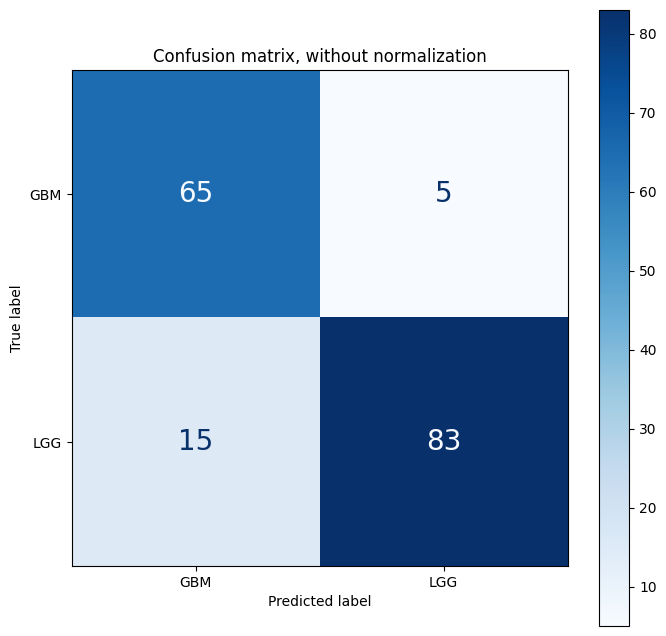

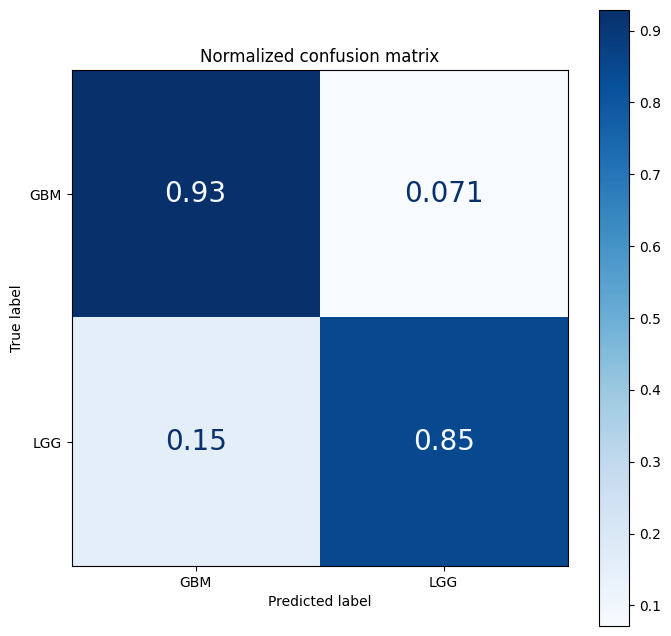

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        model_lgb_optuna,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_lgb_optuna.feature_importances_,X_train.columns)), columns=['Value','Feature'])
feature_imp

Value                                Feature
0       0                           BCOR_MUTATED
1       0                       BCOR_NOT_MUTATED
2       0                          CSMD3_MUTATED
3       0                      CSMD3_NOT_MUTATED
4       0                           FAT4_MUTATED
5       0                       FAT4_NOT_MUTATED
6       0                          FUBP1_MUTATED
7       0                      FUBP1_NOT_MUTATED
8       0                         GRIN2A_MUTATED
9       0                     GRIN2A_NOT_MUTATED
10      0                           IDH2_MUTATED
11      0                       IDH2_NOT_MUTATED
12      0                          MUC16_MUTATED
13      0                            NF1_MUTATED
14      0                        NF1_NOT_MUTATED
15      0                         NOTCH1_MUTATED
16      0                     NOTCH1_NOT_MUTATED
17      0                         PDGFRA_MUTATED
18      0                     PDGFRA_NOT_MUTATED
19      0                         PIK3CA_MUTATED
20      0                     PIK3CA_NOT_MUTATED
21      0                         PIK3R1_MUTATED
22      0                     PIK3R1_NOT_MUTATED
23      0                            RB1_MUTATED
24      0                        RB1_NOT_MUTATED
25      0  Race_american indian or alaska native
26      0                             Race_asian
27      0         Race_black or african american
28      0                             Race_white
29      0                        SMARCA4_MUTATED
30      0                    SMARCA4_NOT_MUTATED
31      1                            CIC_MUTATED
32      1                        CIC_NOT_MUTATED
33      5                      MUC16_NOT_MUTATED
34      6                            Gender_Male
35      7                       IDH1_NOT_MUTATED
36      8                       ATRX_NOT_MUTATED
37      8                           EGFR_MUTATED
38     10                       EGFR_NOT_MUTATED
39     10                           PTEN_MUTATED
40     10                       TP53_NOT_MUTATED
41     12                       PTEN_NOT_MUTATED
42     16                           ATRX_MUTATED
43     27                          Gender_Female
44     37                           TP53_MUTATED
45     40                           IDH1_MUTATED
46    363                       Age_at_diagnosis

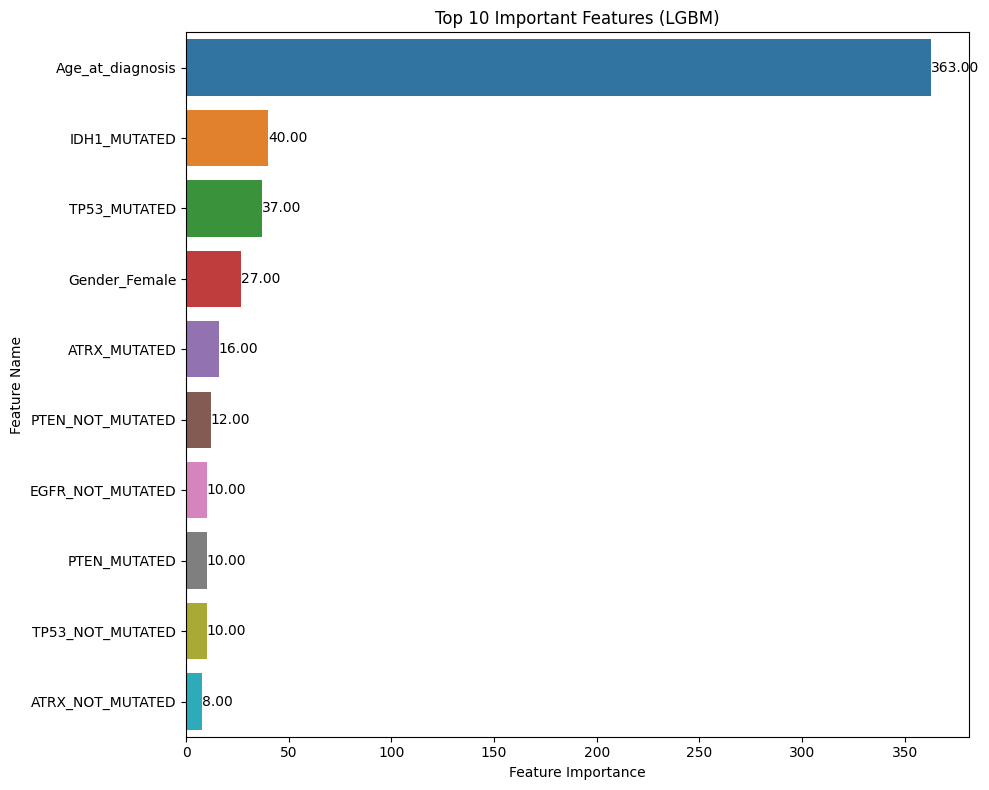

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_lgb_optuna.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

# Select the top 10 features with the largest importance values
top_10_features = feature_imp.nlargest(10, 'Value')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Value", y="Feature", data=top_10_features)
plt.title('Top 10 Important Features (LGBM)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# Annotate each bar with its value
for index, value in enumerate(top_10_features['Value']):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


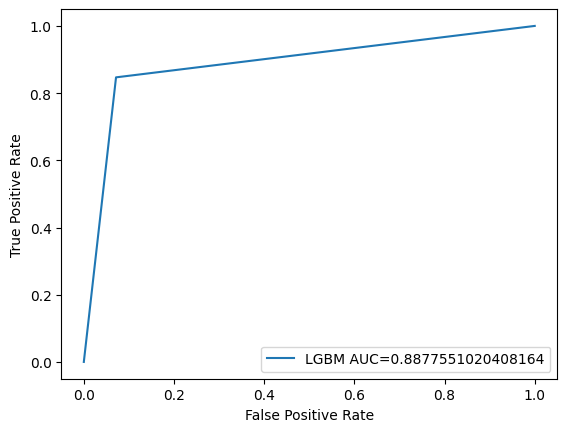

In [ ]:
#define metrics
from sklearn.metrics import roc_curve, roc_auc_score
fpr_lgb, tpr_lgb, _ = roc_curve(y_test,  y_pred)
auc_lgb = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr_lgb,tpr_lgb,label="LGBM AUC="+str(auc_lgb))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Ridge Classifier without optimization

In [ ]:
# Ridge Classifier
ridge_model = RidgeClassifier()
ridge_model.fit(X_train, y_train)

RidgeClassifier()

In [ ]:
y_pred_ = ridge_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_)
print("Accuracy after tuning: %.2f%%" % (accuracy * 100.0))

Accuracy after tuning: 87.33%


In [ ]:
y_pred = ridge_model.predict(X_test)
ridge_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (ridge_accuracy * 100.0))

Accuracy after tuning: 87.50%


In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.8943877551020408

In [ ]:
# classification report for the train set
print(classification_report(y_train, y_pred_, digits = 4))

              precision    recall  f1-score   support

           0     0.8031    0.9255    0.8600       282
           1     0.9393    0.8355    0.8844       389

    accuracy                         0.8733       671
   macro avg     0.8712    0.8805    0.8722       671
weighted avg     0.8821    0.8733    0.8741       671



In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7952    0.9429    0.8627        70
           1     0.9529    0.8265    0.8852        98

    accuracy                         0.8750       168
   macro avg     0.8741    0.8847    0.8740       168
weighted avg     0.8872    0.8750    0.8759       168



Confusion matrix, without normalization
[[66  4]
 [17 81]]
Normalized confusion matrix
[[0.94285714 0.05714286]
 [0.17346939 0.82653061]]


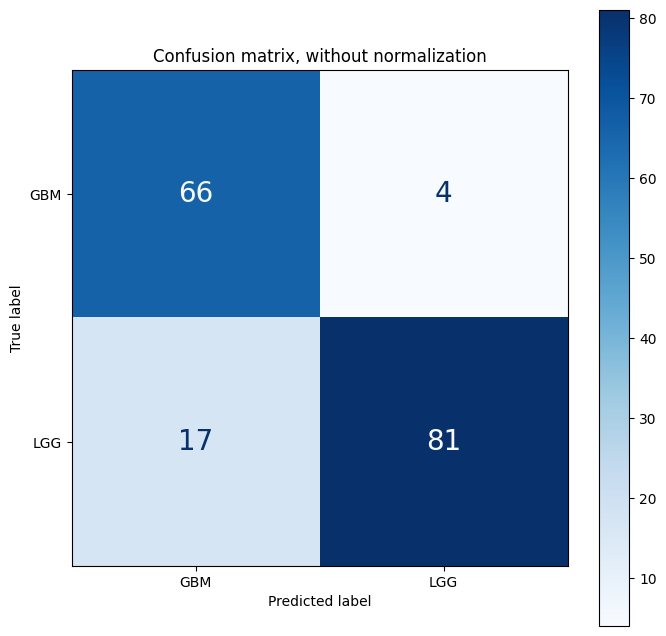

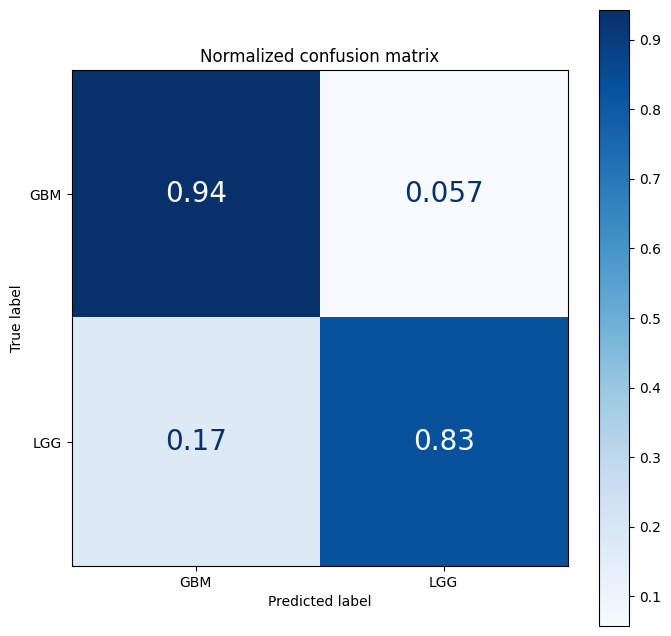

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        ridge_model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

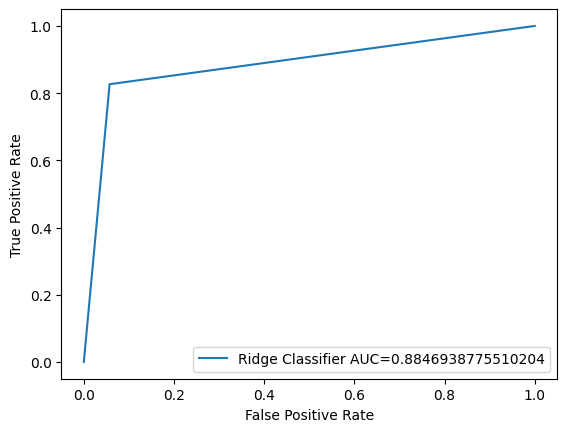

In [ ]:
#define metrics
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="Ridge Classifier AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Ridge Classifier with optuna

In [ ]:

experiment_name = "RidgeClassifier"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()



In [ ]:

def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        "alpha": trial.suggest_loguniform('alpha', 1e-6, 1.0),
    }
    ridge_clf = RidgeClassifier(**param)
    ridge_clf.fit(X_train, y_train)
    preds = ridge_clf.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

# Create the Optuna study and optimize the objective function
study = optuna.create_study(study_name="ridge-classifier", direction='maximize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters and the best score obtained
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)


[I 2023-08-05 19:23:31,894] A new study created in memory with name: ridge-classifier
[I 2023-08-05 19:23:31,912] Trial 0 finished with value: 0.875 and parameters: {'alpha': 0.0039810423849100385}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:23:31,940] Trial 1 finished with value: 0.875 and parameters: {'alpha': 0.016289772352384446}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:23:31,961] Trial 2 finished with value: 0.875 and parameters: {'alpha': 0.0005702802376726277}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:23:31,984] Trial 3 finished with value: 0.875 and parameters: {'alpha': 0.0020604215683487264}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:23:32,008] Trial 4 finished with value: 0.875 and parameters: {'alpha': 0.0013416374891017419}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:23:32,027] Trial 5 finished with value: 0.875 and parameters: {'alpha': 0.01066911228756513}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:23:32,052] T

Best hyperparameters: {'alpha': 0.0039810423849100385}
Best accuracy: 0.875


In [ ]:
# Evaluate emissions
ridge_emissions = tracker.stop()
print(f"Emissions from this training run: {ridge_emissions:.5f} kg CO2eq")

Emissions from this training run: 0.00004 kg CO2eq


In [ ]:
#params = study.best_params
params = study.best_params
params

{'alpha': 0.0039810423849100385}

In [ ]:
model_RidgeC_optuna = RidgeClassifier(**params)
model_RidgeC_optuna.fit(X_train, y_train)

RidgeClassifier(alpha=0.0039810423849100385)

In [ ]:
y_pred = model_RidgeC_optuna.predict(X_test)
ridge_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (ridge_accuracy * 100.0))

Accuracy after tuning: 87.50%


In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.8943877551020408

In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7952    0.9429    0.8627        70
           1     0.9529    0.8265    0.8852        98

    accuracy                         0.8750       168
   macro avg     0.8741    0.8847    0.8740       168
weighted avg     0.8872    0.8750    0.8759       168



Confusion matrix, without normalization
[[66  4]
 [17 81]]
Normalized confusion matrix
[[0.94285714 0.05714286]
 [0.17346939 0.82653061]]


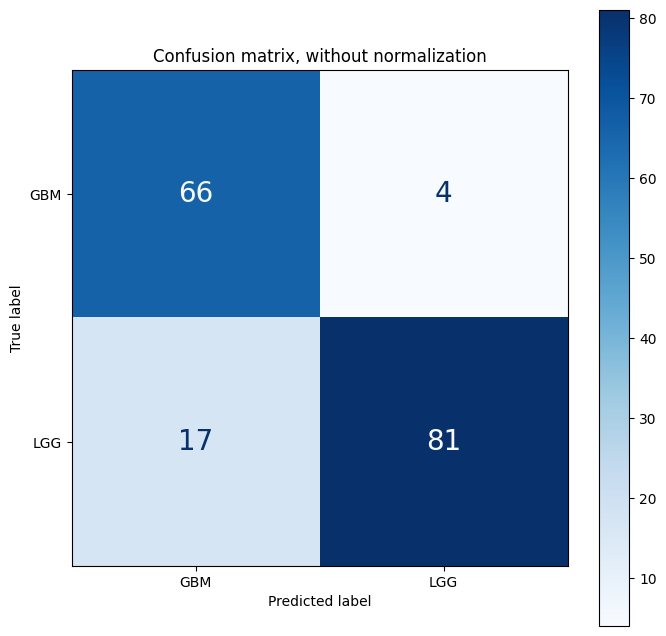

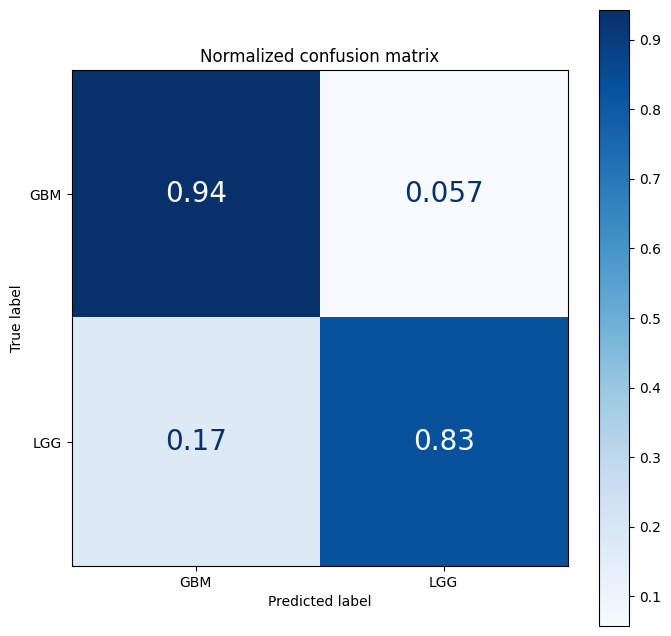

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        model_RidgeC_optuna,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

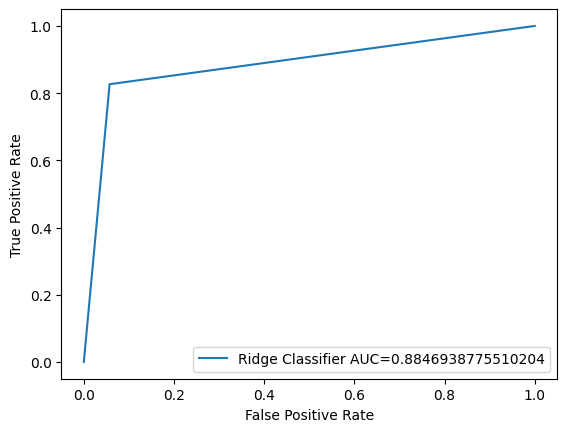

In [ ]:
#define metrics
from sklearn.metrics import roc_curve, roc_auc_score
fpr_ridge, tpr_ridge, _ = roc_curve(y_test,  y_pred)
auc_ridge = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr_ridge,tpr_ridge,label="Ridge Classifier AUC="+str(auc_ridge))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## ExtraTreeclassifier without optimization

In [ ]:
# ExtraTreeclassifier
ExtraT_model = ExtraTreesClassifier()
ExtraT_model.fit(X_train, y_train)

ExtraTreesClassifier()

In [ ]:
y_pred = ExtraT_model.predict(X_test)
extratree_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (extratree_accuracy * 100.0))


Accuracy after tuning: 83.93%


In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.8321428571428572

In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.8028    0.8143    0.8085        70
           1     0.8660    0.8571    0.8615        98

    accuracy                         0.8393       168
   macro avg     0.8344    0.8357    0.8350       168
weighted avg     0.8397    0.8393    0.8394       168



Confusion matrix, without normalization
[[57 13]
 [14 84]]
Normalized confusion matrix
[[0.81428571 0.18571429]
 [0.14285714 0.85714286]]


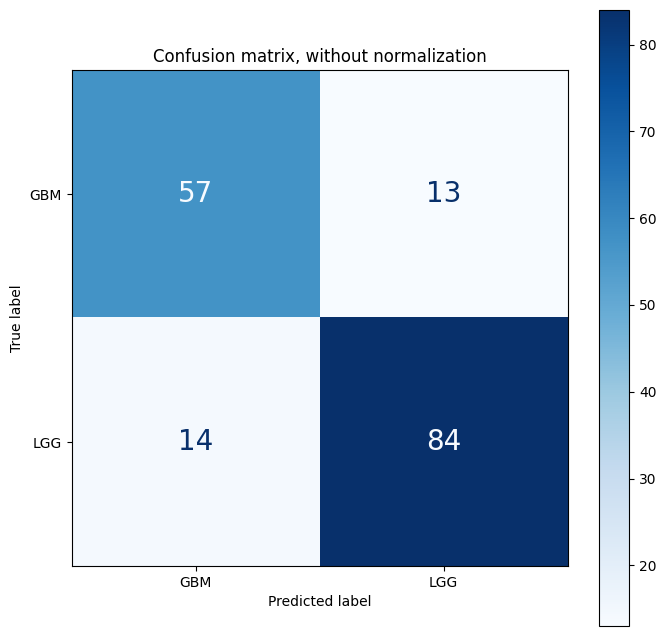

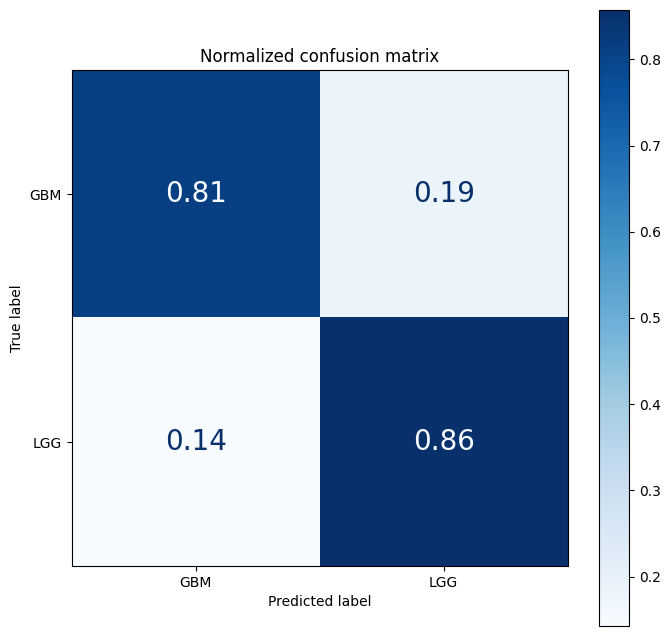

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        ExtraT_model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

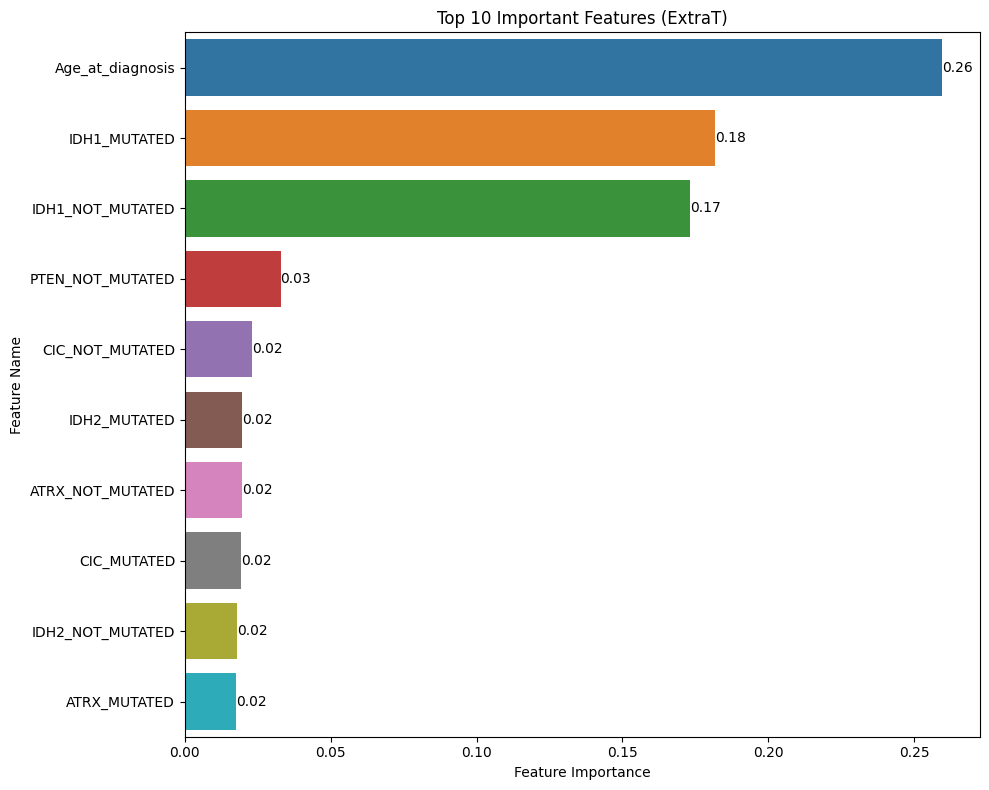

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(ExtraT_model.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

# Select the top 10 features with the largest importance values
top_10_features = feature_imp.nlargest(10, 'Value')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Value", y="Feature", data=top_10_features)
plt.title('Top 10 Important Features (ExtraT)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# Annotate each bar with its value
for index, value in enumerate(top_10_features['Value']):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


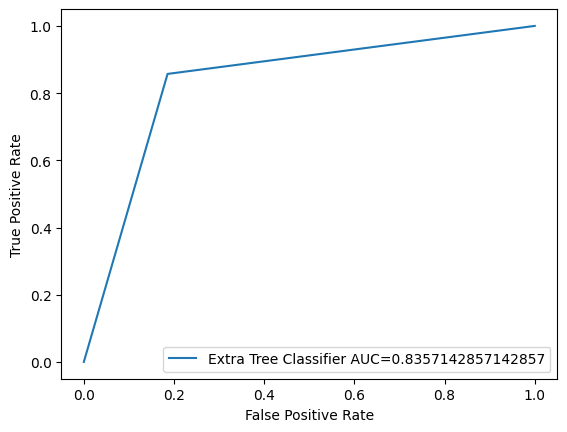

In [ ]:
#define metrics
#y_pred_proba = model_RandomF_optuna.predict_proba(X_test)[::,1]
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="Extra Tree Classifier AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## ExtraTreeClassifier with Optuna

In [ ]:
experiment_name = "ExtratreeClassifier"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()



In [ ]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth' : trial.suggest_int('max_depth', 3, 20)


    }
    model = ExtraTreesClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

# Create the Optuna study and optimize the objective function
study = optuna.create_study(study_name="ExtraTree",direction='maximize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters and the best score obtained
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

[I 2023-08-05 19:35:03,547] A new study created in memory with name: ExtraTree
[I 2023-08-05 19:35:05,092] Trial 0 finished with value: 0.875 and parameters: {'n_estimators': 800, 'max_depth': 5}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:35:06,366] Trial 1 finished with value: 0.8511904761904762 and parameters: {'n_estimators': 500, 'max_depth': 14}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:35:08,029] Trial 2 finished with value: 0.8511904761904762 and parameters: {'n_estimators': 600, 'max_depth': 17}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:35:08,331] Trial 3 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 100, 'max_depth': 19}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:35:09,752] Trial 4 finished with value: 0.875 and parameters: {'n_estimators': 600, 'max_depth': 8}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:35:11,372] Trial 5 finished with value: 0.875 and parameters: {'n_estimators': 900, 'max_depth': 

Best hyperparameters: {'n_estimators': 100, 'max_depth': 12}
Best accuracy: 0.8928571428571429


In [ ]:
# Evaluate emissions
extratree_emissions = tracker.stop()
print(f"Emissions from this training run: {extratree_emissions:.5f} kg CO2eq")

Emissions from this training run: 0.00071 kg CO2eq


In [ ]:
params = study.best_params
params

{'n_estimators': 100, 'max_depth': 12}

In [ ]:
model_ExtraT_optuna = ExtraTreesClassifier(**params)
model_ExtraT_optuna.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=12)

In [ ]:
y_pred = model_ExtraT_optuna.predict(X_test)
extratree_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (extratree_accuracy * 100.0))


Accuracy after tuning: 87.50%


In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.8862244897959185

In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred, digits =4))

              precision    recall  f1-score   support

           0     0.8101    0.9143    0.8591        70
           1     0.9326    0.8469    0.8877        98

    accuracy                         0.8750       168
   macro avg     0.8714    0.8806    0.8734       168
weighted avg     0.8816    0.8750    0.8758       168



Confusion matrix, without normalization
[[64  6]
 [15 83]]
Normalized confusion matrix
[[0.91428571 0.08571429]
 [0.15306122 0.84693878]]


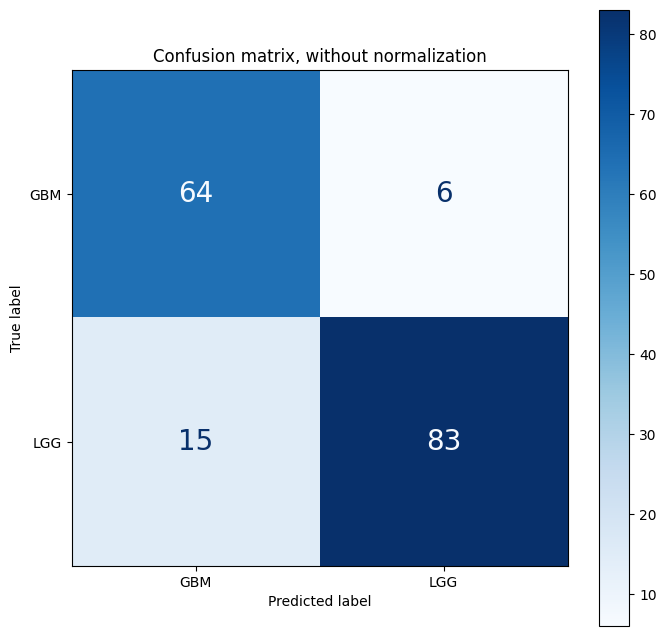

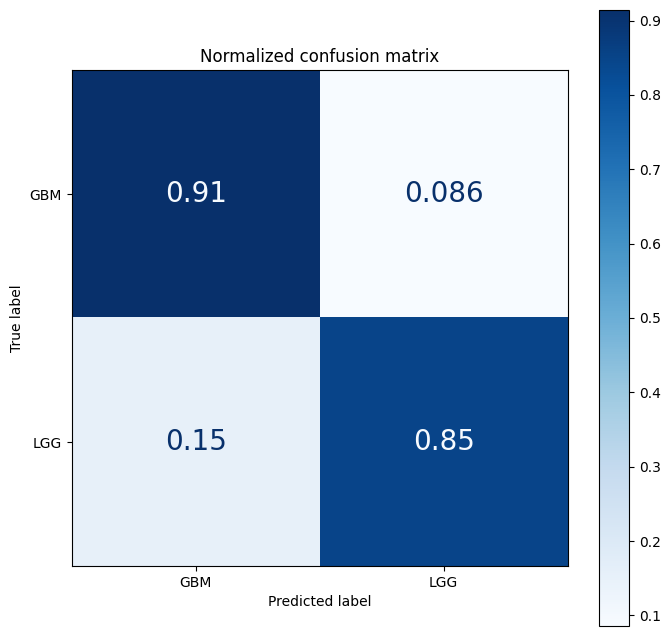

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        model_ExtraT_optuna,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_ExtraT_optuna.feature_importances_,X_train.columns)), columns=['Value','Feature'])
feature_imp

Value                                Feature
0   0.001489                          CSMD3_MUTATED
1   0.001626                       BCOR_NOT_MUTATED
2   0.001720                           BCOR_MUTATED
3   0.001742                      CSMD3_NOT_MUTATED
4   0.002349  Race_american indian or alaska native
5   0.002758                       FAT4_NOT_MUTATED
6   0.002993                           FAT4_MUTATED
7   0.003352                          FUBP1_MUTATED
8   0.003449                         GRIN2A_MUTATED
9   0.003491                    SMARCA4_NOT_MUTATED
10  0.003569                     PDGFRA_NOT_MUTATED
11  0.003680                     GRIN2A_NOT_MUTATED
12  0.003771                      FUBP1_NOT_MUTATED
13  0.003947                        SMARCA4_MUTATED
14  0.004380                         NOTCH1_MUTATED
15  0.005067                             Race_asian
16  0.005077                        NF1_NOT_MUTATED
17  0.005176                         PDGFRA_MUTATED
18  0.005293         Race_black or african american
19  0.005740                     PIK3CA_NOT_MUTATED
20  0.005932                         PIK3CA_MUTATED
21  0.006354                     PIK3R1_NOT_MUTATED
22  0.006607                     NOTCH1_NOT_MUTATED
23  0.006616                            NF1_MUTATED
24  0.006813                            Gender_Male
25  0.007147                         PIK3R1_MUTATED
26  0.007631                          MUC16_MUTATED
27  0.007922                          Gender_Female
28  0.007945                             Race_white
29  0.008068                      MUC16_NOT_MUTATED
30  0.009327                            RB1_MUTATED
31  0.009921                        RB1_NOT_MUTATED
32  0.011504                           TP53_MUTATED
33  0.012016                           EGFR_MUTATED
34  0.012106                       TP53_NOT_MUTATED
35  0.017066                       EGFR_NOT_MUTATED
36  0.023693                       IDH2_NOT_MUTATED
37  0.025047                       ATRX_NOT_MUTATED
38  0.025232                           IDH2_MUTATED
39  0.029313                        CIC_NOT_MUTATED
40  0.030620                           PTEN_MUTATED
41  0.032594                       PTEN_NOT_MUTATED
42  0.037030                            CIC_MUTATED
43  0.038641                           ATRX_MUTATED
44  0.069706                       Age_at_diagnosis
45  0.206278                       IDH1_NOT_MUTATED
46  0.268200                           IDH1_MUTATED

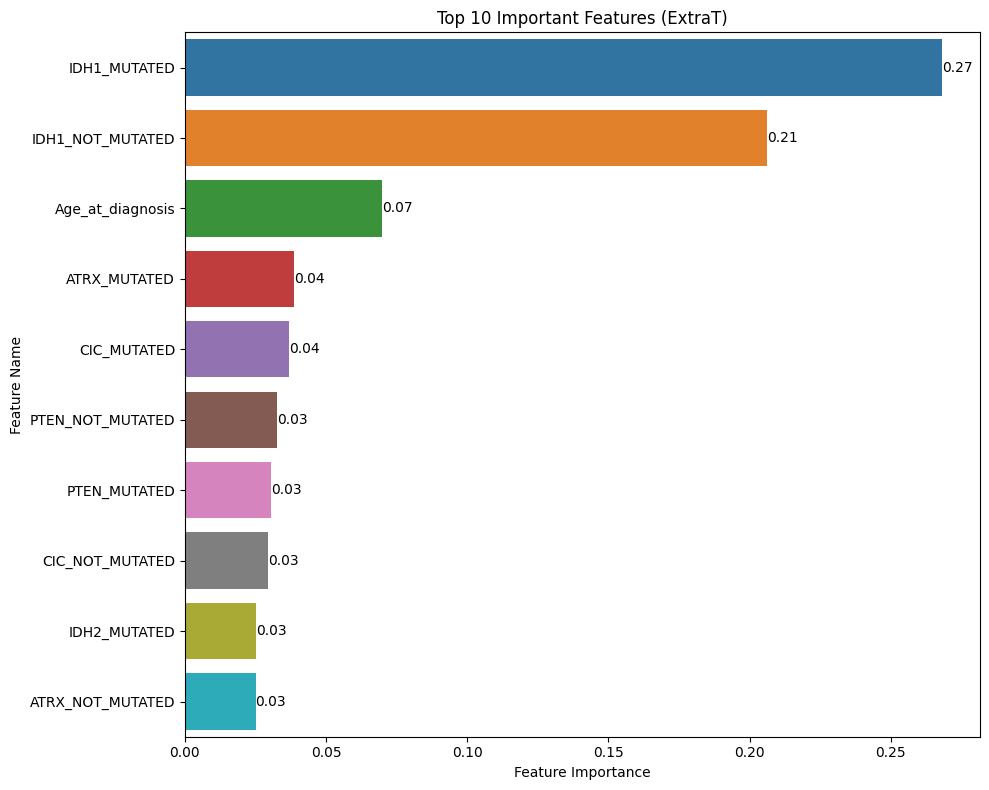

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_ExtraT_optuna.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

# Select the top 10 features with the largest importance values
top_10_features = feature_imp.nlargest(10, 'Value')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Value", y="Feature", data=top_10_features)
plt.title('Top 10 Important Features (ExtraT)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# Annotate each bar with its value
for index, value in enumerate(top_10_features['Value']):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


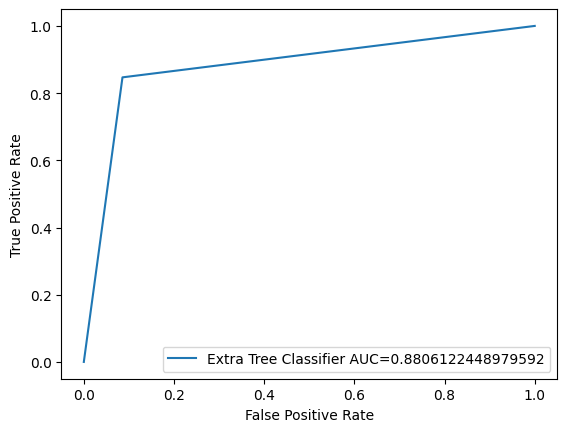

In [ ]:
#define metrics
#y_pred_proba = model_RandomF_optuna.predict_proba(X_test)[::,1]
from sklearn.metrics import roc_curve, roc_auc_score
fpr_extratree, tpr_extratree, _ = roc_curve(y_test,  y_pred)
auc_extratree = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr_extratree,tpr_extratree,label="Extra Tree Classifier AUC="+str(auc_extratree))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Random Forest without optimization

In [ ]:
# ExtraTreeclassifier
RandomF_model = RandomForestClassifier(random_state=42)
RandomF_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = RandomF_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (rf_accuracy * 100.0))


Accuracy after tuning: 83.93%


In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.8362244897959185

In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.7945    0.8286    0.8112        70
           1     0.8737    0.8469    0.8601        98

    accuracy                         0.8393       168
   macro avg     0.8341    0.8378    0.8356       168
weighted avg     0.8407    0.8393    0.8397       168



Confusion matrix, without normalization
[[58 12]
 [15 83]]
Normalized confusion matrix
[[0.82857143 0.17142857]
 [0.15306122 0.84693878]]


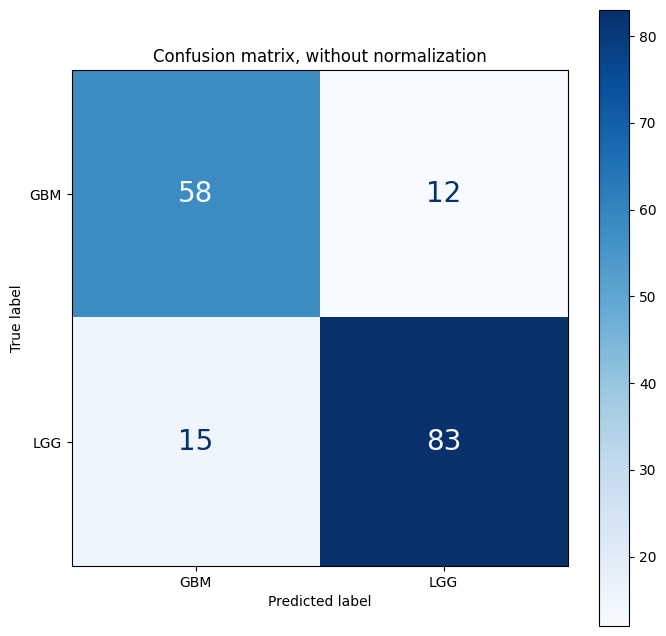

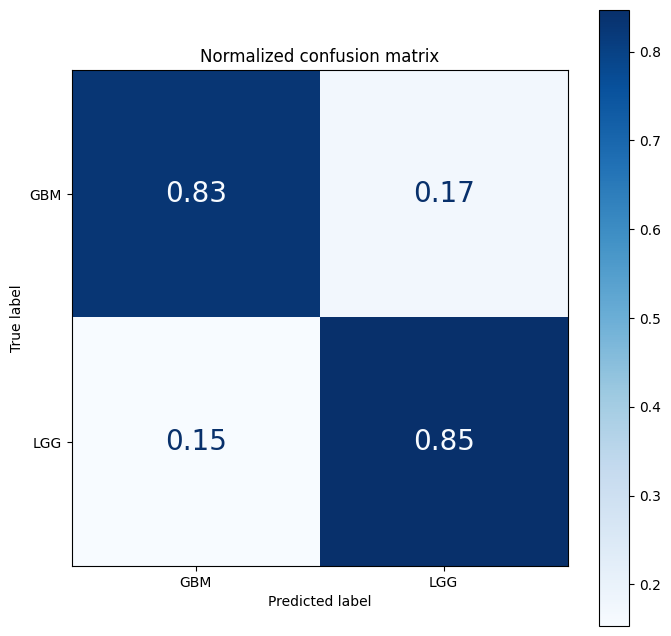

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        RandomF_model,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

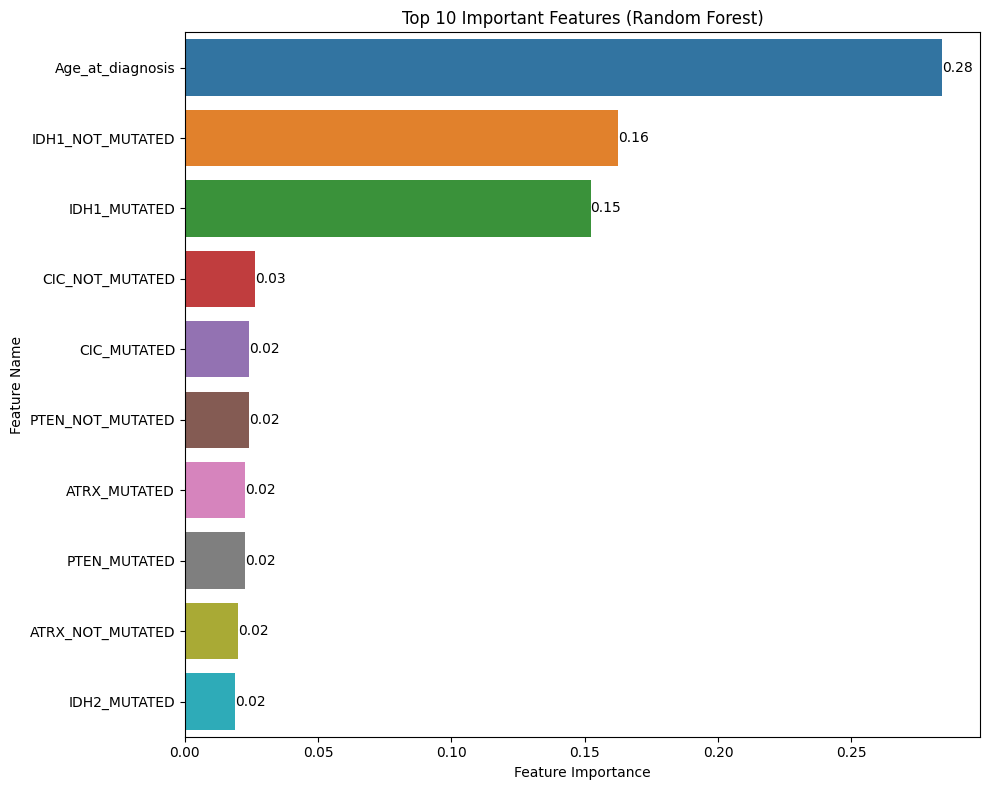

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(RandomF_model.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

# Select the top 10 features with the largest importance values
top_10_features = feature_imp.nlargest(10, 'Value')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Value", y="Feature", data=top_10_features)
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# Annotate each bar with its value
for index, value in enumerate(top_10_features['Value']):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


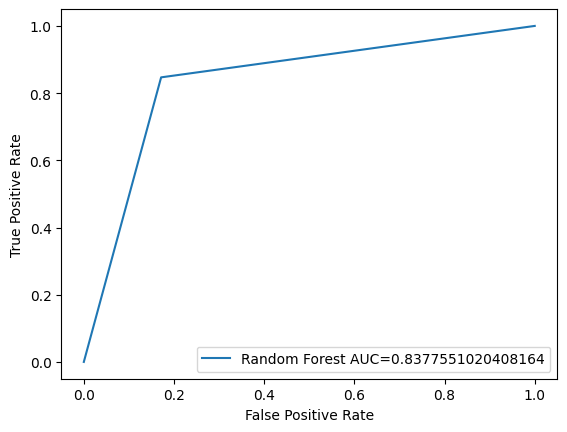

In [ ]:
#define metrics
#y_pred_proba = model_RandomF_optuna.predict_proba(X_test)[::,1]
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr,tpr,label="Random Forest AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Random Forest with Optuna

In [ ]:
experiment_name = "RandomForest"

tracker = EmissionsTracker(
    output_dir="./code_carbon/",
    output_file=f"{experiment_name}_emissions.csv",
    log_level="error",  # comment out this line to see regular output
)
tracker.start()



In [ ]:
def objective(trial):
    """
    Objective function to be minimized.
    """
    param = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500, step=25),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 10),

    }
    model = RandomForestClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

# Create the Optuna study and optimize the objective function
study = optuna.create_study(study_name = 'RandomForest',direction='maximize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters and the best score obtained
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

[I 2023-08-05 19:51:39,427] A new study created in memory with name: RandomForest
[I 2023-08-05 19:51:39,821] Trial 0 finished with value: 0.875 and parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:51:40,643] Trial 1 finished with value: 0.875 and parameters: {'n_estimators': 475, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.875.
[I 2023-08-05 19:51:41,510] Trial 2 finished with value: 0.8869047619047619 and parameters: {'n_estimators': 475, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8869047619047619.
[I 2023-08-05 19:51:42,313] Trial 3 finished with value: 0.875 and parameters: {'n_estimators': 475, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8869047619047619.
[I 2023-08-05 19:51:42,738] Trial 4 finished with value: 0.875 and parameters: {'n_estimators': 250, 'min_samples_split': 3, 'min_samples_leaf'

Best hyperparameters: {'n_estimators': 125, 'min_samples_split': 3, 'min_samples_leaf': 2}
Best accuracy: 0.8988095238095238


In [ ]:
# Evaluate emissions
rf_emissions = tracker.stop()
print(f"Emissions from this training run: {rf_emissions:.5f} kg CO2eq")

Emissions from this training run: 0.00045 kg CO2eq


In [ ]:
#params = study.best_params
params = study.best_params
params

{'n_estimators': 125, 'min_samples_split': 3, 'min_samples_leaf': 2}

In [ ]:
model_RandomF_optuna = RandomForestClassifier(**params)
model_RandomF_optuna.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,
                       n_estimators=125)

In [ ]:
y_pred = model_RandomF_optuna.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy after tuning: %.2f%%" % (rf_accuracy * 100.0))


Accuracy after tuning: 88.10%


In [ ]:
specificity = specificity_score(y_test, y_pred, average='weighted')
specificity

0.8945578231292517

In [ ]:
# classification report for the test set
print(classification_report(y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

           0     0.8125    0.9286    0.8667        70
           1     0.9432    0.8469    0.8925        98

    accuracy                         0.8810       168
   macro avg     0.8778    0.8878    0.8796       168
weighted avg     0.8887    0.8810    0.8817       168



Confusion matrix, without normalization
[[65  5]
 [15 83]]
Normalized confusion matrix
[[0.92857143 0.07142857]
 [0.15306122 0.84693878]]


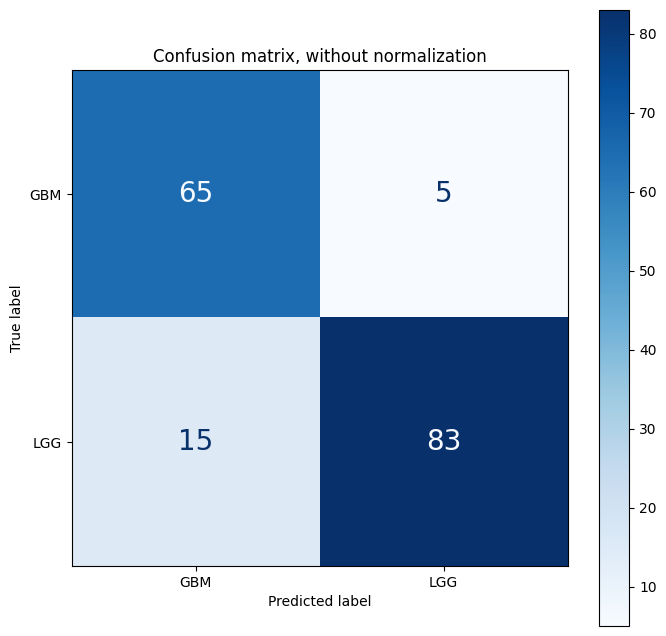

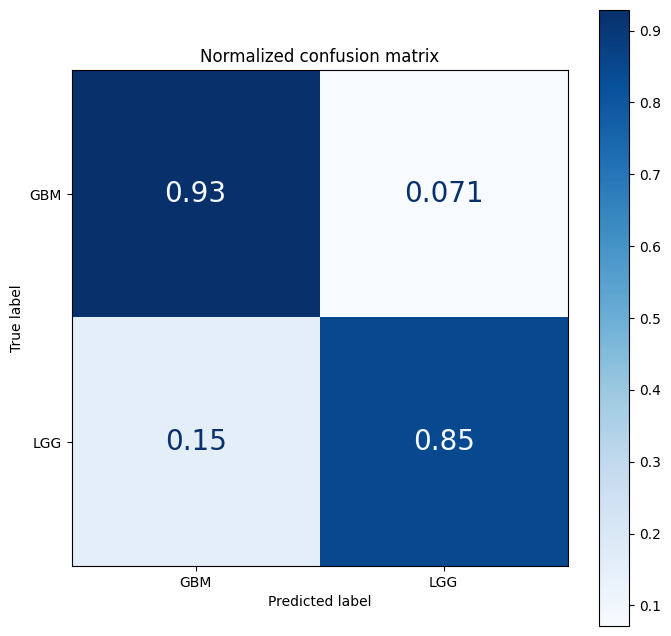

In [ ]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))

    disp = ConfusionMatrixDisplay.from_estimator(
        model_RandomF_optuna,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax,
        text_kw={"size": 20}
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)

    print(title)
    print(disp.confusion_matrix)

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_RandomF_optuna.feature_importances_,X_train.columns)), columns=['Value','Feature'])
feature_imp

Value                                Feature
0   0.000000  Race_american indian or alaska native
1   0.000698                      CSMD3_NOT_MUTATED
2   0.000899                          CSMD3_MUTATED
3   0.001252                        SMARCA4_MUTATED
4   0.001263                           BCOR_MUTATED
5   0.001293                         GRIN2A_MUTATED
6   0.001351                       FAT4_NOT_MUTATED
7   0.001483                       BCOR_NOT_MUTATED
8   0.001569                           FAT4_MUTATED
9   0.001823                    SMARCA4_NOT_MUTATED
10  0.001931                     GRIN2A_NOT_MUTATED
11  0.002245                         PDGFRA_MUTATED
12  0.003082                     PDGFRA_NOT_MUTATED
13  0.003627                             Race_asian
14  0.003822         Race_black or african american
15  0.004500                     PIK3CA_NOT_MUTATED
16  0.004966                        NF1_NOT_MUTATED
17  0.005025                      FUBP1_NOT_MUTATED
18  0.005029                     NOTCH1_NOT_MUTATED
19  0.005222                          FUBP1_MUTATED
20  0.005316                         NOTCH1_MUTATED
21  0.005646                         PIK3R1_MUTATED
22  0.006001                            Gender_Male
23  0.006103                         PIK3CA_MUTATED
24  0.006142                      MUC16_NOT_MUTATED
25  0.006346                     PIK3R1_NOT_MUTATED
26  0.006881                            NF1_MUTATED
27  0.007153                            RB1_MUTATED
28  0.007316                          Gender_Female
29  0.007470                             Race_white
30  0.007565                          MUC16_MUTATED
31  0.008908                        RB1_NOT_MUTATED
32  0.009821                           TP53_MUTATED
33  0.010796                       TP53_NOT_MUTATED
34  0.011703                           EGFR_MUTATED
35  0.012525                       EGFR_NOT_MUTATED
36  0.016023                           IDH2_MUTATED
37  0.020512                       IDH2_NOT_MUTATED
38  0.026351                       PTEN_NOT_MUTATED
39  0.027347                           ATRX_MUTATED
40  0.036625                            CIC_MUTATED
41  0.037066                           PTEN_MUTATED
42  0.037157                       ATRX_NOT_MUTATED
43  0.043562                        CIC_NOT_MUTATED
44  0.171551                       IDH1_NOT_MUTATED
45  0.171634                       Age_at_diagnosis
46  0.235401                           IDH1_MUTATED

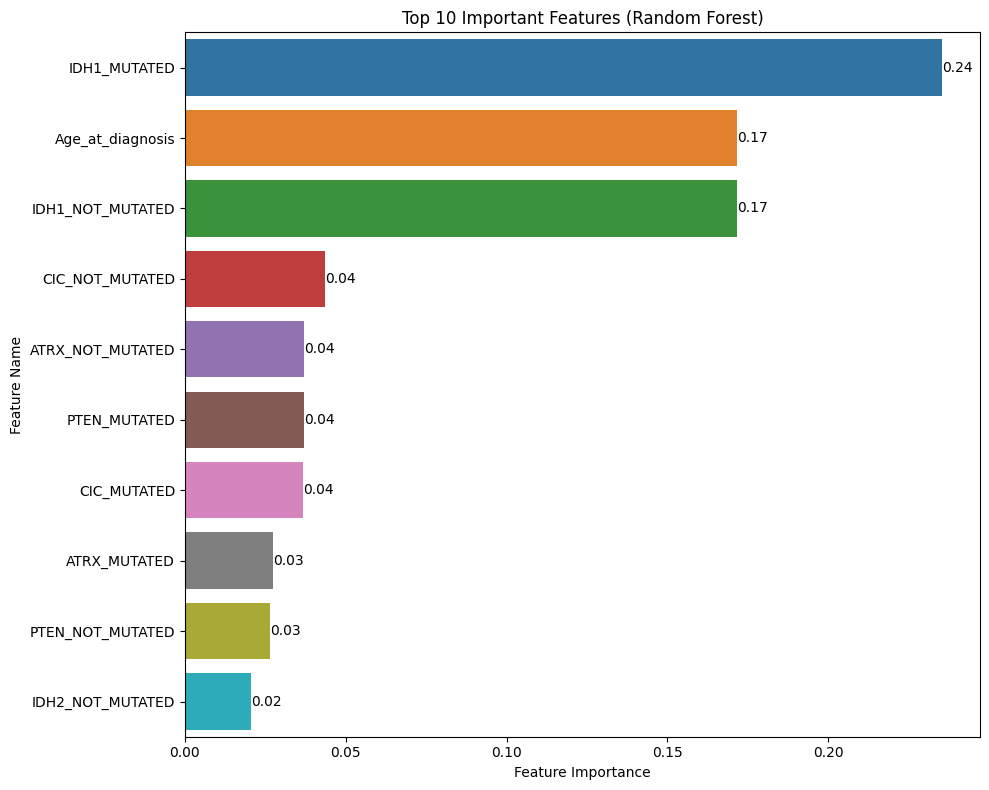

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(model_RandomF_optuna.feature_importances_, X_train.columns)), columns=['Value', 'Feature'])

# Select the top 10 features with the largest importance values
top_10_features = feature_imp.nlargest(10, 'Value')

plt.figure(figsize=(10, 8))
ax = sns.barplot(x="Value", y="Feature", data=top_10_features)
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')

# Annotate each bar with its value
for index, value in enumerate(top_10_features['Value']):
    ax.text(value, index, f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()


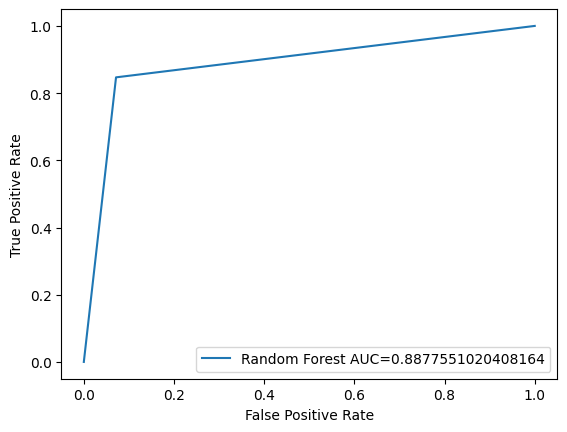

In [ ]:
#define metrics
fpr_rf, tpr_rf, _ = roc_curve(y_test,  y_pred)
auc_rf = roc_auc_score(y_test, y_pred)

#create ROC curve
plt.plot(fpr_rf,tpr_rf,label="Random Forest AUC="+str(auc_rf))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Let's combine the AUC plots

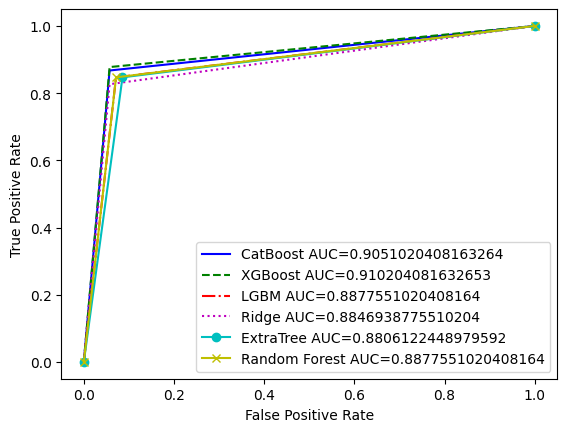

In [ ]:
plt.plot(fpr_cat, tpr_cat, label="CatBoost AUC="+str(auc_cat), linestyle='-', color='b')
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost AUC="+str(auc_xgb), linestyle='--', color='g')
plt.plot(fpr_lgb, tpr_lgb, label="LGBM AUC="+str(auc_lgb), linestyle='-.', color='r')
plt.plot(fpr_ridge, tpr_ridge, label="Ridge AUC="+str(auc_ridge), linestyle=':', color='m')
plt.plot(fpr_extratree, tpr_extratree, label="ExtraTree AUC="+str(auc_extratree), linestyle='-', marker='o', color='c')
plt.plot(fpr_rf, tpr_rf, label="Random Forest AUC="+str(auc_rf), linestyle='-', marker='x', color='y')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


# Carbon emission study

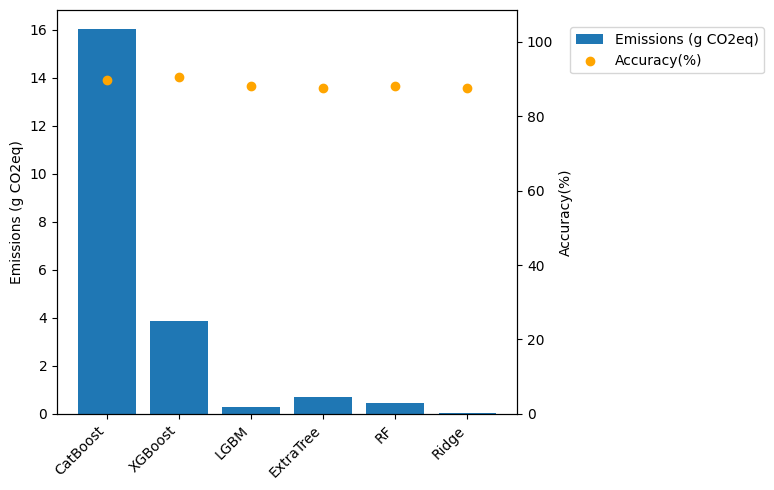

In [ ]:
def plot_comparison(results):
    """
    Plots GHG emissions against Accuracy.
    """
    fig, ax = plt.subplots(figsize=(8, 5))  
    ax.bar(results["Category"], results["Emissions"], label="Emissions (g CO2eq)")
    ax.set_ylabel("Emissions (g CO2eq)")

    ax2 = ax.twinx()
    ax2.scatter(
        results["Category"], results["Accuracy"], color="orange", label="Accuracy(%)",
    )
    ax2.set_ylabel("Accuracy(%)")
    ax2.set_ylim([0, max(results["Accuracy"]) * 1.2])

    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(
        lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.1, 0.9)
    )

    # Rotate the x-axis tick labels diagonally
    ax.set_xticklabels(results["Category"], rotation=45, ha="right")  

model_results = pd.DataFrame(
    {
        "Category": ["CatBoost", "XGBoost", "LGBM", "ExtraTree", "RF", "Ridge"],
        "Accuracy": [catboost_accuracy*100, xgboost_accuracy*100, lgbm_accuracy*100, extratree_accuracy*100, rf_accuracy*100, ridge_accuracy*100],
        "Emissions": [catboost_emissions * 1000, xgboost_emissions * 1000, lgbm_emissions * 1000, extratree_emissions * 1000, rf_emissions * 1000, ridge_emissions * 1000],
    }
)

plot_comparison(model_results)
plt.tight_layout()  
plt.show()


In [ ]:
!zip -r code_carbon.zip '/content/code_carbon'

  adding: content/code_carbon/ (stored 0%)
  adding: content/code_carbon/RidgeClassifier_emissions.csv (deflated 37%)
  adding: content/code_carbon/RandomForest_emissions.csv (deflated 37%)
  adding: content/code_carbon/ExtratreeClassifier_emissions.csv (deflated 37%)
  adding: content/code_carbon/LGBM_emissions.csv (deflated 37%)
  adding: content/code_carbon/XGBoost_emissions.csv (deflated 37%)
  adding: content/code_carbon/CatBoost_emissions.csv (deflated 37%)
